##Dataset Split - 5 clients (2 person data each) + 2 person data - test set

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Path to your dataset in Drive
csv_path = "/content/drive/MyDrive/Fatigue_Set/final_feature_label_dataset_normalized_interpolated.csv"

# Load dataset
df = pd.read_csv(csv_path)

# Shuffle once for fairness
df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)

# Split into train/test (80/20 global split)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

# Split train_df into 4 equal parts (clients)
client_dfs = []
split_size = len(train_df) // 4
for i in range(4):
    start = i * split_size
    end = (i + 1) * split_size if i < 3 else len(train_df)  # last gets remainder
    client_dfs.append(train_df.iloc[start:end].reset_index(drop=True))

# Save splits for clients and test set
for i, cdf in enumerate(client_dfs):
    cdf.to_csv(f"client_{i+1}.csv", index=False)

test_df.to_csv("global_test.csv", index=False)

print("✅ Dataset prepared: 4 clients + global test set")

✅ Dataset prepared: 4 clients + global test set


#FL Implementation With Novelty

##Install necessary libraries

In [ ]:
!pip install flwr["simulation"] torch pandas scikit-learn -q flwr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 703.2/703.2 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.1/250.1 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 44.0.3 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is i

##Code to ignore some deprecation warnings

In [ ]:
# Cell 1 (The very first cell in your notebook)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Suppresses TensorFlow/XLA warnings

print("TensorFlow logging is configured to be silent.")

TensorFlow logging is configured to be silent.


In [ ]:
# Keep this cell at the top of your notebook (e.g., as Cell 2)
import logging
import warnings

# This silences the SERVER-SIDE INFO logs
logging.getLogger("flwr").setLevel(logging.ERROR)

# This is a good general practice, but the client-side fix is more important
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

print("Logging and warnings configured for a cleaner output.")

Logging and warnings configured for a cleaner output.


##Model Code

In [ ]:
# Replace your existing Cell 4 with this
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import pandas as pd
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from collections import OrderedDict
import flwr as fl
import numpy as np
from typing import Dict, List, Tuple
from flwr.common import Context

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# ========== Dataset with THE WINNING INGREDIENT ==========
class FatigueSessionDataset(Dataset):
    def __init__(self, df, session_map=None, compute_elapsed=True):
        df = df.copy()
        df['session'] = df['session'].astype(int)
        df['person'] = df['person'].astype(int)
        df['window_start'] = pd.to_datetime(df['window_start'])
        if compute_elapsed:
            df['elapsed_time'] = df.groupby(['person', 'session'])['window_start'].transform(lambda x: (x - x.min()).dt.total_seconds())
        else:
            df['elapsed_time'] = 0.0
        self.data = df.sort_values(['person', 'session', 'window_start']).reset_index(drop=True)
        self.session_map = session_map if session_map is not None else {s: i for i, s in enumerate(sorted(df['session'].unique()))}

    def __len__(self): return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx].copy()
        # --- THE WINNING INGREDIENT: On-the-fly Data Augmentation ---
        noise_level = 0.015
        row['hr_mean'] += np.random.normal(0, noise_level)
        row['duration_mean'] += np.random.normal(0, noise_level)
        row['ax_mean'] += np.random.normal(0, noise_level)
        row['ay_mean'] += np.random.normal(0, noise_level)
        row['az_mean'] += np.random.normal(0, noise_level)
        row['eda_mean'] += np.random.normal(0, noise_level)
        row['temp_mean'] += np.random.normal(0, noise_level)
        # --- End of Augmentation ---
        HR = torch.tensor([row['hr_mean'], row['hr_std']], dtype=torch.float32)
        IBI = torch.tensor([row['duration_mean'], row['duration_std']], dtype=torch.float32)
        ACC = torch.tensor([row['ax_mean'], row['ax_std'], row['ay_mean'], row['ay_std'], row['az_mean'], row['az_std']], dtype=torch.float32)
        EDA = torch.tensor([row['eda_mean'], row['eda_std']], dtype=torch.float32)
        Temp = torch.tensor([row['temp_mean'], row['temp_std']], dtype=torch.float32)
        phys = torch.tensor([row['physicalFatigueScore']], dtype=torch.float32)
        ment = torch.tensor([row['mentalFatigueScore']], dtype=torch.float32)
        session_index = self.session_map[int(row['session'])]
        session_feat = torch.tensor([float(session_index)], dtype=torch.float32)
        elapsed = torch.tensor([float(row['elapsed_time'])], dtype=torch.float32)
        domain_disc = torch.tensor([0.0], dtype=torch.float32)
        return [HR, IBI, ACC, EDA, Temp], domain_disc, session_feat, elapsed, (phys, ment)

def collate(batch):
    sensor_inputs = [torch.stack([b[0][i] for b in batch]) for i in range(5)]
    domain_disc  = torch.stack([b[1] for b in batch])
    session_feat = torch.stack([b[2] for b in batch])
    elapsed_feat = torch.stack([b[3] for b in batch])
    phys         = torch.stack([b[4][0] for b in batch])
    ment         = torch.stack([b[4][1] for b in batch])
    return sensor_inputs, domain_disc, session_feat, elapsed_feat, (phys, ment)

# ========== Model Components (Unchanged) ==========
class SensorLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
    def forward(self, x):
        if x.ndim == 2: x = x.unsqueeze(1)
        out, _ = self.lstm(x)
        return out[:, -1, :]




class DomainScalingMLP(nn.Module):
    def __init__(self, input_dim=1, n_sensor_stream=5, hidden=16):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(input_dim, hidden), nn.ReLU(), nn.Linear(hidden, n_sensor_stream), nn.Sigmoid())
    def forward(self, domain_disc): return self.net(domain_disc)

class CrossSensorAttention(nn.Module):
    def __init__(self, n_sensor_stream, hidden_dim=32, fusion_dim=64):
        super().__init__()
        self.query, self.key, self.value = nn.Linear(hidden_dim, fusion_dim), nn.Linear(hidden_dim, fusion_dim), nn.Linear(hidden_dim, fusion_dim)
        self.scaler = DomainScalingMLP(input_dim=1, n_sensor_stream=n_sensor_stream, hidden=16)
    def forward(self, features, domain_disc, debug=False):
        x = torch.stack(features, dim=1)
        Q, K, V = self.query(x), self.key(x), self.value(x)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (K.size(--1) ** 0.5)
        attn = F.softmax(scores, dim=-1)
        scaling = self.scaler(domain_disc).unsqueeze(1)
        attn = F.softmax(attn * scaling, dim=-1)
        fused = torch.matmul(attn, V).mean(dim=1)
        return fused

class DomainAdaptiveLayer(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc = nn.Linear(dim, dim)
        self.bn = nn.BatchNorm1d(dim)
    def forward(self, x): return self.bn(self.fc(x))



class AFDA_FL(nn.Module):
    def __init__(self, sensor_dim, lstm_hidden=32, fusion_dim=64, num_sessions=3, use_time_and_session=True):
        super().__init__()
        self.use_time_and_session = use_time_and_session

        # 1. Sensor-Specific Feature Extraction (5 independent LSTMs)
        self.sensor_lstms = nn.ModuleList([SensorLSTM(d, lstm_hidden) for d in sensor_dim])

        # 2. Cross-Sensor Fusion (Attention with Domain Scaling)
        self.attn_fusion = CrossSensorAttention(len(sensor_dim), lstm_hidden, fusion_dim)

        # 3. Domain Adaptation
        self.domain_adapt = DomainAdaptiveLayer(fusion_dim)

        # 4. Contextual Integration
        self.session_emb = nn.Embedding(num_sessions, 8)
        self.time_enc = nn.Sequential(nn.Linear(1, 8), nn.ReLU(), nn.Linear(8, 8))

        # 5. Final Sequence Modeling
        global_input_dim = fusion_dim + 16 if use_time_and_session else fusion_dim
        self.global_lstm = nn.LSTM(global_input_dim, 32, batch_first=True)

        # 6. Regression Heads
        self.reg_phys = nn.Linear(32, 1)
        self.reg_ment = nn.Linear(32, 1)

        self.apply(self._init_weights)
    @staticmethod
    def _init_weights(m):
        if isinstance(m, (nn.Linear)):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None: nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LSTM):
            for name, param in m.named_parameters():
                if 'weight' in name: nn.init.xavier_uniform_(param)
                elif 'bias' in name: nn.init.zeros_(param)
    def forward(self, sensor_inputs, domain_disc, session_feat=None, elapsed_feat=None, debug=False):
        feats = [m(inp) for m, inp in zip(self.sensor_lstms, sensor_inputs)]
        fused = self.attn_fusion(feats, domain_disc, debug=debug)
        adapted = self.domain_adapt(fused)
        if self.use_time_and_session:
            session_emb = self.session_emb(session_feat.squeeze(-1).long())
            time_emb = self.time_enc(elapsed_feat)
            adapted = torch.cat([adapted, session_emb, time_emb], dim=1)
        glstm_out, _ = self.global_lstm(adapted.unsqueeze(1))
        feat = glstm_out[:, -1, :]
        return self.reg_phys(feat), self.reg_ment(feat)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


##Train and Test Function

In [ ]:
# Replace your existing Cell 6 with this
def train(net, trainloader, epochs):
    net.train()
    optimizer = torch.optim.Adam(net.parameters(), lr=5e-4)
    criterion = nn.MSELoss()
    for _ in range(epochs):
        for sensor_stream, dom, session_feat, elapsed_feat, (phys, ment) in trainloader:
            sensor_stream = [m.to(DEVICE) for m in sensor_stream]
            dom, session_feat, elapsed_feat = dom.to(DEVICE), session_feat.to(DEVICE), elapsed_feat.to(DEVICE)
            phys, ment = phys.to(DEVICE), ment.to(DEVICE)
            optimizer.zero_grad()
            p_pred, m_pred = net(sensor_stream, dom, session_feat, elapsed_feat)
            loss = criterion(p_pred, phys) + 2 * criterion(m_pred, ment)
            loss.backward()
            optimizer.step()

def test(net, testloader):
    net.eval()
    criterion = nn.MSELoss()
    total_loss, all_phys_preds, all_phys_labels, all_ment_preds, all_ment_labels = 0.0, [], [], [], []
    with torch.no_grad():
        for sensor_stream, dom, session_feat, elapsed_feat, (phys, ment) in testloader:
            sensor_stream = [m.to(DEVICE) for m in sensor_stream]
            dom, session_feat, elapsed_feat = dom.to(DEVICE), session_feat.to(DEVICE), elapsed_feat.to(DEVICE)
            phys, ment = phys.to(DEVICE), ment.to(DEVICE)
            p_pred, m_pred = net(sensor_stream, dom, session_feat, elapsed_feat)
            total_loss += (criterion(p_pred, phys) + criterion(m_pred, ment)).item()
            all_phys_preds.extend(p_pred.squeeze().cpu().numpy())
            all_phys_labels.extend(phys.squeeze().cpu().numpy())
            all_ment_preds.extend(m_pred.squeeze().cpu().numpy())
            all_ment_labels.extend(ment.squeeze().cpu().numpy())
    loss = total_loss / len(testloader) if len(testloader) > 0 else 0
    rmse_phys = math.sqrt(mean_squared_error(all_phys_labels, all_phys_preds))
    mae_phys = mean_absolute_error(all_phys_labels, all_phys_preds)
    r2_phys = r2_score(all_phys_labels, all_phys_preds)
    rmse_ment = math.sqrt(mean_squared_error(all_ment_labels, all_ment_preds))
    mae_ment = mean_absolute_error(all_ment_labels, all_ment_preds)
    r2_ment = r2_score(all_ment_labels, all_ment_preds)
    metrics = {"loss": loss, "rmse_physical": rmse_phys, "mae_physical": mae_phys, "r2_physical": r2_phys, "rmse_mental": rmse_ment, "mae_mental": mae_ment, "r2_mental": r2_ment}
    return loss, metrics

##Dataset Processing

In [ ]:
# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- Update this path ---
CSV_PATH = '/content/drive/MyDrive/Fatigue_Set/final_feature_label_dataset_normalized_interpolated.csv'
NUM_CLIENTS = 10

def load_datasets():
    """Loads the dataset and partitions it for the clients."""
    df = pd.read_csv(CSV_PATH)
    session_map = {s: i for i, s in enumerate(sorted(df['session'].astype(int).unique()))}
    num_sessions = len(session_map)
    full_dataset = FatigueSessionDataset(df, session_map=session_map, compute_elapsed=True)
    len_train = int(len(full_dataset) * 0.8)
    len_val = len(full_dataset) - len_train
    ds_train, ds_val = random_split(full_dataset, [len_train, len_val], torch.Generator().manual_seed(42))
    partition_size = len(ds_train) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    for i in range(len(ds_train) % NUM_CLIENTS): lengths[i] += 1
    datasets = random_split(ds_train, lengths, torch.Generator().manual_seed(42))
    trainloaders, valloaders = [], []
    for ds in datasets:
        trainloaders.append(DataLoader(ds, batch_size=32, shuffle=True, collate_fn=collate, drop_last=True)) # Bug fix
        valloaders.append(DataLoader(ds_val, batch_size=32, shuffle=False, collate_fn=collate))
    testloader = DataLoader(ds_val, batch_size=32, shuffle=False, collate_fn=collate)
    return trainloaders, valloaders, testloader, num_sessions

trainloaders, valloaders, testloader, NUM_SESSIONS = load_datasets()

Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


##Flower Client Code

In [ ]:
# Replace your existing Cell 7 with this entire block of code

class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net, self.trainloader, self.valloader = net, trainloader, valloader
    def get_parameters(self, config):
        return [val.cpu().numpy() for _, val in self.net.state_dict().items()]
    def set_parameters(self, parameters):
        params_dict = zip(self.net.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        self.net.load_state_dict(state_dict, strict=True)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        # This correctly calls the simple 'train' function for your winning FedAvg run
        train(self.net, self.trainloader, epochs=8)
        return self.get_parameters(config={}), len(self.trainloader.dataset), {}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        loss, metrics = test(self.net, self.valloader)

        # We now correctly return all 3 items Flower expects: (loss, num_examples, metrics)
        return loss, len(self.valloader.dataset), metrics

def client_fn(cid: str) -> fl.client.Client:
    net = AFDA_FL([2,2,6,2,2], lstm_hidden=32, fusion_dim=64, num_sessions=NUM_SESSIONS).to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # This updated return statement also fixes the deprecation warnings for a cleaner output
    return FlowerClient(net, trainloader, valloader).to_client()

##Server strategy code

In [ ]:
# Replace your existing Cell 8 with this
from flwr.server.strategy import FedAvg
from flwr.common import ndarrays_to_parameters

def get_evaluate_fn(testloader, num_sessions):
    def evaluate(server_round: int, parameters: fl.common.NDArrays, config: Dict[str, fl.common.Scalar]):
        net = AFDA_FL([2,2,6,2,2], lstm_hidden=32, fusion_dim=64, num_sessions=num_sessions).to(DEVICE)
        params_dict = zip(net.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        net.load_state_dict(state_dict, strict=True)
        loss, metrics = test(net, testloader)
        print("\n" + "="*50)
        print(f"Server-side evaluation round {server_round}")
        print(f"  - Loss: {metrics['loss']:.4f}")
        print(f"  - Physical Fatigue:")
        print(f"    - RMSE: {metrics['rmse_physical']:.4f} | MAE: {metrics['mae_physical']:.4f} | R² Score: {metrics['r2_physical']:.4f}")
        print(f"  - Mental Fatigue:")
        print(f"    - RMSE: {metrics['rmse_mental']:.4f} | MAE: {metrics['mae_mental']:.4f} | R² Score: {metrics['r2_mental']:.4f}")
        print("="*50 + "\n")
        return loss, metrics
    return evaluate

net = AFDA_FL([2,2,6,2,2], lstm_hidden=32, fusion_dim=64, num_sessions=NUM_SESSIONS).to(DEVICE)
initial_parameters = ndarrays_to_parameters([val.cpu().numpy() for _, val in net.state_dict().items()])

strategy = FedAvg(
    fraction_fit=1.0, fraction_evaluate=1.0, min_fit_clients=NUM_CLIENTS,
    min_evaluate_clients=NUM_CLIENTS, min_available_clients=NUM_CLIENTS,
    evaluate_fn=get_evaluate_fn(testloader, NUM_SESSIONS),
    initial_parameters=initial_parameters,
    on_evaluate_config_fn=lambda r: {"round": r},
)

Same code but includes graph of validation set (Run this instead of previous one if you want validation set graph)

In [ ]:
# Replace your existing Cell 8 with this entire block of code

from flwr.server.strategy import FedAvg
from flwr.common import ndarrays_to_parameters
import matplotlib.pyplot as plt # Import matplotlib for plotting
from scipy.stats import pearsonr # Import for calculating correlation for plot titles
import numpy as np # Import numpy for creating sequence index

# Define the total number of rounds planned for the simulation
NUM_ROUNDS = 80

def get_evaluate_fn(testloader, num_sessions, total_rounds):
    """Return an evaluation function for server-side evaluation."""

    def evaluate(server_round: int, parameters: fl.common.NDArrays, config: Dict[str, fl.common.Scalar]):
        """This function is called by the strategy after each round."""
        net = AFDA_FL([2,2,6,2,2], lstm_hidden=32, fusion_dim=64, num_sessions=num_sessions).to(DEVICE)
        params_dict = zip(net.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        net.load_state_dict(state_dict, strict=True)

        # 1. Standard Evaluation: Calculate metrics using the 'test' function
        loss, metrics = test(net, testloader)

        # 2. Print the detailed report card for every round
        print("\n" + "="*50)
        print(f"Server-side evaluation round {server_round} / {total_rounds}")
        print(f"  - Loss: {metrics['loss']:.4f}")
        print(f"  - Physical Fatigue:")
        print(f"    - RMSE: {metrics['rmse_physical']:.4f} | MAE: {metrics['mae_physical']:.4f} | R² Score: {metrics['r2_physical']:.4f}")
        print(f"  - Mental Fatigue:")
        print(f"    - RMSE: {metrics['rmse_mental']:.4f} | MAE: {metrics['mae_mental']:.4f} | R² Score: {metrics['r2_mental']:.4f}")
        print("="*50 + "\n")

        # 3. Plotting Logic - Only run on the FINAL round
        if server_round == total_rounds:
            print(f"\n--- Generating Final Evaluation Plots (Round {server_round}) ---")

            # Helper function to get predictions and labels
            def generate_final_predictions(final_net, loader):
                final_net.eval()
                phys_preds_final, phys_labels_final = [], []
                ment_preds_final, ment_labels_final = [], []
                with torch.no_grad():
                    for sensor_stream, dom, sf, ef, (ph, mn) in loader:
                        sensor_stream = [m.to(DEVICE) for m in sensor_stream]
                        dom, sf, ef = dom.to(DEVICE), sf.to(DEVICE), ef.to(DEVICE)
                        # Labels are already tensors, keep them as is for potential device placement
                        ph_cpu, mn_cpu = ph.squeeze().cpu().numpy(), mn.squeeze().cpu().numpy() # Move labels to CPU for plotting

                        p_pred, m_pred = final_net(sensor_stream, dom, sf, ef)
                        phys_preds_final.extend(p_pred.squeeze().cpu().numpy())
                        phys_labels_final.extend(ph_cpu)
                        ment_preds_final.extend(m_pred.squeeze().cpu().numpy())
                        ment_labels_final.extend(mn_cpu)
                # Ensure lists are returned, not single numbers if testloader has only one batch
                phys_preds_final = np.array(phys_preds_final).flatten()
                phys_labels_final = np.array(phys_labels_final).flatten()
                ment_preds_final = np.array(ment_preds_final).flatten()
                ment_labels_final = np.array(ment_labels_final).flatten()
                return phys_labels_final, phys_preds_final, ment_labels_final, ment_preds_final


            # Generate predictions using the final model ('net' already has final parameters)
            phys_labels, phys_preds, ment_labels, ment_preds = generate_final_predictions(net, testloader)

            # Calculate final correlations for plot titles
            corr_phys, _ = pearsonr(phys_labels, phys_preds)
            corr_ment, _ = pearsonr(ment_labels, ment_preds)
            print(f"Final Physical Correlation: {corr_phys:.4f}")
            print(f"Final Mental Correlation:   {corr_ment:.4f}")

            # --- PLOT 1: Predicted vs. Actual Scatter Plot ---
            fig_scatter, axes_scatter = plt.subplots(1, 2, figsize=(14, 6))
            fig_scatter.suptitle(f'Round {server_round}: Predicted vs Actual Fatigue (Validation Set)', fontsize=16)
            # Physical Plot
            min_val_phys = min(min(phys_labels), min(phys_preds))
            max_val_phys = max(max(phys_labels), max(phys_preds))
            axes_scatter[0].scatter(phys_labels, phys_preds, alpha=0.6, label='Predictions')
            axes_scatter[0].plot([min_val_phys, max_val_phys], [min_val_phys, max_val_phys], 'r--', label='Perfect Corr.')
            axes_scatter[0].set_xlabel("Actual Physical Fatigue")
            axes_scatter[0].set_ylabel("Predicted Physical Fatigue")
            axes_scatter[0].set_title(f"Physical Fatigue (Corr: {corr_phys:.3f})")
            axes_scatter[0].grid(True)
            axes_scatter[0].legend()
            axes_scatter[0].set_xlim(min_val_phys - 0.1, max_val_phys + 0.1)
            axes_scatter[0].set_ylim(min_val_phys - 0.1, max_val_phys + 0.1)
            # Mental Plot
            min_val_ment = min(min(ment_labels), min(ment_preds))
            max_val_ment = max(max(ment_labels), max(ment_preds))
            axes_scatter[1].scatter(ment_labels, ment_preds, alpha=0.6, label='Predictions')
            axes_scatter[1].plot([min_val_ment, max_val_ment], [min_val_ment, max_val_ment], 'r--', label='Perfect Corr.')
            axes_scatter[1].set_xlabel("Actual Mental Fatigue")
            axes_scatter[1].set_ylabel("Predicted Mental Fatigue")
            axes_scatter[1].set_title(f"Mental Fatigue (Corr: {corr_ment:.3f})")
            axes_scatter[1].grid(True)
            axes_scatter[1].legend()
            axes_scatter[1].set_xlim(min_val_ment - 0.1, max_val_ment + 0.1)
            axes_scatter[1].set_ylim(min_val_ment - 0.1, max_val_ment + 0.1)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show() # Display the scatter plot

            # --- PLOT 2: Time Series Trend Comparison ---
            print("\nGenerating Trend Comparison plot...")
            fig_trend, axes_trend = plt.subplots(2, 1, figsize=(14, 10), sharex=True) # Share X axis
            fig_trend.suptitle(f'Round {server_round}: Actual vs Predicted Fatigue Trends (Validation Set)', fontsize=16)

            # Create a simple index for the x-axis (sequence of samples)
            sample_index = np.arange(len(phys_labels))

            # Physical Trend Plot
            axes_trend[0].plot(sample_index, phys_labels, 'b-', label='Actual Physical Fatigue', linewidth=1.5)
            axes_trend[0].plot(sample_index, phys_preds, 'r-', label='Predicted Physical Fatigue', linewidth=1.5, alpha=0.8)
            axes_trend[0].set_ylabel("Fatigue Score")
            axes_trend[0].set_title("Physical Fatigue Trends")
            axes_trend[0].grid(True)
            axes_trend[0].legend()

            # Mental Trend Plot
            axes_trend[1].plot(sample_index, ment_labels, 'b-', label='Actual Mental Fatigue', linewidth=1.5)
            axes_trend[1].plot(sample_index, ment_preds, 'r-', label='Predicted Mental Fatigue', linewidth=1.5, alpha=0.8)
            axes_trend[1].set_xlabel("Sample Index in Validation Set")
            axes_trend[1].set_ylabel("Fatigue Score")
            axes_trend[1].set_title("Mental Fatigue Trends")
            axes_trend[1].grid(True)
            axes_trend[1].legend()

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show() # Display the trend plot
            print("--- Final plots generated ---")

        # Return values required by the Flower strategy
        return loss, {"rmse_physical": metrics['rmse_physical'], "rmse_mental": metrics['rmse_mental']}

    return evaluate

# Create an instance of the model to get its initial weights
net = AFDA_FL([2,2,6,2,2], lstm_hidden=32, fusion_dim=64, num_sessions=NUM_SESSIONS).to(DEVICE)
initial_parameters = ndarrays_to_parameters([val.cpu().numpy() for _, val in net.state_dict().items()])

# Create the champion FedAvg strategy, passing the total rounds to the evaluation function
strategy = FedAvg(
    fraction_fit=1.0, fraction_evaluate=1.0, min_fit_clients=NUM_CLIENTS,
    min_evaluate_clients=NUM_CLIENTS, min_available_clients=NUM_CLIENTS,
    evaluate_fn=get_evaluate_fn(testloader, NUM_SESSIONS, NUM_ROUNDS),
    initial_parameters=initial_parameters,
    on_evaluate_config_fn=lambda r: {"round": r},
)

##Start Simulation

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=80, no round_timeout
2025-10-28 13:58:03,742	INFO worker.py:1771 -- Started a local Ray instance.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 7962948404.0, 'node:172.28.0.12': 1.0, 'node:__i


Server-side evaluation round 0 / 80
  - Loss: 0.6165
  - Physical Fatigue:
    - RMSE: 0.7486 | MAE: 0.7060 | R² Score: -11.0666
  - Mental Fatigue:
    - RMSE: 0.2398 | MAE: 0.1884 | R² Score: -0.0028



(pid=11158) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=11158) E0000 00:00:1761659903.648887   11158 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=11158) E0000 00:00:1761659903.667378   11158 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=11158) W0000 00:00:1761659903.723333   11158 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
(pid=11158) W0000 00:00:1761659903.723410   11158 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
(pid=11158) W0000 00:00:1761659903.723417   11158 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid lin


Server-side evaluation round 1 / 80
  - Loss: 0.1147
  - Physical Fatigue:
    - RMSE: 0.2354 | MAE: 0.1814 | R² Score: -0.1930
  - Mental Fatigue:
    - RMSE: 0.2449 | MAE: 0.1879 | R² Score: -0.0454



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 2 / 80
  - Loss: 0.0972
  - Physical Fatigue:
    - RMSE: 0.2095 | MAE: 0.1589 | R² Score: 0.0548
  - Mental Fatigue:
    - RMSE: 0.2322 | MAE: 0.1776 | R² Score: 0.0602



(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11157)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11157)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 3 / 80
  - Loss: 0.0924
  - Physical Fatigue:
    - RMSE: 0.2024 | MAE: 0.1561 | R² Score: 0.1182
  - Mental Fatigue:
    - RMSE: 0.2276 | MAE: 0.1744 | R² Score: 0.0968



(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11157)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11157)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=111


Server-side evaluation round 4 / 80
  - Loss: 0.0895
  - Physical Fatigue:
    - RMSE: 0.1989 | MAE: 0.1553 | R² Score: 0.1483
  - Mental Fatigue:
    - RMSE: 0.2242 | MAE: 0.1723 | R² Score: 0.1237



(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11157)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11157)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 5 / 80
  - Loss: 0.0887
  - Physical Fatigue:
    - RMSE: 0.1973 | MAE: 0.1555 | R² Score: 0.1618
  - Mental Fatigue:
    - RMSE: 0.2237 | MAE: 0.1737 | R² Score: 0.1279



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 6 / 80
  - Loss: 0.0862
  - Physical Fatigue:
    - RMSE: 0.1949 | MAE: 0.1538 | R² Score: 0.1818
  - Mental Fatigue:
    - RMSE: 0.2201 | MAE: 0.1703 | R² Score: 0.1552



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 7 / 80
  - Loss: 0.0851
  - Physical Fatigue:
    - RMSE: 0.1941 | MAE: 0.1530 | R² Score: 0.1887
  - Mental Fatigue:
    - RMSE: 0.2182 | MAE: 0.1697 | R² Score: 0.1701



(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11157)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11157)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 8 / 80
  - Loss: 0.0824
  - Physical Fatigue:
    - RMSE: 0.1891 | MAE: 0.1474 | R² Score: 0.2298
  - Mental Fatigue:
    - RMSE: 0.2163 | MAE: 0.1677 | R² Score: 0.1845



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 9 / 80
  - Loss: 0.0830
  - Physical Fatigue:
    - RMSE: 0.1892 | MAE: 0.1464 | R² Score: 0.2291
  - Mental Fatigue:
    - RMSE: 0.2176 | MAE: 0.1682 | R² Score: 0.1747



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 8x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 8x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 8x across cluster]
(ClientAppActor pid=111


Server-side evaluation round 10 / 80
  - Loss: 0.0816
  - Physical Fatigue:
    - RMSE: 0.1876 | MAE: 0.1461 | R² Score: 0.2423
  - Mental Fatigue:
    - RMSE: 0.2157 | MAE: 0.1672 | R² Score: 0.1887



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 11 / 80
  - Loss: 0.0805
  - Physical Fatigue:
    - RMSE: 0.1846 | MAE: 0.1424 | R² Score: 0.2663
  - Mental Fatigue:
    - RMSE: 0.2155 | MAE: 0.1670 | R² Score: 0.1903



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 12 / 80
  - Loss: 0.0805
  - Physical Fatigue:
    - RMSE: 0.1861 | MAE: 0.1446 | R² Score: 0.2540
  - Mental Fatigue:
    - RMSE: 0.2139 | MAE: 0.1661 | R² Score: 0.2019



(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11157)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11157)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=111


Server-side evaluation round 13 / 80
  - Loss: 0.0805
  - Physical Fatigue:
    - RMSE: 0.1841 | MAE: 0.1421 | R² Score: 0.2704
  - Mental Fatigue:
    - RMSE: 0.2158 | MAE: 0.1668 | R² Score: 0.1879



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=111


Server-side evaluation round 14 / 80
  - Loss: 0.0790
  - Physical Fatigue:
    - RMSE: 0.1823 | MAE: 0.1408 | R² Score: 0.2841
  - Mental Fatigue:
    - RMSE: 0.2137 | MAE: 0.1650 | R² Score: 0.2037



(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=11157)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=11157)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 15 / 80
  - Loss: 0.0780
  - Physical Fatigue:
    - RMSE: 0.1811 | MAE: 0.1394 | R² Score: 0.2938
  - Mental Fatigue:
    - RMSE: 0.2125 | MAE: 0.1635 | R² Score: 0.2125



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 16 / 80
  - Loss: 0.0768
  - Physical Fatigue:
    - RMSE: 0.1799 | MAE: 0.1387 | R² Score: 0.3033
  - Mental Fatigue:
    - RMSE: 0.2108 | MAE: 0.1620 | R² Score: 0.2253



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 17 / 80
  - Loss: 0.0748
  - Physical Fatigue:
    - RMSE: 0.1769 | MAE: 0.1373 | R² Score: 0.3266
  - Mental Fatigue:
    - RMSE: 0.2085 | MAE: 0.1575 | R² Score: 0.2421



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 18 / 80
  - Loss: 0.0747
  - Physical Fatigue:
    - RMSE: 0.1798 | MAE: 0.1386 | R² Score: 0.3042
  - Mental Fatigue:
    - RMSE: 0.2055 | MAE: 0.1572 | R² Score: 0.2636



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 19 / 80
  - Loss: 0.0738
  - Physical Fatigue:
    - RMSE: 0.1773 | MAE: 0.1367 | R² Score: 0.3234
  - Mental Fatigue:
    - RMSE: 0.2056 | MAE: 0.1566 | R² Score: 0.2631



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 20 / 80
  - Loss: 0.0714
  - Physical Fatigue:
    - RMSE: 0.1757 | MAE: 0.1353 | R² Score: 0.3352
  - Mental Fatigue:
    - RMSE: 0.2011 | MAE: 0.1527 | R² Score: 0.2946



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 21 / 80
  - Loss: 0.0717
  - Physical Fatigue:
    - RMSE: 0.1748 | MAE: 0.1339 | R² Score: 0.3422
  - Mental Fatigue:
    - RMSE: 0.2027 | MAE: 0.1534 | R² Score: 0.2837



(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11157)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11157)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 22 / 80
  - Loss: 0.0704
  - Physical Fatigue:
    - RMSE: 0.1735 | MAE: 0.1340 | R² Score: 0.3522
  - Mental Fatigue:
    - RMSE: 0.2006 | MAE: 0.1524 | R² Score: 0.2981



(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11157)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11157)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=111


Server-side evaluation round 23 / 80
  - Loss: 0.0700
  - Physical Fatigue:
    - RMSE: 0.1747 | MAE: 0.1341 | R² Score: 0.3429
  - Mental Fatigue:
    - RMSE: 0.1986 | MAE: 0.1503 | R² Score: 0.3126



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 24 / 80
  - Loss: 0.0697
  - Physical Fatigue:
    - RMSE: 0.1737 | MAE: 0.1342 | R² Score: 0.3506
  - Mental Fatigue:
    - RMSE: 0.1986 | MAE: 0.1520 | R² Score: 0.3124



(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11157)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11157)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=111


Server-side evaluation round 25 / 80
  - Loss: 0.0681
  - Physical Fatigue:
    - RMSE: 0.1713 | MAE: 0.1330 | R² Score: 0.3686
  - Mental Fatigue:
    - RMSE: 0.1965 | MAE: 0.1484 | R² Score: 0.3265



(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 8x across cluster]
(ClientAppActor pid=11157)             This is a deprecated feature. It will be removed [repeated 8x across cluster]
(ClientAppActor pid=11157)             entirely in future versions of Flower. [repeated 8x across cluster]
(ClientAppActor pid=111


Server-side evaluation round 26 / 80
  - Loss: 0.0684
  - Physical Fatigue:
    - RMSE: 0.1718 | MAE: 0.1329 | R² Score: 0.3645
  - Mental Fatigue:
    - RMSE: 0.1972 | MAE: 0.1482 | R² Score: 0.3221



(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 8x across cluster]
(ClientAppActor pid=11157)             This is a deprecated feature. It will be removed [repeated 8x across cluster]
(ClientAppActor pid=11157)             entirely in future versions of Flower. [repeated 8x across cluster]
(ClientAppActor pid=111


Server-side evaluation round 27 / 80
  - Loss: 0.0668
  - Physical Fatigue:
    - RMSE: 0.1706 | MAE: 0.1322 | R² Score: 0.3735
  - Mental Fatigue:
    - RMSE: 0.1938 | MAE: 0.1465 | R² Score: 0.3450



(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11157)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11157)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 28 / 80
  - Loss: 0.0685
  - Physical Fatigue:
    - RMSE: 0.1739 | MAE: 0.1340 | R² Score: 0.3489
  - Mental Fatigue:
    - RMSE: 0.1955 | MAE: 0.1471 | R² Score: 0.3339



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 29 / 80
  - Loss: 0.0684
  - Physical Fatigue:
    - RMSE: 0.1727 | MAE: 0.1338 | R² Score: 0.3577
  - Mental Fatigue:
    - RMSE: 0.1965 | MAE: 0.1479 | R² Score: 0.3268



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 30 / 80
  - Loss: 0.0664
  - Physical Fatigue:
    - RMSE: 0.1697 | MAE: 0.1322 | R² Score: 0.3797
  - Mental Fatigue:
    - RMSE: 0.1937 | MAE: 0.1457 | R² Score: 0.3462



(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=11157)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=11157)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=111


Server-side evaluation round 31 / 80
  - Loss: 0.0668
  - Physical Fatigue:
    - RMSE: 0.1706 | MAE: 0.1314 | R² Score: 0.3735
  - Mental Fatigue:
    - RMSE: 0.1940 | MAE: 0.1467 | R² Score: 0.3439



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=111


Server-side evaluation round 32 / 80
  - Loss: 0.0651
  - Physical Fatigue:
    - RMSE: 0.1698 | MAE: 0.1333 | R² Score: 0.3795
  - Mental Fatigue:
    - RMSE: 0.1902 | MAE: 0.1434 | R² Score: 0.3690



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=111


Server-side evaluation round 33 / 80
  - Loss: 0.0654
  - Physical Fatigue:
    - RMSE: 0.1684 | MAE: 0.1307 | R² Score: 0.3897
  - Mental Fatigue:
    - RMSE: 0.1927 | MAE: 0.1443 | R² Score: 0.3529



(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=11157)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=11157)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=111


Server-side evaluation round 34 / 80
  - Loss: 0.0644
  - Physical Fatigue:
    - RMSE: 0.1662 | MAE: 0.1300 | R² Score: 0.4056
  - Mental Fatigue:
    - RMSE: 0.1917 | MAE: 0.1428 | R² Score: 0.3595



(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11157)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11157)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 35 / 80
  - Loss: 0.0639
  - Physical Fatigue:
    - RMSE: 0.1675 | MAE: 0.1298 | R² Score: 0.3962
  - Mental Fatigue:
    - RMSE: 0.1890 | MAE: 0.1410 | R² Score: 0.3772



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 36 / 80
  - Loss: 0.0633
  - Physical Fatigue:
    - RMSE: 0.1650 | MAE: 0.1291 | R² Score: 0.4135
  - Mental Fatigue:
    - RMSE: 0.1898 | MAE: 0.1415 | R² Score: 0.3720



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 37 / 80
  - Loss: 0.0613
  - Physical Fatigue:
    - RMSE: 0.1622 | MAE: 0.1268 | R² Score: 0.4334
  - Mental Fatigue:
    - RMSE: 0.1869 | MAE: 0.1398 | R² Score: 0.3912



(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11157)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11157)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=111


Server-side evaluation round 38 / 80
  - Loss: 0.0631
  - Physical Fatigue:
    - RMSE: 0.1666 | MAE: 0.1282 | R² Score: 0.4021
  - Mental Fatigue:
    - RMSE: 0.1878 | MAE: 0.1407 | R² Score: 0.3848



(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11157)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11157)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=111


Server-side evaluation round 39 / 80
  - Loss: 0.0608
  - Physical Fatigue:
    - RMSE: 0.1625 | MAE: 0.1258 | R² Score: 0.4313
  - Mental Fatigue:
    - RMSE: 0.1853 | MAE: 0.1379 | R² Score: 0.4014



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 40 / 80
  - Loss: 0.0597
  - Physical Fatigue:
    - RMSE: 0.1624 | MAE: 0.1262 | R² Score: 0.4318
  - Mental Fatigue:
    - RMSE: 0.1824 | MAE: 0.1361 | R² Score: 0.4200



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 41 / 80
  - Loss: 0.0602
  - Physical Fatigue:
    - RMSE: 0.1625 | MAE: 0.1266 | R² Score: 0.4312
  - Mental Fatigue:
    - RMSE: 0.1835 | MAE: 0.1367 | R² Score: 0.4127



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=111


Server-side evaluation round 42 / 80
  - Loss: 0.0606
  - Physical Fatigue:
    - RMSE: 0.1642 | MAE: 0.1277 | R² Score: 0.4196
  - Mental Fatigue:
    - RMSE: 0.1833 | MAE: 0.1359 | R² Score: 0.4140



(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11157)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11157)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 43 / 80
  - Loss: 0.0594
  - Physical Fatigue:
    - RMSE: 0.1639 | MAE: 0.1272 | R² Score: 0.4216
  - Mental Fatigue:
    - RMSE: 0.1804 | MAE: 0.1347 | R² Score: 0.4328



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=111


Server-side evaluation round 44 / 80
  - Loss: 0.0584
  - Physical Fatigue:
    - RMSE: 0.1611 | MAE: 0.1246 | R² Score: 0.4409
  - Mental Fatigue:
    - RMSE: 0.1799 | MAE: 0.1345 | R² Score: 0.4360



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=111


Server-side evaluation round 45 / 80
  - Loss: 0.0574
  - Physical Fatigue:
    - RMSE: 0.1623 | MAE: 0.1257 | R² Score: 0.4325
  - Mental Fatigue:
    - RMSE: 0.1757 | MAE: 0.1308 | R² Score: 0.4616



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 46 / 80
  - Loss: 0.0575
  - Physical Fatigue:
    - RMSE: 0.1609 | MAE: 0.1248 | R² Score: 0.4426
  - Mental Fatigue:
    - RMSE: 0.1774 | MAE: 0.1309 | R² Score: 0.4513



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=111


Server-side evaluation round 47 / 80
  - Loss: 0.0577
  - Physical Fatigue:
    - RMSE: 0.1619 | MAE: 0.1263 | R² Score: 0.4359
  - Mental Fatigue:
    - RMSE: 0.1770 | MAE: 0.1333 | R² Score: 0.4538



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=111


Server-side evaluation round 48 / 80
  - Loss: 0.0576
  - Physical Fatigue:
    - RMSE: 0.1615 | MAE: 0.1239 | R² Score: 0.4386
  - Mental Fatigue:
    - RMSE: 0.1774 | MAE: 0.1315 | R² Score: 0.4516



(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11157)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11157)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=111


Server-side evaluation round 49 / 80
  - Loss: 0.0558
  - Physical Fatigue:
    - RMSE: 0.1609 | MAE: 0.1240 | R² Score: 0.4426
  - Mental Fatigue:
    - RMSE: 0.1727 | MAE: 0.1278 | R² Score: 0.4798



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=111


Server-side evaluation round 50 / 80
  - Loss: 0.0549
  - Physical Fatigue:
    - RMSE: 0.1596 | MAE: 0.1238 | R² Score: 0.4515
  - Mental Fatigue:
    - RMSE: 0.1716 | MAE: 0.1273 | R² Score: 0.4867



(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11157)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11157)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=111


Server-side evaluation round 51 / 80
  - Loss: 0.0554
  - Physical Fatigue:
    - RMSE: 0.1607 | MAE: 0.1239 | R² Score: 0.4437
  - Mental Fatigue:
    - RMSE: 0.1720 | MAE: 0.1277 | R² Score: 0.4844



(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11157)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11157)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=111


Server-side evaluation round 52 / 80
  - Loss: 0.0553
  - Physical Fatigue:
    - RMSE: 0.1603 | MAE: 0.1234 | R² Score: 0.4466
  - Mental Fatigue:
    - RMSE: 0.1721 | MAE: 0.1278 | R² Score: 0.4838



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 53 / 80
  - Loss: 0.0547
  - Physical Fatigue:
    - RMSE: 0.1597 | MAE: 0.1227 | R² Score: 0.4510
  - Mental Fatigue:
    - RMSE: 0.1703 | MAE: 0.1269 | R² Score: 0.4945



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 54 / 80
  - Loss: 0.0531
  - Physical Fatigue:
    - RMSE: 0.1578 | MAE: 0.1224 | R² Score: 0.4639
  - Mental Fatigue:
    - RMSE: 0.1676 | MAE: 0.1259 | R² Score: 0.5103



(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11157)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11157)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=111


Server-side evaluation round 55 / 80
  - Loss: 0.0525
  - Physical Fatigue:
    - RMSE: 0.1560 | MAE: 0.1207 | R² Score: 0.4764
  - Mental Fatigue:
    - RMSE: 0.1670 | MAE: 0.1244 | R² Score: 0.5137



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 8x across cluster]
(ClientAppActor pid=11157)             This is a deprecated feature. It will be removed [repeated 8x across cluster]
(ClientAppActor pid=11157)             entirely in future versions of Flower. [repeated 8x across cluster]
(ClientAppActor pid=111


Server-side evaluation round 56 / 80
  - Loss: 0.0540
  - Physical Fatigue:
    - RMSE: 0.1588 | MAE: 0.1212 | R² Score: 0.4569
  - Mental Fatigue:
    - RMSE: 0.1697 | MAE: 0.1262 | R² Score: 0.4980



(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=11157)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=11157)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=111


Server-side evaluation round 57 / 80
  - Loss: 0.0540
  - Physical Fatigue:
    - RMSE: 0.1571 | MAE: 0.1195 | R² Score: 0.4684
  - Mental Fatigue:
    - RMSE: 0.1711 | MAE: 0.1266 | R² Score: 0.4896



(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=11157)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=11157)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=111


Server-side evaluation round 58 / 80
  - Loss: 0.0526
  - Physical Fatigue:
    - RMSE: 0.1562 | MAE: 0.1194 | R² Score: 0.4747
  - Mental Fatigue:
    - RMSE: 0.1677 | MAE: 0.1250 | R² Score: 0.5097



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 59 / 80
  - Loss: 0.0540
  - Physical Fatigue:
    - RMSE: 0.1596 | MAE: 0.1215 | R² Score: 0.4516
  - Mental Fatigue:
    - RMSE: 0.1685 | MAE: 0.1258 | R² Score: 0.5051



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 60 / 80
  - Loss: 0.0544
  - Physical Fatigue:
    - RMSE: 0.1596 | MAE: 0.1213 | R² Score: 0.4514
  - Mental Fatigue:
    - RMSE: 0.1701 | MAE: 0.1267 | R² Score: 0.4953



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=111


Server-side evaluation round 61 / 80
  - Loss: 0.0514
  - Physical Fatigue:
    - RMSE: 0.1539 | MAE: 0.1171 | R² Score: 0.4903
  - Mental Fatigue:
    - RMSE: 0.1664 | MAE: 0.1248 | R² Score: 0.5175



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=111


Server-side evaluation round 62 / 80
  - Loss: 0.0519
  - Physical Fatigue:
    - RMSE: 0.1569 | MAE: 0.1193 | R² Score: 0.4697
  - Mental Fatigue:
    - RMSE: 0.1645 | MAE: 0.1233 | R² Score: 0.5280



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 63 / 80
  - Loss: 0.0517
  - Physical Fatigue:
    - RMSE: 0.1569 | MAE: 0.1184 | R² Score: 0.4703
  - Mental Fatigue:
    - RMSE: 0.1641 | MAE: 0.1225 | R² Score: 0.5306



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 64 / 80
  - Loss: 0.0479
  - Physical Fatigue:
    - RMSE: 0.1506 | MAE: 0.1151 | R² Score: 0.5115
  - Mental Fatigue:
    - RMSE: 0.1585 | MAE: 0.1176 | R² Score: 0.5620



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 65 / 80
  - Loss: 0.0518
  - Physical Fatigue:
    - RMSE: 0.1559 | MAE: 0.1169 | R² Score: 0.4769
  - Mental Fatigue:
    - RMSE: 0.1661 | MAE: 0.1237 | R² Score: 0.5192



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 66 / 80
  - Loss: 0.0497
  - Physical Fatigue:
    - RMSE: 0.1545 | MAE: 0.1179 | R² Score: 0.4862
  - Mental Fatigue:
    - RMSE: 0.1599 | MAE: 0.1188 | R² Score: 0.5541



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 67 / 80
  - Loss: 0.0492
  - Physical Fatigue:
    - RMSE: 0.1532 | MAE: 0.1181 | R² Score: 0.4946
  - Mental Fatigue:
    - RMSE: 0.1594 | MAE: 0.1191 | R² Score: 0.5568



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 68 / 80
  - Loss: 0.0489
  - Physical Fatigue:
    - RMSE: 0.1537 | MAE: 0.1165 | R² Score: 0.4912
  - Mental Fatigue:
    - RMSE: 0.1589 | MAE: 0.1190 | R² Score: 0.5595



(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11157)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11157)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 69 / 80
  - Loss: 0.0495
  - Physical Fatigue:
    - RMSE: 0.1530 | MAE: 0.1166 | R² Score: 0.4957
  - Mental Fatigue:
    - RMSE: 0.1613 | MAE: 0.1206 | R² Score: 0.5465



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 70 / 80
  - Loss: 0.0492
  - Physical Fatigue:
    - RMSE: 0.1540 | MAE: 0.1164 | R² Score: 0.4895
  - Mental Fatigue:
    - RMSE: 0.1592 | MAE: 0.1188 | R² Score: 0.5583



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 71 / 80
  - Loss: 0.0481
  - Physical Fatigue:
    - RMSE: 0.1524 | MAE: 0.1155 | R² Score: 0.5001
  - Mental Fatigue:
    - RMSE: 0.1574 | MAE: 0.1180 | R² Score: 0.5680



(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11157)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11157)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 72 / 80
  - Loss: 0.0480
  - Physical Fatigue:
    - RMSE: 0.1537 | MAE: 0.1173 | R² Score: 0.4912
  - Mental Fatigue:
    - RMSE: 0.1553 | MAE: 0.1171 | R² Score: 0.5794



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 73 / 80
  - Loss: 0.0469
  - Physical Fatigue:
    - RMSE: 0.1498 | MAE: 0.1149 | R² Score: 0.5168
  - Mental Fatigue:
    - RMSE: 0.1556 | MAE: 0.1174 | R² Score: 0.5778



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 74 / 80
  - Loss: 0.0459
  - Physical Fatigue:
    - RMSE: 0.1495 | MAE: 0.1141 | R² Score: 0.5191
  - Mental Fatigue:
    - RMSE: 0.1530 | MAE: 0.1152 | R² Score: 0.5919



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 75 / 80
  - Loss: 0.0457
  - Physical Fatigue:
    - RMSE: 0.1508 | MAE: 0.1153 | R² Score: 0.5106
  - Mental Fatigue:
    - RMSE: 0.1513 | MAE: 0.1144 | R² Score: 0.6007



(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=111


Server-side evaluation round 76 / 80
  - Loss: 0.0460
  - Physical Fatigue:
    - RMSE: 0.1497 | MAE: 0.1147 | R² Score: 0.5172
  - Mental Fatigue:
    - RMSE: 0.1531 | MAE: 0.1151 | R² Score: 0.5912



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 77 / 80
  - Loss: 0.0458
  - Physical Fatigue:
    - RMSE: 0.1504 | MAE: 0.1148 | R² Score: 0.5127
  - Mental Fatigue:
    - RMSE: 0.1522 | MAE: 0.1157 | R² Score: 0.5963



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=111


Server-side evaluation round 78 / 80
  - Loss: 0.0443
  - Physical Fatigue:
    - RMSE: 0.1467 | MAE: 0.1123 | R² Score: 0.5365
  - Mental Fatigue:
    - RMSE: 0.1513 | MAE: 0.1146 | R² Score: 0.6010



(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 8x across cluster]
(ClientAppActor pid=11157)             This is a deprecated feature. It will be removed [repeated 8x across cluster]
(ClientAppActor pid=11157)             entirely in future versions of Flower. [repeated 8x across cluster]
(ClientAppActor pid=111


Server-side evaluation round 79 / 80
  - Loss: 0.0456
  - Physical Fatigue:
    - RMSE: 0.1491 | MAE: 0.1130 | R² Score: 0.5213
  - Mental Fatigue:
    - RMSE: 0.1527 | MAE: 0.1154 | R² Score: 0.5934



(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11157) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=11157)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=11157)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111


Server-side evaluation round 80 / 80
  - Loss: 0.0443
  - Physical Fatigue:
    - RMSE: 0.1483 | MAE: 0.1127 | R² Score: 0.5264
  - Mental Fatigue:
    - RMSE: 0.1494 | MAE: 0.1126 | R² Score: 0.6107


--- Generating Final Evaluation Plots (Round 80) ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Final Physical Correlation: 0.7303
Final Mental Correlation:   0.7804


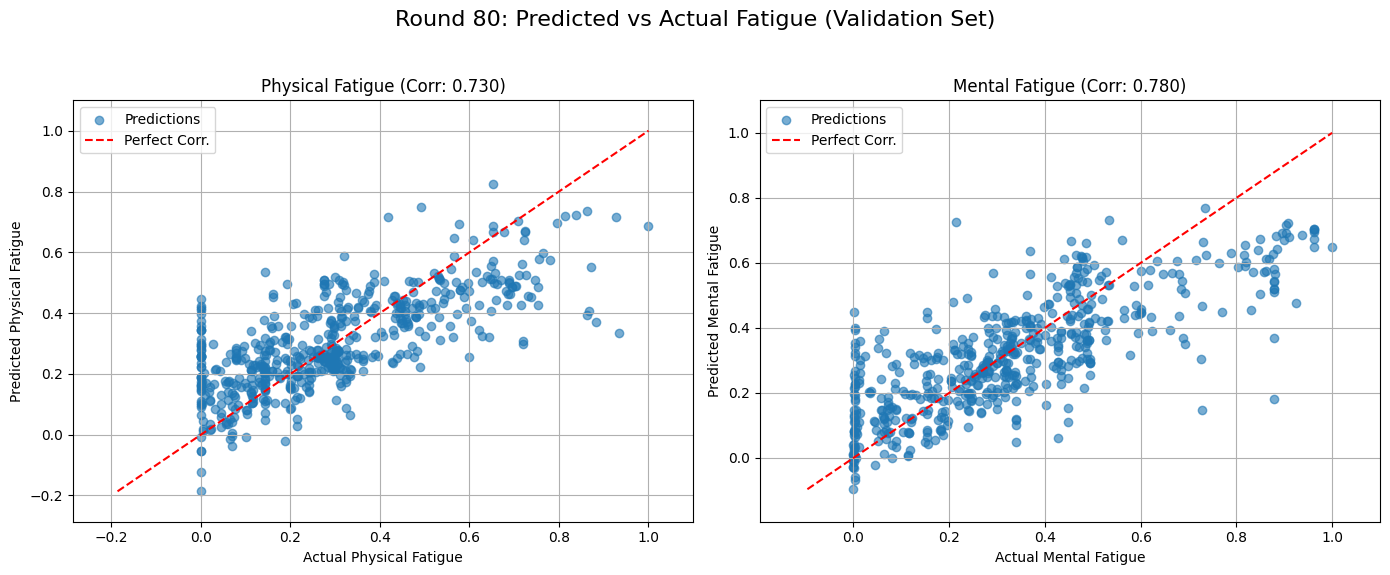


Generating Trend Comparison plot...


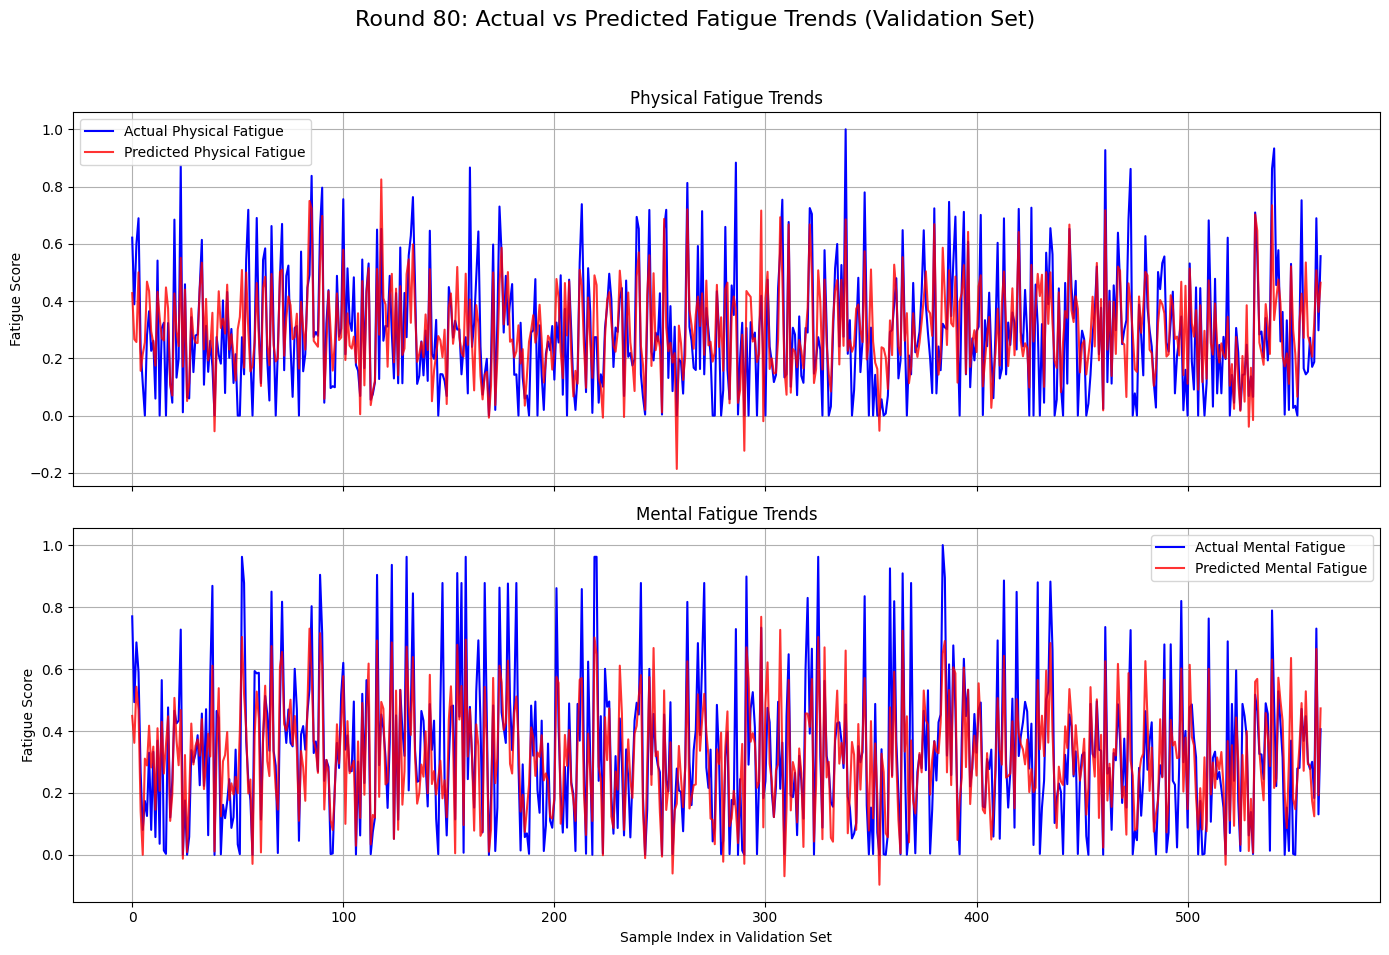

INFO :      fit progress: (80, 0.0442968120591508, {'rmse_physical': 0.14832030109424735, 'rmse_mental': 0.1494343314648682}, 1725.4034112509999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


--- Final plots generated ---


(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11158) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=11158)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=11158)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=11157) 
(ClientAppActor pid=11157)         
(ClientAppActor pid=11158) 
(ClientAppActor pid=11158)         
(ClientAppActor pid=111

Federated Learning Championship Run finished.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Start the simulation for 80 rounds
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=80),
    strategy=strategy,
)

print("Federated Learning Championship Run finished.")

#FL without novelty

##Install necessary libraries

In [ ]:
!pip install flwr["simulation"] torch pandas scikit-learn -q flwr

##Code to ignore some deprecation warnings

In [ ]:
# Cell 1 (The very first cell in your notebook)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Suppresses TensorFlow/XLA warnings

print("TensorFlow logging is configured to be silent.")

TensorFlow logging is configured to be silent.


In [ ]:
# Keep this cell at the top of your notebook (e.g., as Cell 2)
import logging
import warnings

# This silences the SERVER-SIDE INFO logs
logging.getLogger("flwr").setLevel(logging.ERROR)

# This is a good general practice, but the client-side fix is more important
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

print("Logging and warnings configured for a cleaner output.")

Logging and warnings configured for a cleaner output.


##Model Code

In [ ]:
# Replace your existing Cell 4 with this entire block of code

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import pandas as pd
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from collections import OrderedDict
import flwr as fl
import numpy as np
from typing import Dict, List, Tuple
from flwr.common import Context

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# ========== Dataset (with Data Augmentation) - UNCHANGED ==========
class FatigueSessionDataset(Dataset):
    def __init__(self, df, session_map=None, compute_elapsed=True):
        df = df.copy()
        df['session'] = df['session'].astype(int)
        df['person'] = df['person'].astype(int)
        df['window_start'] = pd.to_datetime(df['window_start'])
        if compute_elapsed:
            df['elapsed_time'] = df.groupby(['person', 'session'])['window_start'].transform(lambda x: (x - x.min()).dt.total_seconds())
        else:
            df['elapsed_time'] = 0.0
        self.data = df.sort_values(['person', 'session', 'window_start']).reset_index(drop=True)
        self.session_map = session_map if session_map is not None else {s: i for i, s in enumerate(sorted(df['session'].unique()))}

    def __len__(self): return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx].copy()
        noise_level = 0.015
        row['hr_mean'] += np.random.normal(0, noise_level)
        row['duration_mean'] += np.random.normal(0, noise_level)
        row['ax_mean'] += np.random.normal(0, noise_level)
        row['ay_mean'] += np.random.normal(0, noise_level)
        row['az_mean'] += np.random.normal(0, noise_level)
        row['eda_mean'] += np.random.normal(0, noise_level)
        row['temp_mean'] += np.random.normal(0, noise_level)
        HR = torch.tensor([row['hr_mean'], row['hr_std']], dtype=torch.float32)
        IBI = torch.tensor([row['duration_mean'], row['duration_std']], dtype=torch.float32)
        ACC = torch.tensor([row['ax_mean'], row['ax_std'], row['ay_mean'], row['ay_std'], row['az_mean'], row['az_std']], dtype=torch.float32)
        EDA = torch.tensor([row['eda_mean'], row['eda_std']], dtype=torch.float32)
        Temp = torch.tensor([row['temp_mean'], row['temp_std']], dtype=torch.float32)
        phys = torch.tensor([row['physicalFatigueScore']], dtype=torch.float32)
        ment = torch.tensor([row['mentalFatigueScore']], dtype=torch.float32)
        session_index = self.session_map[int(row['session'])]
        session_feat = torch.tensor([float(session_index)], dtype=torch.float32)
        elapsed = torch.tensor([float(row['elapsed_time'])], dtype=torch.float32)
        domain_disc = torch.tensor([0.0], dtype=torch.float32) # Still needed for data loading signature
        return [HR, IBI, ACC, EDA, Temp], domain_disc, session_feat, elapsed, (phys, ment)

def collate(batch):
    sensor_inputs = [torch.stack([b[0][i] for b in batch]) for i in range(5)]
    domain_disc  = torch.stack([b[1] for b in batch])
    session_feat = torch.stack([b[2] for b in batch])
    elapsed_feat = torch.stack([b[3] for b in batch])
    phys         = torch.stack([b[4][0] for b in batch])
    ment         = torch.stack([b[4][1] for b in batch])
    return sensor_inputs, domain_disc, session_feat, elapsed_feat, (phys, ment)

# ========== Model Components ==========
class SensorLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
    def forward(self, x):
        if x.ndim == 2: x = x.unsqueeze(1)
        out, _ = self.lstm(x)
        return out[:, -1, :]

# --- NOTE: CrossSensorAttention and DomainAdaptiveLayer have been REMOVED ---

# ========== NEW Main Model Architecture (Baseline Version) ==========
class BaselineModel_NoFusion(nn.Module):
    def __init__(self, sensor_dim, lstm_hidden=32, num_sessions=3, use_time_and_session=True):
        super().__init__()
        self.use_time_and_session = use_time_and_session
        self.sensor_lstms = nn.ModuleList([SensorLSTM(d, lstm_hidden) for d in sensor_dim])

        # Session and Time embeddings remain the same
        self.session_emb = nn.Embedding(num_sessions, 8)
        self.time_enc = nn.Sequential(nn.Linear(1, 8), nn.ReLU(), nn.Linear(8, 8))

        # --- MODIFIED: The input to the global LSTM is now the concatenation of all Sensor LSTMs ---
        # 5 sensor streams * lstm_hidden_size + session_emb_size + time_emb_size
        concatenated_dim = len(sensor_dim) * lstm_hidden
        global_input_dim = concatenated_dim + 16 if use_time_and_session else concatenated_dim

        self.global_lstm = nn.LSTM(global_input_dim, 32, batch_first=True)
        self.reg_phys = nn.Linear(32, 1)
        self.reg_ment = nn.Linear(32, 1)
        self.apply(self._init_weights)

    @staticmethod
    def _init_weights(m):
        if isinstance(m, (nn.Linear)):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None: nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LSTM):
            for name, param in m.named_parameters():
                if 'weight' in name: nn.init.xavier_uniform_(param)
                elif 'bias' in name: nn.init.zeros_(param)

    def forward(self, sensor_inputs, domain_disc, session_feat=None, elapsed_feat=None, debug=False):
        # 1. Get features from each Sensor LSTM
        feats = [m(inp) for m, inp in zip(self.sensor_lstms, sensor_inputs)]

        # 2. NEW: Simple Concatenation instead of Attention Fusion
        fused = torch.cat(feats, dim=1)

        # 3. Add session and time features
        if self.use_time_and_session:
            session_emb = self.session_emb(session_feat.squeeze(-1).long())
            time_emb = self.time_enc(elapsed_feat)
            fused = torch.cat([fused, session_emb, time_emb], dim=1)

        # 4. Global LSTM and regression heads remain the same
        glstm_out, _ = self.global_lstm(fused.unsqueeze(1))
        feat = glstm_out[:, -1, :]
        return self.reg_phys(feat), self.reg_ment(feat)

##Train and Test Function

In [ ]:
# Replace your existing Cell 6 with this
def train(net, trainloader, epochs):
    net.train()
    optimizer = torch.optim.Adam(net.parameters(), lr=5e-4)
    criterion = nn.MSELoss()
    for _ in range(epochs):
        for sensor_stream, dom, session_feat, elapsed_feat, (phys, ment) in trainloader:
            sensor_stream = [m.to(DEVICE) for m in sensor_stream]
            dom, session_feat, elapsed_feat = dom.to(DEVICE), session_feat.to(DEVICE), elapsed_feat.to(DEVICE)
            phys, ment = phys.to(DEVICE), ment.to(DEVICE)
            optimizer.zero_grad()
            p_pred, m_pred = net(sensor_stream, dom, session_feat, elapsed_feat)
            loss = criterion(p_pred, phys) + 2 * criterion(m_pred, ment)
            loss.backward()
            optimizer.step()

def test(net, testloader):
    net.eval()
    criterion = nn.MSELoss()
    total_loss, all_phys_preds, all_phys_labels, all_ment_preds, all_ment_labels = 0.0, [], [], [], []
    with torch.no_grad():
        for sensor_stream, dom, session_feat, elapsed_feat, (phys, ment) in testloader:
            sensor_stream = [m.to(DEVICE) for m in sensor_stream]
            dom, session_feat, elapsed_feat = dom.to(DEVICE), session_feat.to(DEVICE), elapsed_feat.to(DEVICE)
            phys, ment = phys.to(DEVICE), ment.to(DEVICE)
            p_pred, m_pred = net(sensor_stream, dom, session_feat, elapsed_feat)
            total_loss += (criterion(p_pred, phys) + criterion(m_pred, ment)).item()
            all_phys_preds.extend(p_pred.squeeze().cpu().numpy())
            all_phys_labels.extend(phys.squeeze().cpu().numpy())
            all_ment_preds.extend(m_pred.squeeze().cpu().numpy())
            all_ment_labels.extend(ment.squeeze().cpu().numpy())
    loss = total_loss / len(testloader) if len(testloader) > 0 else 0
    rmse_phys = math.sqrt(mean_squared_error(all_phys_labels, all_phys_preds))
    mae_phys = mean_absolute_error(all_phys_labels, all_phys_preds)
    r2_phys = r2_score(all_phys_labels, all_phys_preds)
    rmse_ment = math.sqrt(mean_squared_error(all_ment_labels, all_ment_preds))
    mae_ment = mean_absolute_error(all_ment_labels, all_ment_preds)
    r2_ment = r2_score(all_ment_labels, all_ment_preds)
    metrics = {"loss": loss, "rmse_physical": rmse_phys, "mae_physical": mae_phys, "r2_physical": r2_phys, "rmse_mental": rmse_ment, "mae_mental": mae_ment, "r2_mental": r2_ment}
    return loss, metrics

##Dataset Processing

In [ ]:
# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- Update this path ---
CSV_PATH = '/content/drive/MyDrive/Fatigue_Set/final_feature_label_dataset_normalized_interpolated.csv'
NUM_CLIENTS = 10

def load_datasets():
    """Loads the dataset and partitions it for the clients."""
    df = pd.read_csv(CSV_PATH)
    session_map = {s: i for i, s in enumerate(sorted(df['session'].astype(int).unique()))}
    num_sessions = len(session_map)
    full_dataset = FatigueSessionDataset(df, session_map=session_map, compute_elapsed=True)
    len_train = int(len(full_dataset) * 0.8)
    len_val = len(full_dataset) - len_train
    ds_train, ds_val = random_split(full_dataset, [len_train, len_val], torch.Generator().manual_seed(42))
    partition_size = len(ds_train) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    for i in range(len(ds_train) % NUM_CLIENTS): lengths[i] += 1
    datasets = random_split(ds_train, lengths, torch.Generator().manual_seed(42))
    trainloaders, valloaders = [], []
    for ds in datasets:
        trainloaders.append(DataLoader(ds, batch_size=32, shuffle=True, collate_fn=collate, drop_last=True)) # Bug fix
        valloaders.append(DataLoader(ds_val, batch_size=32, shuffle=False, collate_fn=collate))
    testloader = DataLoader(ds_val, batch_size=32, shuffle=False, collate_fn=collate)
    return trainloaders, valloaders, testloader, num_sessions

trainloaders, valloaders, testloader, NUM_SESSIONS = load_datasets()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Flower Client Code

In [ ]:
# Replace your existing Cell 7 with this
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net, self.trainloader, self.valloader = net, trainloader, valloader
    def get_parameters(self, config): return [val.cpu().numpy() for _, val in self.net.state_dict().items()]
    def set_parameters(self, parameters):
        params_dict = zip(self.net.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        self.net.load_state_dict(state_dict, strict=True)
    def fit(self, parameters, config):
        self.set_parameters(parameters)
        train(self.net, self.trainloader, epochs=8) # Using the simple train for FedAvg
        return self.get_parameters(config={}), len(self.trainloader.dataset), {}
    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        loss, metrics = test(self.net, self.valloader)
        return loss, len(self.valloader.dataset), metrics

def client_fn(cid: str) -> fl.client.Client:
    # --- MODIFIED: Create an instance of the new baseline model ---
    net = BaselineModel_NoFusion([2,2,6,2,2], lstm_hidden=32, num_sessions=NUM_SESSIONS).to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(net, trainloader, valloader).to_client()

##Server Strategy Code

In [ ]:
# Replace your existing Cell 8 with this
from flwr.server.strategy import FedAvg
from flwr.common import ndarrays_to_parameters

def get_evaluate_fn(testloader, num_sessions):
    def evaluate(server_round: int, parameters: fl.common.NDArrays, config: Dict[str, fl.common.Scalar]):
        # --- MODIFIED: Create an instance of the new baseline model ---
        net = BaselineModel_NoFusion([2,2,6,2,2], lstm_hidden=32, num_sessions=num_sessions).to(DEVICE)

        params_dict = zip(net.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        net.load_state_dict(state_dict, strict=True)
        loss, metrics = test(net, testloader)
        print("\n" + "="*50)
        print(f"Server-side evaluation round {server_round} (Baseline Model)") # Added note for clarity
        print(f"  - Loss: {metrics['loss']:.4f}")
        print(f"  - Physical Fatigue:")
        print(f"    - RMSE: {metrics['rmse_physical']:.4f} | MAE: {metrics['mae_physical']:.4f} | R² Score: {metrics['r2_physical']:.4f}")
        print(f"  - Mental Fatigue:")
        print(f"    - RMSE: {metrics['rmse_mental']:.4f} | MAE: {metrics['mae_mental']:.4f} | R² Score: {metrics['r2_mental']:.4f}")
        print("="*50 + "\n")
        return loss, metrics
    return evaluate

# --- MODIFIED: Create an instance of the new baseline model for initial parameters ---
net = BaselineModel_NoFusion([2,2,6,2,2], lstm_hidden=32, num_sessions=NUM_SESSIONS).to(DEVICE)
initial_parameters = ndarrays_to_parameters([val.cpu().numpy() for _, val in net.state_dict().items()])

strategy = FedAvg(
    fraction_fit=1.0, fraction_evaluate=1.0, min_fit_clients=NUM_CLIENTS,
    min_evaluate_clients=NUM_CLIENTS, min_available_clients=NUM_CLIENTS,
    evaluate_fn=get_evaluate_fn(testloader, NUM_SESSIONS),
    initial_parameters=initial_parameters,
    on_evaluate_config_fn=lambda r: {"round": r},
)

##Start Simulation

In [ ]:
# Start the simulation for 80 rounds
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=80),
    strategy=strategy,
)

print("Federated Learning Championship Run finished.")

2025-09-07 08:16:00,079	INFO worker.py:1771 -- Started a local Ray instance.



Server-side evaluation round 0 (Baseline Model)
  - Loss: 1.5586
  - Physical Fatigue:
    - RMSE: 0.6314 | MAE: 0.5949 | R² Score: -7.5826
  - Mental Fatigue:
    - RMSE: 1.0786 | MAE: 1.0408 | R² Score: -19.2855



(pid=12028) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=12028) E0000 00:00:1757232980.744085   12028 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=12028) E0000 00:00:1757232980.758005   12028 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=12027) W0000 00:00:1757232980.800407   12027 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
(pid=12027) W0000 00:00:1757232980.800471   12027 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
(pid=12027) W0000 00:00:1757232980.800479   12027 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid lin


Server-side evaluation round 1 (Baseline Model)
  - Loss: 0.1064
  - Physical Fatigue:
    - RMSE: 0.2114 | MAE: 0.1745 | R² Score: 0.0378
  - Mental Fatigue:
    - RMSE: 0.2490 | MAE: 0.2032 | R² Score: -0.0809



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120


Server-side evaluation round 2 (Baseline Model)
  - Loss: 0.0936
  - Physical Fatigue:
    - RMSE: 0.2032 | MAE: 0.1627 | R² Score: 0.1113
  - Mental Fatigue:
    - RMSE: 0.2298 | MAE: 0.1831 | R² Score: 0.0796



(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 8x across cluster]
(ClientAppActor pid=12027)             This is a deprecated feature. It will be removed [repeated 8x across cluster]
(ClientAppActor pid=12027)             entirely in future versions of Flower. [repeated 8x across cluster]
(ClientAppActor pid=120


Server-side evaluation round 3 (Baseline Model)
  - Loss: 0.0932
  - Physical Fatigue:
    - RMSE: 0.2025 | MAE: 0.1622 | R² Score: 0.1172
  - Mental Fatigue:
    - RMSE: 0.2293 | MAE: 0.1833 | R² Score: 0.0829



(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=12027)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=12027)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120


Server-side evaluation round 4 (Baseline Model)
  - Loss: 0.0931
  - Physical Fatigue:
    - RMSE: 0.2025 | MAE: 0.1627 | R² Score: 0.1168
  - Mental Fatigue:
    - RMSE: 0.2291 | MAE: 0.1831 | R² Score: 0.0848



(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120


Server-side evaluation round 5 (Baseline Model)
  - Loss: 0.0928
  - Physical Fatigue:
    - RMSE: 0.2025 | MAE: 0.1626 | R² Score: 0.1173
  - Mental Fatigue:
    - RMSE: 0.2286 | MAE: 0.1825 | R² Score: 0.0890



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120


Server-side evaluation round 6 (Baseline Model)
  - Loss: 0.0925
  - Physical Fatigue:
    - RMSE: 0.2020 | MAE: 0.1619 | R² Score: 0.1213
  - Mental Fatigue:
    - RMSE: 0.2284 | MAE: 0.1823 | R² Score: 0.0905



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 8x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 8x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 8x across cluster]
(ClientAppActor pid=120


Server-side evaluation round 7 (Baseline Model)
  - Loss: 0.0930
  - Physical Fatigue:
    - RMSE: 0.2026 | MAE: 0.1629 | R² Score: 0.1165
  - Mental Fatigue:
    - RMSE: 0.2289 | MAE: 0.1832 | R² Score: 0.0865



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 10x across cluster]



Server-side evaluation round 8 (Baseline Model)
  - Loss: 0.0926
  - Physical Fatigue:
    - RMSE: 0.2025 | MAE: 0.1631 | R² Score: 0.1169
  - Mental Fatigue:
    - RMSE: 0.2282 | MAE: 0.1826 | R² Score: 0.0923



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 12x across


Server-side evaluation round 9 (Baseline Model)
  - Loss: 0.0927
  - Physical Fatigue:
    - RMSE: 0.2026 | MAE: 0.1632 | R² Score: 0.1163
  - Mental Fatigue:
    - RMSE: 0.2282 | MAE: 0.1827 | R² Score: 0.0920



(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 11x across cluster]
(ClientAppActor pid=12028)             This is a depre


Server-side evaluation round 10 (Baseline Model)
  - Loss: 0.0926
  - Physical Fatigue:
    - RMSE: 0.2025 | MAE: 0.1630 | R² Score: 0.1175
  - Mental Fatigue:
    - RMSE: 0.2280 | MAE: 0.1825 | R² Score: 0.0935



(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 12x across


Server-side evaluation round 11 (Baseline Model)
  - Loss: 0.0926
  - Physical Fatigue:
    - RMSE: 0.2023 | MAE: 0.1629 | R² Score: 0.1186
  - Mental Fatigue:
    - RMSE: 0.2282 | MAE: 0.1829 | R² Score: 0.0918



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120


Server-side evaluation round 12 (Baseline Model)
  - Loss: 0.0927
  - Physical Fatigue:
    - RMSE: 0.2027 | MAE: 0.1638 | R² Score: 0.1152
  - Mental Fatigue:
    - RMSE: 0.2280 | MAE: 0.1827 | R² Score: 0.0939



(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=12027)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=12027)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=120


Server-side evaluation round 13 (Baseline Model)
  - Loss: 0.0918
  - Physical Fatigue:
    - RMSE: 0.2018 | MAE: 0.1624 | R² Score: 0.1228
  - Mental Fatigue:
    - RMSE: 0.2269 | MAE: 0.1812 | R² Score: 0.1020



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120


Server-side evaluation round 14 (Baseline Model)
  - Loss: 0.0920
  - Physical Fatigue:
    - RMSE: 0.2020 | MAE: 0.1628 | R² Score: 0.1214
  - Mental Fatigue:
    - RMSE: 0.2272 | MAE: 0.1817 | R² Score: 0.0996



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]
(ClientAppActor pid=12027)             This is a deprecated feature. It will be removed [repeated 10x across cluster]



Server-side evaluation round 15 (Baseline Model)
  - Loss: 0.0916
  - Physical Fatigue:
    - RMSE: 0.2020 | MAE: 0.1629 | R² Score: 0.1216
  - Mental Fatigue:
    - RMSE: 0.2264 | MAE: 0.1808 | R² Score: 0.1064



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=120


Server-side evaluation round 16 (Baseline Model)
  - Loss: 0.0920
  - Physical Fatigue:
    - RMSE: 0.2020 | MAE: 0.1628 | R² Score: 0.1211
  - Mental Fatigue:
    - RMSE: 0.2271 | MAE: 0.1816 | R² Score: 0.1011



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120


Server-side evaluation round 17 (Baseline Model)
  - Loss: 0.0912
  - Physical Fatigue:
    - RMSE: 0.2013 | MAE: 0.1618 | R² Score: 0.1276
  - Mental Fatigue:
    - RMSE: 0.2261 | MAE: 0.1807 | R² Score: 0.1087



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120


Server-side evaluation round 18 (Baseline Model)
  - Loss: 0.0913
  - Physical Fatigue:
    - RMSE: 0.2016 | MAE: 0.1626 | R² Score: 0.1246
  - Mental Fatigue:
    - RMSE: 0.2258 | MAE: 0.1806 | R² Score: 0.1110



(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120


Server-side evaluation round 19 (Baseline Model)
  - Loss: 0.0914
  - Physical Fatigue:
    - RMSE: 0.2019 | MAE: 0.1632 | R² Score: 0.1227
  - Mental Fatigue:
    - RMSE: 0.2259 | MAE: 0.1808 | R² Score: 0.1104



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 7x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 7x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 7x across cluster]
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120


Server-side evaluation round 20 (Baseline Model)
  - Loss: 0.0912
  - Physical Fatigue:
    - RMSE: 0.2016 | MAE: 0.1627 | R² Score: 0.1251
  - Mental Fatigue:
    - RMSE: 0.2256 | MAE: 0.1804 | R² Score: 0.1126



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 8x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 8x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 8x across cluster]
(ClientAppActor pid=120


Server-side evaluation round 21 (Baseline Model)
  - Loss: 0.0907
  - Physical Fatigue:
    - RMSE: 0.2015 | MAE: 0.1627 | R² Score: 0.1259
  - Mental Fatigue:
    - RMSE: 0.2246 | MAE: 0.1793 | R² Score: 0.1203



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 12x across


Server-side evaluation round 22 (Baseline Model)
  - Loss: 0.0909
  - Physical Fatigue:
    - RMSE: 0.2011 | MAE: 0.1621 | R² Score: 0.1290
  - Mental Fatigue:
    - RMSE: 0.2253 | MAE: 0.1800 | R² Score: 0.1150



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120


Server-side evaluation round 23 (Baseline Model)
  - Loss: 0.0907
  - Physical Fatigue:
    - RMSE: 0.2016 | MAE: 0.1631 | R² Score: 0.1249
  - Mental Fatigue:
    - RMSE: 0.2245 | MAE: 0.1794 | R² Score: 0.1213



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120


Server-side evaluation round 24 (Baseline Model)
  - Loss: 0.0904
  - Physical Fatigue:
    - RMSE: 0.2010 | MAE: 0.1624 | R² Score: 0.1297
  - Mental Fatigue:
    - RMSE: 0.2243 | MAE: 0.1793 | R² Score: 0.1229



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120


Server-side evaluation round 25 (Baseline Model)
  - Loss: 0.0897
  - Physical Fatigue:
    - RMSE: 0.2004 | MAE: 0.1614 | R² Score: 0.1352
  - Mental Fatigue:
    - RMSE: 0.2234 | MAE: 0.1779 | R² Score: 0.1302



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 12x across


Server-side evaluation round 26 (Baseline Model)
  - Loss: 0.0899
  - Physical Fatigue:
    - RMSE: 0.2004 | MAE: 0.1616 | R² Score: 0.1352
  - Mental Fatigue:
    - RMSE: 0.2237 | MAE: 0.1787 | R² Score: 0.1274



(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 12x across


Server-side evaluation round 27 (Baseline Model)
  - Loss: 0.0895
  - Physical Fatigue:
    - RMSE: 0.2003 | MAE: 0.1616 | R² Score: 0.1358
  - Mental Fatigue:
    - RMSE: 0.2229 | MAE: 0.1779 | R² Score: 0.1337



(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=12027)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=12027)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120


Server-side evaluation round 28 (Baseline Model)
  - Loss: 0.0895
  - Physical Fatigue:
    - RMSE: 0.2006 | MAE: 0.1619 | R² Score: 0.1340
  - Mental Fatigue:
    - RMSE: 0.2227 | MAE: 0.1778 | R² Score: 0.1354



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120


Server-side evaluation round 29 (Baseline Model)
  - Loss: 0.0898
  - Physical Fatigue:
    - RMSE: 0.2006 | MAE: 0.1623 | R² Score: 0.1338
  - Mental Fatigue:
    - RMSE: 0.2234 | MAE: 0.1785 | R² Score: 0.1302



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120


Server-side evaluation round 30 (Baseline Model)
  - Loss: 0.0891
  - Physical Fatigue:
    - RMSE: 0.2001 | MAE: 0.1614 | R² Score: 0.1379
  - Mental Fatigue:
    - RMSE: 0.2223 | MAE: 0.1772 | R² Score: 0.1384



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 10x across cluster]



Server-side evaluation round 31 (Baseline Model)
  - Loss: 0.0891
  - Physical Fatigue:
    - RMSE: 0.2000 | MAE: 0.1617 | R² Score: 0.1384
  - Mental Fatigue:
    - RMSE: 0.2223 | MAE: 0.1776 | R² Score: 0.1386



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120


Server-side evaluation round 32 (Baseline Model)
  - Loss: 0.0901
  - Physical Fatigue:
    - RMSE: 0.2013 | MAE: 0.1635 | R² Score: 0.1272
  - Mental Fatigue:
    - RMSE: 0.2233 | MAE: 0.1787 | R² Score: 0.1304



(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 9x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 9x across cluster]
(ClientAppActor pid=12028)             entirely in future versions


Server-side evaluation round 33 (Baseline Model)
  - Loss: 0.0888
  - Physical Fatigue:
    - RMSE: 0.1995 | MAE: 0.1608 | R² Score: 0.1434
  - Mental Fatigue:
    - RMSE: 0.2220 | MAE: 0.1770 | R² Score: 0.1405



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120


Server-side evaluation round 34 (Baseline Model)
  - Loss: 0.0891
  - Physical Fatigue:
    - RMSE: 0.2002 | MAE: 0.1623 | R² Score: 0.1366
  - Mental Fatigue:
    - RMSE: 0.2219 | MAE: 0.1773 | R² Score: 0.1415



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 3x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 3x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 3x across cluster]
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=120


Server-side evaluation round 35 (Baseline Model)
  - Loss: 0.0887
  - Physical Fatigue:
    - RMSE: 0.1997 | MAE: 0.1616 | R² Score: 0.1413
  - Mental Fatigue:
    - RMSE: 0.2215 | MAE: 0.1766 | R² Score: 0.1446



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120


Server-side evaluation round 36 (Baseline Model)
  - Loss: 0.0885
  - Physical Fatigue:
    - RMSE: 0.1993 | MAE: 0.1611 | R² Score: 0.1447
  - Mental Fatigue:
    - RMSE: 0.2215 | MAE: 0.1769 | R² Score: 0.1448



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=120


Server-side evaluation round 37 (Baseline Model)
  - Loss: 0.0881
  - Physical Fatigue:
    - RMSE: 0.1992 | MAE: 0.1610 | R² Score: 0.1460
  - Mental Fatigue:
    - RMSE: 0.2206 | MAE: 0.1760 | R² Score: 0.1515



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 8x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 8x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 8x across cluster]
(ClientAppActor pid=120


Server-side evaluation round 38 (Baseline Model)
  - Loss: 0.0881
  - Physical Fatigue:
    - RMSE: 0.1993 | MAE: 0.1613 | R² Score: 0.1445
  - Mental Fatigue:
    - RMSE: 0.2204 | MAE: 0.1753 | R² Score: 0.1531



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 10x across cluster]



Server-side evaluation round 39 (Baseline Model)
  - Loss: 0.0881
  - Physical Fatigue:
    - RMSE: 0.1987 | MAE: 0.1604 | R² Score: 0.1501
  - Mental Fatigue:
    - RMSE: 0.2210 | MAE: 0.1762 | R² Score: 0.1483



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 12x across


Server-side evaluation round 40 (Baseline Model)
  - Loss: 0.0881
  - Physical Fatigue:
    - RMSE: 0.1989 | MAE: 0.1608 | R² Score: 0.1485
  - Mental Fatigue:
    - RMSE: 0.2208 | MAE: 0.1758 | R² Score: 0.1501



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120


Server-side evaluation round 41 (Baseline Model)
  - Loss: 0.0874
  - Physical Fatigue:
    - RMSE: 0.1981 | MAE: 0.1594 | R² Score: 0.1550
  - Mental Fatigue:
    - RMSE: 0.2200 | MAE: 0.1749 | R² Score: 0.1558



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=12027)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=12027)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120


Server-side evaluation round 42 (Baseline Model)
  - Loss: 0.0874
  - Physical Fatigue:
    - RMSE: 0.1976 | MAE: 0.1586 | R² Score: 0.1595
  - Mental Fatigue:
    - RMSE: 0.2204 | MAE: 0.1750 | R² Score: 0.1527



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120


Server-side evaluation round 43 (Baseline Model)
  - Loss: 0.0874
  - Physical Fatigue:
    - RMSE: 0.1981 | MAE: 0.1596 | R² Score: 0.1553
  - Mental Fatigue:
    - RMSE: 0.2199 | MAE: 0.1749 | R² Score: 0.1568



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 12x across


Server-side evaluation round 44 (Baseline Model)
  - Loss: 0.0871
  - Physical Fatigue:
    - RMSE: 0.1973 | MAE: 0.1582 | R² Score: 0.1616
  - Mental Fatigue:
    - RMSE: 0.2198 | MAE: 0.1746 | R² Score: 0.1576



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120


Server-side evaluation round 45 (Baseline Model)
  - Loss: 0.0869
  - Physical Fatigue:
    - RMSE: 0.1978 | MAE: 0.1595 | R² Score: 0.1573
  - Mental Fatigue:
    - RMSE: 0.2190 | MAE: 0.1740 | R² Score: 0.1636



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120


Server-side evaluation round 46 (Baseline Model)
  - Loss: 0.0865
  - Physical Fatigue:
    - RMSE: 0.1965 | MAE: 0.1568 | R² Score: 0.1690
  - Mental Fatigue:
    - RMSE: 0.2192 | MAE: 0.1740 | R² Score: 0.1624



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=12027)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=12027)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=120


Server-side evaluation round 47 (Baseline Model)
  - Loss: 0.0865
  - Physical Fatigue:
    - RMSE: 0.1967 | MAE: 0.1573 | R² Score: 0.1671
  - Mental Fatigue:
    - RMSE: 0.2189 | MAE: 0.1739 | R² Score: 0.1644



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]
(ClientAppActor pid=12027)             This is a deprecated feature. It will be removed [repeated 10x across cluster]



Server-side evaluation round 48 (Baseline Model)
  - Loss: 0.0861
  - Physical Fatigue:
    - RMSE: 0.1964 | MAE: 0.1575 | R² Score: 0.1692
  - Mental Fatigue:
    - RMSE: 0.2184 | MAE: 0.1732 | R² Score: 0.1684



(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=12027)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=12027)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=120


Server-side evaluation round 49 (Baseline Model)
  - Loss: 0.0861
  - Physical Fatigue:
    - RMSE: 0.1961 | MAE: 0.1564 | R² Score: 0.1722
  - Mental Fatigue:
    - RMSE: 0.2184 | MAE: 0.1734 | R² Score: 0.1680



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120


Server-side evaluation round 50 (Baseline Model)
  - Loss: 0.0867
  - Physical Fatigue:
    - RMSE: 0.1969 | MAE: 0.1580 | R² Score: 0.1650
  - Mental Fatigue:
    - RMSE: 0.2192 | MAE: 0.1745 | R² Score: 0.1623



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120


Server-side evaluation round 51 (Baseline Model)
  - Loss: 0.0855
  - Physical Fatigue:
    - RMSE: 0.1956 | MAE: 0.1558 | R² Score: 0.1766
  - Mental Fatigue:
    - RMSE: 0.2178 | MAE: 0.1726 | R² Score: 0.1733



(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=12027)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=12027)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=120


Server-side evaluation round 52 (Baseline Model)
  - Loss: 0.0858
  - Physical Fatigue:
    - RMSE: 0.1961 | MAE: 0.1562 | R² Score: 0.1718
  - Mental Fatigue:
    - RMSE: 0.2178 | MAE: 0.1730 | R² Score: 0.1733



(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 8x across cluster]
(ClientAppActor pid=12027)             This is a deprecated feature. It will be removed [repeated 8x across cluster]
(ClientAppActor pid=12027)             entirely in future versions of Flower. [repeated 8x across cluster]
(ClientAppActor pid=120


Server-side evaluation round 53 (Baseline Model)
  - Loss: 0.0856
  - Physical Fatigue:
    - RMSE: 0.1958 | MAE: 0.1563 | R² Score: 0.1742
  - Mental Fatigue:
    - RMSE: 0.2176 | MAE: 0.1727 | R² Score: 0.1747



(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 12x across


Server-side evaluation round 54 (Baseline Model)
  - Loss: 0.0852
  - Physical Fatigue:
    - RMSE: 0.1945 | MAE: 0.1530 | R² Score: 0.1854
  - Mental Fatigue:
    - RMSE: 0.2178 | MAE: 0.1728 | R² Score: 0.1731



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120


Server-side evaluation round 55 (Baseline Model)
  - Loss: 0.0849
  - Physical Fatigue:
    - RMSE: 0.1950 | MAE: 0.1545 | R² Score: 0.1813
  - Mental Fatigue:
    - RMSE: 0.2167 | MAE: 0.1721 | R² Score: 0.1816



(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120


Server-side evaluation round 56 (Baseline Model)
  - Loss: 0.0852
  - Physical Fatigue:
    - RMSE: 0.1960 | MAE: 0.1564 | R² Score: 0.1729
  - Mental Fatigue:
    - RMSE: 0.2166 | MAE: 0.1719 | R² Score: 0.1823



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 12x across


Server-side evaluation round 57 (Baseline Model)
  - Loss: 0.0847
  - Physical Fatigue:
    - RMSE: 0.1947 | MAE: 0.1537 | R² Score: 0.1837
  - Mental Fatigue:
    - RMSE: 0.2166 | MAE: 0.1721 | R² Score: 0.1823



(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=12027)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=12027)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=120


Server-side evaluation round 58 (Baseline Model)
  - Loss: 0.0842
  - Physical Fatigue:
    - RMSE: 0.1939 | MAE: 0.1522 | R² Score: 0.1906
  - Mental Fatigue:
    - RMSE: 0.2161 | MAE: 0.1714 | R² Score: 0.1861



(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=120


Server-side evaluation round 59 (Baseline Model)
  - Loss: 0.0849
  - Physical Fatigue:
    - RMSE: 0.1952 | MAE: 0.1549 | R² Score: 0.1794
  - Mental Fatigue:
    - RMSE: 0.2165 | MAE: 0.1719 | R² Score: 0.1828



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 8x across cluster]
(ClientAppActor pid=12027)             This is a deprecated feature. It will be removed [repeated 8x across cluster]
(ClientAppActor pid=12027)             entirely in future versions of Flower. [repeated 8x across cluster]
(ClientAppActor pid=120


Server-side evaluation round 60 (Baseline Model)
  - Loss: 0.0841
  - Physical Fatigue:
    - RMSE: 0.1942 | MAE: 0.1530 | R² Score: 0.1877
  - Mental Fatigue:
    - RMSE: 0.2156 | MAE: 0.1710 | R² Score: 0.1898



(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=12027)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=12027)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=120


Server-side evaluation round 61 (Baseline Model)
  - Loss: 0.0838
  - Physical Fatigue:
    - RMSE: 0.1938 | MAE: 0.1527 | R² Score: 0.1916
  - Mental Fatigue:
    - RMSE: 0.2151 | MAE: 0.1707 | R² Score: 0.1933



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120


Server-side evaluation round 62 (Baseline Model)
  - Loss: 0.0834
  - Physical Fatigue:
    - RMSE: 0.1933 | MAE: 0.1513 | R² Score: 0.1951
  - Mental Fatigue:
    - RMSE: 0.2146 | MAE: 0.1699 | R² Score: 0.1971



(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=12027)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=12027)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=120


Server-side evaluation round 63 (Baseline Model)
  - Loss: 0.0831
  - Physical Fatigue:
    - RMSE: 0.1932 | MAE: 0.1515 | R² Score: 0.1964
  - Mental Fatigue:
    - RMSE: 0.2140 | MAE: 0.1697 | R² Score: 0.2013



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 8x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 8x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 8x across cluster]
(ClientAppActor pid=120


Server-side evaluation round 64 (Baseline Model)
  - Loss: 0.0829
  - Physical Fatigue:
    - RMSE: 0.1931 | MAE: 0.1511 | R² Score: 0.1970
  - Mental Fatigue:
    - RMSE: 0.2137 | MAE: 0.1692 | R² Score: 0.2038



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 12x across


Server-side evaluation round 65 (Baseline Model)
  - Loss: 0.0827
  - Physical Fatigue:
    - RMSE: 0.1926 | MAE: 0.1506 | R² Score: 0.2014
  - Mental Fatigue:
    - RMSE: 0.2136 | MAE: 0.1695 | R² Score: 0.2048



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120


Server-side evaluation round 66 (Baseline Model)
  - Loss: 0.0826
  - Physical Fatigue:
    - RMSE: 0.1929 | MAE: 0.1502 | R² Score: 0.1991
  - Mental Fatigue:
    - RMSE: 0.2132 | MAE: 0.1690 | R² Score: 0.2074



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 4x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 4x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 4x across cluster]
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120


Server-side evaluation round 67 (Baseline Model)
  - Loss: 0.0822
  - Physical Fatigue:
    - RMSE: 0.1924 | MAE: 0.1506 | R² Score: 0.2034
  - Mental Fatigue:
    - RMSE: 0.2127 | MAE: 0.1685 | R² Score: 0.2112



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120


Server-side evaluation round 68 (Baseline Model)
  - Loss: 0.0824
  - Physical Fatigue:
    - RMSE: 0.1927 | MAE: 0.1509 | R² Score: 0.2005
  - Mental Fatigue:
    - RMSE: 0.2128 | MAE: 0.1694 | R² Score: 0.2102



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=12027)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=12027)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120


Server-side evaluation round 69 (Baseline Model)
  - Loss: 0.0823
  - Physical Fatigue:
    - RMSE: 0.1924 | MAE: 0.1501 | R² Score: 0.2032
  - Mental Fatigue:
    - RMSE: 0.2129 | MAE: 0.1697 | R² Score: 0.2097



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120


Server-side evaluation round 70 (Baseline Model)
  - Loss: 0.0826
  - Physical Fatigue:
    - RMSE: 0.1932 | MAE: 0.1522 | R² Score: 0.1965
  - Mental Fatigue:
    - RMSE: 0.2128 | MAE: 0.1699 | R² Score: 0.2106



(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=12027)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=12027)             entirely in future versions of Flower. [repeated 5x across cluster]
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=120


Server-side evaluation round 71 (Baseline Model)
  - Loss: 0.0815
  - Physical Fatigue:
    - RMSE: 0.1916 | MAE: 0.1495 | R² Score: 0.2097
  - Mental Fatigue:
    - RMSE: 0.2115 | MAE: 0.1681 | R² Score: 0.2199



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 8x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 8x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 8x across cluster]
(ClientAppActor pid=120


Server-side evaluation round 72 (Baseline Model)
  - Loss: 0.0813
  - Physical Fatigue:
    - RMSE: 0.1918 | MAE: 0.1510 | R² Score: 0.2083
  - Mental Fatigue:
    - RMSE: 0.2110 | MAE: 0.1680 | R² Score: 0.2238



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=120


Server-side evaluation round 73 (Baseline Model)
  - Loss: 0.0811
  - Physical Fatigue:
    - RMSE: 0.1911 | MAE: 0.1502 | R² Score: 0.2134
  - Mental Fatigue:
    - RMSE: 0.2110 | MAE: 0.1686 | R² Score: 0.2236



(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=12027)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=12027)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=120


Server-side evaluation round 74 (Baseline Model)
  - Loss: 0.0810
  - Physical Fatigue:
    - RMSE: 0.1914 | MAE: 0.1504 | R² Score: 0.2109
  - Mental Fatigue:
    - RMSE: 0.2108 | MAE: 0.1683 | R² Score: 0.2253



(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=12027)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=12027)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120


Server-side evaluation round 75 (Baseline Model)
  - Loss: 0.0799
  - Physical Fatigue:
    - RMSE: 0.1896 | MAE: 0.1491 | R² Score: 0.2259
  - Mental Fatigue:
    - RMSE: 0.2094 | MAE: 0.1672 | R² Score: 0.2352



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120


Server-side evaluation round 76 (Baseline Model)
  - Loss: 0.0802
  - Physical Fatigue:
    - RMSE: 0.1899 | MAE: 0.1494 | R² Score: 0.2233
  - Mental Fatigue:
    - RMSE: 0.2100 | MAE: 0.1683 | R² Score: 0.2308



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]
(ClientAppActor pid=12027)             This is a deprecated feature. It will be removed [repeated 10x across cluster]



Server-side evaluation round 77 (Baseline Model)
  - Loss: 0.0795
  - Physical Fatigue:
    - RMSE: 0.1889 | MAE: 0.1492 | R² Score: 0.2319
  - Mental Fatigue:
    - RMSE: 0.2093 | MAE: 0.1663 | R² Score: 0.2360



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 11x across cluster]
(ClientAppActor pid=12028)             This is a depre


Server-side evaluation round 78 (Baseline Model)
  - Loss: 0.0791
  - Physical Fatigue:
    - RMSE: 0.1890 | MAE: 0.1489 | R² Score: 0.2312
  - Mental Fatigue:
    - RMSE: 0.2083 | MAE: 0.1667 | R² Score: 0.2436



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 11x across cluster]
(ClientAppActor pid=12027)             This is a depre


Server-side evaluation round 79 (Baseline Model)
  - Loss: 0.0789
  - Physical Fatigue:
    - RMSE: 0.1891 | MAE: 0.1494 | R² Score: 0.2299
  - Mental Fatigue:
    - RMSE: 0.2079 | MAE: 0.1662 | R² Score: 0.2467



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12027) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 11x across cluster]
(ClientAppActor pid=12027)             This is a depre


Server-side evaluation round 80 (Baseline Model)
  - Loss: 0.0791
  - Physical Fatigue:
    - RMSE: 0.1889 | MAE: 0.1492 | R² Score: 0.2317
  - Mental Fatigue:
    - RMSE: 0.2082 | MAE: 0.1672 | R² Score: 0.2442



(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12028) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=12028)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=12028)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=12027) 
(ClientAppActor pid=12027)         
(ClientAppActor pid=12028) 
(ClientAppActor pid=12028)         
(ClientAppActor pid=120

Federated Learning Championship Run finished.


## Metrics Visualisation

### 1. AFDA - FL Model Metrics

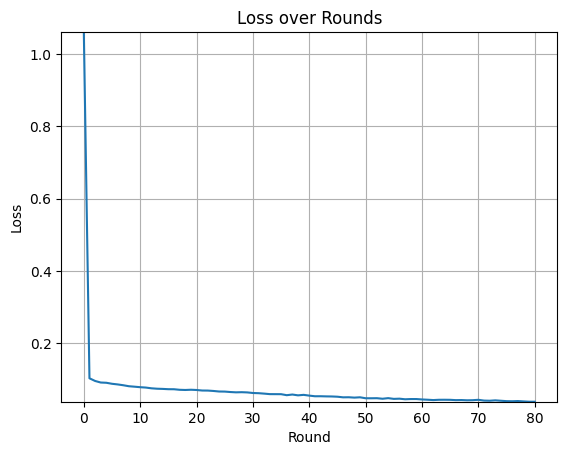

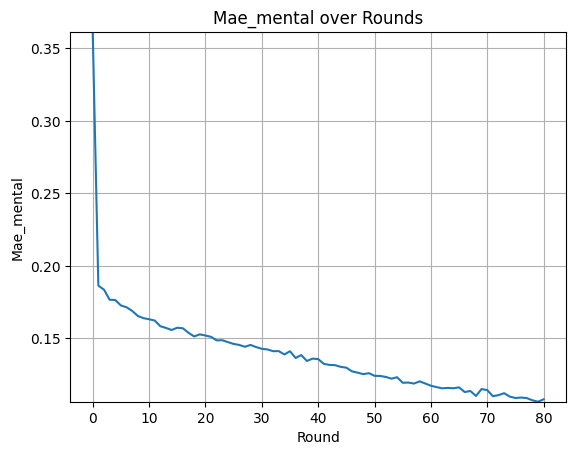

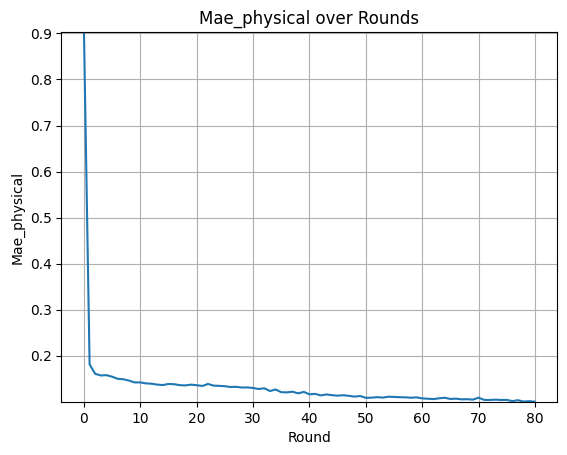

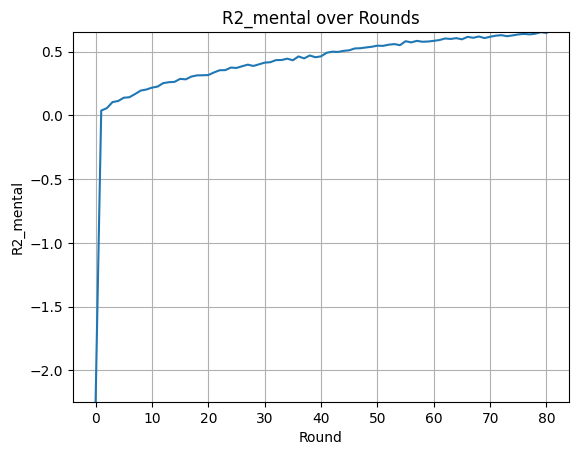

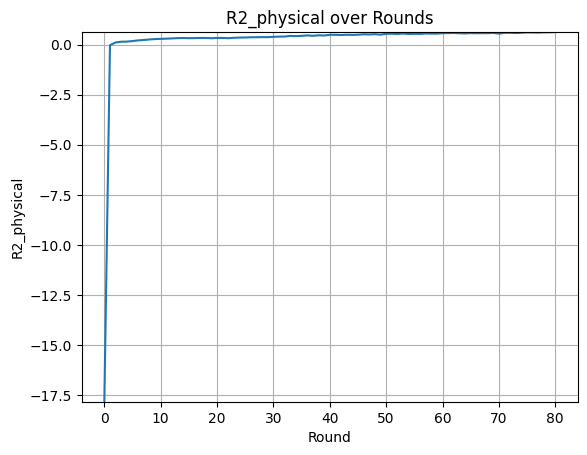

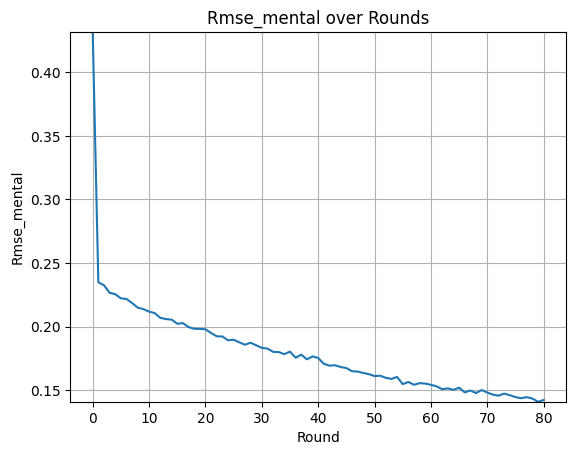

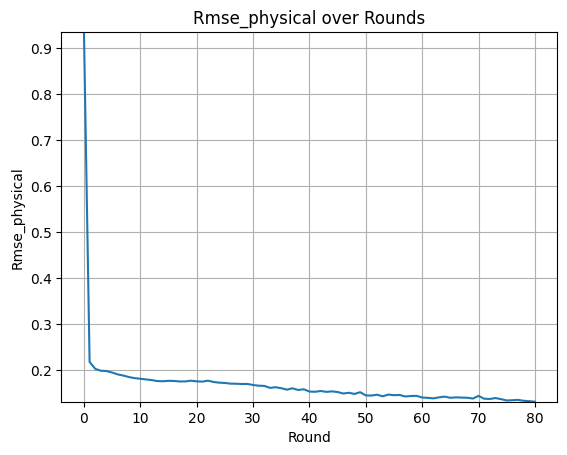

In [ ]:
import matplotlib.pyplot as plt

metrics = {
    "loss": [
        (0, 1.0613963703314464),
        (1, 0.10250543678800265),
        (2, 0.09507488666309251),
        (3, 0.0907610518236955),
        (4, 0.09006504383352068),
        (5, 0.08726497491200765),
        (6, 0.08549260720610619),
        (7, 0.08322089662154515),
        (8, 0.08048030982414882),
        (9, 0.07920111674401495),
        (10, 0.07783209635979599),
        (11, 0.07679925403661197),
        (12, 0.07472877866692013),
        (13, 0.07359279154075517),
        (14, 0.07307553042968114),
        (15, 0.07226916754411326),
        (16, 0.07214840025537544),
        (17, 0.07061858288943768),
        (18, 0.07011524877614445),
        (19, 0.07073796643979019),
        (20, 0.07006925841172536),
        (21, 0.06859022234049109),
        (22, 0.06843825988471508),
        (23, 0.06736267937554254),
        (24, 0.06587449668182267),
        (25, 0.06565556323362721),
        (26, 0.06443432697819339),
        (27, 0.06358824111521244),
        (28, 0.06396517343819141),
        (29, 0.06337411287758085),
        (30, 0.0617360251231326),
        (31, 0.06122007117503219),
        (32, 0.06000924648510085),
        (33, 0.05861902981996536),
        (34, 0.05854240515165859),
        (35, 0.05845110615094503),
        (36, 0.05565583457549413),
        (37, 0.05749313905835152),
        (38, 0.05523046851158142),
        (39, 0.05659765460424953),
        (40, 0.05448635191553169),
        (41, 0.05271449519528283),
        (42, 0.05275884456932545),
        (43, 0.05234759135378732),
        (44, 0.05211725851727857),
        (45, 0.05143402765194575),
        (46, 0.049731132263938584),
        (47, 0.049961032449371286),
        (48, 0.048957853060629636),
        (49, 0.049838438940544925),
        (50, 0.04717844766047266),
        (51, 0.04714041451613108),
        (52, 0.04734912763039271),
        (53, 0.04582054726779461),
        (54, 0.047504631595479116),
        (55, 0.0454332966150509),
        (56, 0.04600660834047529),
        (57, 0.0443695065461927),
        (58, 0.044980690711074404),
        (59, 0.04500668847726451),
        (60, 0.04383919957197375),
        (61, 0.04308606353071001),
        (62, 0.04216068217323886),
        (63, 0.04293991356260247),
        (64, 0.04302425879157252),
        (65, 0.042836877413921885),
        (66, 0.04198419882191552),
        (67, 0.042219142326050334),
        (68, 0.041543002550800644),
        (69, 0.04181652516126633),
        (70, 0.042861605166561074),
        (71, 0.04072972066286537),
        (72, 0.04031750549458795),
        (73, 0.041375934042864375),
        (74, 0.040270210864643254),
        (75, 0.03916136475486888),
        (76, 0.0388899864628911),
        (77, 0.03945698050989045),
        (78, 0.03846193984564808),
        (79, 0.03758278820249769),
        (80, 0.0375766446813941),
    ],
    "mae_mental": [
        (0, 0.36121522100399894),
        (1, 0.18629879585491738),
        (2, 0.18355344900179094),
        (3, 0.17660280468792458),
        (4, 0.17637998764440835),
        (5, 0.1726451153444683),
        (6, 0.1714047907125537),
        (7, 0.16888372115729436),
        (8, 0.16542635500528177),
        (9, 0.16390275873763652),
        (10, 0.16313663636081285),
        (11, 0.162247071952229),
        (12, 0.15832838087631343),
        (13, 0.15713768290386868),
        (14, 0.15572740790630374),
        (15, 0.1572733457108222),
        (16, 0.1568946939880321),
        (17, 0.15376996423802788),
        (18, 0.15126155724832874),
        (19, 0.15271267037090358),
        (20, 0.15191186854673291),
        (21, 0.15098532321438188),
        (22, 0.1485407730373391),
        (23, 0.1486485824708512),
        (24, 0.14733978064912095),
        (25, 0.14610448251582095),
        (26, 0.145402542505037),
        (27, 0.1441515633248997),
        (28, 0.14541470194504294),
        (29, 0.14392558742675898),
        (30, 0.14274671349393436),
        (31, 0.14229778990167352),
        (32, 0.14111667959253715),
        (33, 0.14113987928578084),
        (34, 0.13885410217802452),
        (35, 0.1410624336457536),
        (36, 0.13639854919756222),
        (37, 0.13842693645419268),
        (38, 0.13435140714237276),
        (39, 0.13597291450983542),
        (40, 0.13565620415979118),
        (41, 0.13239065439293035),
        (42, 0.13161702042603754),
        (43, 0.13144562816167774),
        (44, 0.13028794232478175),
        (45, 0.1297371364563197),
        (46, 0.12719851925797082),
        (47, 0.12628419598757396),
        (48, 0.12526902858369032),
        (49, 0.1259318253064682),
        (50, 0.12409383969201153),
        (51, 0.12400535066709181),
        (52, 0.12333993112878623),
        (53, 0.12213070275698452),
        (54, 0.12312889991759828),
        (55, 0.11930102351545674),
        (56, 0.1194634187629569),
        (57, 0.11876355606346026),
        (58, 0.12028937228398125),
        (59, 0.11879257522942932),
        (60, 0.11726398832301038),
        (61, 0.11630651751502293),
        (62, 0.11549683591072363),
        (63, 0.11575790486818759),
        (64, 0.11552086754924232),
        (65, 0.11613492981544865),
        (66, 0.1129142338580979),
        (67, 0.11365510286156567),
        (68, 0.11020983873306818),
        (69, 0.11500449872665798),
        (70, 0.11420972179613717),
        (71, 0.11004448732921498),
        (72, 0.11079329089542825),
        (73, 0.1121129381316039),
        (74, 0.10976140488489512),
        (75, 0.10881219936959657),
        (76, 0.10911606678133685),
        (77, 0.10877035655022342),
        (78, 0.10723849805807287),
        (79, 0.10623438994669879),
        (80, 0.10789518566639184),
    ],
    "mae_physical": [
        (0, 0.9028405683141545),
        (1, 0.1813167000539495),
        (2, 0.1607057054738468),
        (3, 0.15725812687479118),
        (4, 0.15792974632510798),
        (5, 0.15452562854790414),
        (6, 0.14995444207022904),
        (7, 0.14902487032921286),
        (8, 0.14600301739026575),
        (9, 0.14210842659115686),
        (10, 0.1420997444322293),
        (11, 0.14002318762850466),
        (12, 0.1392976708102522),
        (13, 0.13737675462723942),
        (14, 0.13638419178083327),
        (15, 0.13879039182479605),
        (16, 0.13821944275025463),
        (17, 0.13615537910715592),
        (18, 0.13563338561472318),
        (19, 0.13730039767234037),
        (20, 0.13611937356214468),
        (21, 0.1343882876606856),
        (22, 0.13882467724343248),
        (23, 0.1352133555568966),
        (24, 0.13465221593130036),
        (25, 0.13384464473615512),
        (26, 0.13224822057226132),
        (27, 0.13252081180731137),
        (28, 0.1310719944279086),
        (29, 0.1312889077779936),
        (30, 0.130047284565364),
        (31, 0.12787722128093348),
        (32, 0.1294405339120603),
        (33, 0.1234273694105552),
        (34, 0.12679871804814072),
        (35, 0.12086587222557224),
        (36, 0.12050722606466911),
        (37, 0.12196431724116841),
        (38, 0.11838673966348912),
        (39, 0.1215606711652949),
        (40, 0.11628116493225626),
        (41, 0.11731085142596288),
        (42, 0.11393205419592295),
        (43, 0.11598080886422214),
        (44, 0.11443775919668958),
        (45, 0.11332487626371125),
        (46, 0.1143351995108768),
        (47, 0.11300943187167141),
        (48, 0.11130191436935719),
        (49, 0.11266900892270372),
        (50, 0.10863025513220023),
        (51, 0.1089785278193547),
        (52, 0.11012553238369366),
        (53, 0.10917690337193034),
        (54, 0.11103594731473436),
        (55, 0.11061218136208172),
        (56, 0.11005864916897729),
        (57, 0.10975756957558981),
        (58, 0.10887733284146228),
        (59, 0.10969554881585088),
        (60, 0.10752775747632833),
        (61, 0.10672384859492065),
        (62, 0.10596817057474074),
        (63, 0.10757374170348577),
        (64, 0.10885315140418655),
        (65, 0.10620177503846956),
        (66, 0.10689603825634782),
        (67, 0.10536190069524955),
        (68, 0.10565764875752283),
        (69, 0.10474080364847331),
        (70, 0.10899942986178376),
        (71, 0.10418358796560173),
        (72, 0.10395968451448684),
        (73, 0.10468205067507447),
        (74, 0.1039942583954292),
        (75, 0.10417815876120688),
        (76, 0.10160560451170549),
        (77, 0.10345077503419725),
        (78, 0.10055434444575762),
        (79, 0.10143614455013938),
        (80, 0.10020804050186953),
    ],
    "r2_mental": [
        (0, -2.245674237087728),
        (1, 0.03772868505877158),
        (2, 0.05686896456112167),
        (3, 0.10418248305331979),
        (4, 0.11297141427753488),
        (5, 0.13845284384950662),
        (6, 0.14242521280706522),
        (7, 0.16739076109758966),
        (8, 0.1944698358683905),
        (9, 0.202789058683581),
        (10, 0.21745540353429482),
        (11, 0.22581838112822983),
        (12, 0.2530614844765854),
        (13, 0.26018250596443426),
        (14, 0.26291295208686016),
        (15, 0.2862750363591757),
        (16, 0.282651047781718),
        (17, 0.30463703632640604),
        (18, 0.31370210482604843),
        (19, 0.3145652170252293),
        (20, 0.31630680906571673),
        (21, 0.3367038023323746),
        (22, 0.35397273415225783),
        (23, 0.354944122448274),
        (24, 0.37497101292860935),
        (25, 0.37196495419924447),
        (26, 0.38541209927984676),
        (27, 0.39788125472372615),
        (28, 0.38773428340537275),
        (29, 0.40049975027093987),
        (30, 0.413737703876891),
        (31, 0.4170705653752692),
        (32, 0.43350834609156585),
        (33, 0.4342997310329709),
        (34, 0.444798507724944),
        (35, 0.4323718745825248),
        (36, 0.46234422104222284),
        (37, 0.4470790737923327),
        (38, 0.4698576225247756),
        (39, 0.4559008921281802),
        (40, 0.4631391930643919),
        (41, 0.4911006293252276),
        (42, 0.49951971117854244),
        (43, 0.49757315697117654),
        (44, 0.5060670684816366),
        (45, 0.5105701525738274),
        (46, 0.5250147105054268),
        (47, 0.5266819579222211),
        (48, 0.5329347522022261),
        (49, 0.5382747685539505),
        (50, 0.5468697160169698),
        (51, 0.5451335156063477),
        (52, 0.5544564482738416),
        (53, 0.5591552192239936),
        (54, 0.5505445463796199),
        (55, 0.5816272134844624),
        (56, 0.5724120106775609),
        (57, 0.5844052968639444),
        (58, 0.5774507496603503),
        (59, 0.5793552623933403),
        (60, 0.584444318738602),
        (61, 0.5908481314738423),
        (62, 0.6030651990211904),
        (63, 0.599470988418791),
        (64, 0.6057156924357261),
        (65, 0.596557611879091),
        (66, 0.6158468569941322),
        (67, 0.608549280751199),
        (68, 0.6187381791985036),
        (69, 0.6063136867741459),
        (70, 0.6166483855502841),
        (71, 0.6251527163662987),
        (72, 0.6291019861312857),
        (73, 0.620827968622403),
        (74, 0.6273497658428289),
        (75, 0.6349183363719524),
        (76, 0.6392190086532443),
        (77, 0.6351674482993119),
        (78, 0.6406615732445525),
        (79, 0.6530101211015183),
        (80, 0.6465006338248738),
    ],
    "r2_physical": [
        (0, -17.831929957710827),
        (1, -0.02621890821289541),
        (2, 0.11021903487795737),
        (3, 0.14579533568619973),
        (4, 0.15152683404019318),
        (5, 0.17928447283722215),
        (6, 0.21284386393694077),
        (7, 0.23346170821039802),
        (8, 0.2599332566892013),
        (9, 0.278453992417101),
        (10, 0.2885625062151007),
        (11, 0.29988497044322804),
        (12, 0.3106881667214818),
        (13, 0.3269588354044859),
        (14, 0.3306664464678827),
        (15, 0.3228100765474067),
        (16, 0.326382811884971),
        (17, 0.33367139960201087),
        (18, 0.3331762576104841),
        (19, 0.3214604816388341),
        (20, 0.33200436517734655),
        (21, 0.3366349915730661),
        (22, 0.32078086192881916),
        (23, 0.3423621624217683),
        (24, 0.35355003236785454),
        (25, 0.3582021864425732),
        (26, 0.36928640112755906),
        (27, 0.3706690489222194),
        (28, 0.37512911141893324),
        (29, 0.37393635144152004),
        (30, 0.3907740030625486),
        (31, 0.4015927249258052),
        (32, 0.4051701310177289),
        (33, 0.4355049407904298),
        (34, 0.4252133719910619),
        (35, 0.4403001916620152),
        (36, 0.46180509155615934),
        (37, 0.4419888065828179),
        (38, 0.46660663065434294),
        (39, 0.4563427599676618),
        (40, 0.4896249644928382),
        (41, 0.49264680641968694),
        (42, 0.4816103521419828),
        (43, 0.49392736038039187),
        (44, 0.4868970020595478),
        (45, 0.49659738482142857),
        (46, 0.5174879639935255),
        (47, 0.5072926556160471),
        (48, 0.5233240710514149),
        (49, 0.49893814690701155),
        (50, 0.5435853967722326),
        (51, 0.545741729625613),
        (52, 0.533715891678965),
        (53, 0.5558407485255212),
        (54, 0.5322035032082904),
        (55, 0.5408221786709513),
        (56, 0.5374012100447454),
        (57, 0.5582292285271909),
        (58, 0.5520179262128662),
        (59, 0.5497384748573948),
        (60, 0.5715164641921713),
        (61, 0.576501479961308),
        (62, 0.5833368554210125),
        (63, 0.569396987911996),
        (64, 0.5600851631267915),
        (65, 0.575905533967052),
        (66, 0.5696661654351085),
        (67, 0.5729003881419079),
        (68, 0.5749063629804396),
        (69, 0.5854559279604918),
        (70, 0.5502153044507112),
        (71, 0.5873900540017536),
        (72, 0.5909367292653258),
        (73, 0.5789918907710068),
        (74, 0.5930832761371119),
        (75, 0.6100932037151359),
        (76, 0.6069075915263684),
        (77, 0.602214684138702),
        (78, 0.6140898134785406),
        (79, 0.6185580697843558),
        (80, 0.6256874984491281),
    ],
    "rmse_mental": [
        (0, 0.4314580138660326),
        (1, 0.23492803476194865),
        (2, 0.23257985422931138),
        (3, 0.22667094282116815),
        (4, 0.22555625941683222),
        (5, 0.22229290553135708),
        (6, 0.22177984618285917),
        (7, 0.21852779752323226),
        (8, 0.21494481816129282),
        (9, 0.21383200152615597),
        (10, 0.21185592979057102),
        (11, 0.2107208472111152),
        (12, 0.20698005733777342),
        (13, 0.20599106080664728),
        (14, 0.2056105835847596),
        (15, 0.20232591791958543),
        (16, 0.20283892955265742),
        (17, 0.19970634053560862),
        (18, 0.19840033872887156),
        (19, 0.19827554188214713),
        (20, 0.19802348673235834),
        (21, 0.19504724917804322),
        (22, 0.19249147474334713),
        (23, 0.19234670197811407),
        (24, 0.18933728941719669),
        (25, 0.18979204937689573),
        (26, 0.18774919296744644),
        (27, 0.18583484501254502),
        (28, 0.18739415765533432),
        (29, 0.18543032521333128),
        (30, 0.18337159311889933),
        (31, 0.18284962266811894),
        (32, 0.18025313787446998),
        (33, 0.18012718767473282),
        (34, 0.17844787810333304),
        (35, 0.18043385537975054),
        (36, 0.17560554889306496),
        (37, 0.17808100143333525),
        (38, 0.17437424350856057),
        (39, 0.17665465368939476),
        (40, 0.1754756766353165),
        (41, 0.17084490542683547),
        (42, 0.16942580767410406),
        (43, 0.16975496795559525),
        (44, 0.16831393251232774),
        (45, 0.16754493419298805),
        (46, 0.16505403872257807),
        (47, 0.16476410571488379),
        (48, 0.16367217478760726),
        (49, 0.16273384266967764),
        (50, 0.16121209431541972),
        (51, 0.16152064675153366),
        (52, 0.15985681548107128),
        (53, 0.15901164394332604),
        (54, 0.160557058509067),
        (55, 0.1549058394770989),
        (56, 0.15660254824520628),
        (57, 0.1543906791668007),
        (58, 0.15567710385679553),
        (59, 0.15532587395291356),
        (60, 0.15438343081268208),
        (61, 0.15318926952098005),
        (62, 0.1508848600339618),
        (63, 0.15156644532468974),
        (64, 0.1503802567959209),
        (65, 0.15211668019512503),
        (66, 0.14843566798454888),
        (67, 0.1498389163452717),
        (68, 0.1478760136524008),
        (69, 0.15026617583546228),
        (70, 0.14828073296234068),
        (71, 0.14662676733647373),
        (72, 0.14585231599018464),
        (73, 0.14747018445057775),
        (74, 0.1461964324978528),
        (75, 0.1447041832334523),
        (76, 0.14384934860413343),
        (77, 0.14465480566550756),
        (78, 0.14356147337089623),
        (79, 0.14107318759883938),
        (80, 0.14239029688798874),
    ],
    "rmse_physical": [
        (0, 0.9352344424833551),
        (1, 0.21831977925656976),
        (2, 0.20328935257942496),
        (3, 0.19918381519270692),
        (4, 0.19851445385171815),
        (5, 0.1952402712497622),
        (6, 0.19120688220351745),
        (7, 0.18868614198295217),
        (8, 0.1853994842480781),
        (9, 0.18306490366057376),
        (10, 0.18177805494284946),
        (11, 0.1803257627309605),
        (12, 0.17892908637020644),
        (13, 0.1768047347656041),
        (14, 0.17631707628522644),
        (15, 0.17734882725768186),
        (16, 0.1768803779130713),
        (17, 0.175920845926915),
        (18, 0.17598619628265777),
        (19, 0.17752546156142096),
        (20, 0.17614076963296327),
        (21, 0.17552919336829517),
        (22, 0.17761434334656032),
        (23, 0.17476983398789833),
        (24, 0.1732768468455681),
        (25, 0.17265223074369881),
        (26, 0.17115483606851056),
        (27, 0.17096713067141647),
        (28, 0.170360232269874),
        (29, 0.1705227474357425),
        (30, 0.16821405922488783),
        (31, 0.16671378427700187),
        (32, 0.1662147120208619),
        (33, 0.16192098979087383),
        (34, 0.16339035087346215),
        (35, 0.16123178291566667),
        (36, 0.15810400442882735),
        (37, 0.16098838096018603),
        (38, 0.15739715703347737),
        (39, 0.15890430581259757),
        (40, 0.1539635048757073),
        (41, 0.1535070326158485),
        (42, 0.15516766952181665),
        (43, 0.15331318517823594),
        (44, 0.15437442516727426),
        (45, 0.15290821237581395),
        (46, 0.14970184502663228),
        (47, 0.1512751510949091),
        (48, 0.1487937496202022),
        (49, 0.15255229568128698),
        (50, 0.145597139665182),
        (51, 0.14525279529771876),
        (52, 0.1471629159439368),
        (53, 0.14362909818762953),
        (54, 0.14740138355581628),
        (55, 0.14603721055743532),
        (56, 0.14658020461451626),
        (57, 0.14324239266559177),
        (58, 0.1442458726168208),
        (59, 0.1446123875653003),
        (60, 0.14107178024898195),
        (61, 0.1402487586162255),
        (62, 0.13911232880670535),
        (63, 0.14142025274912204),
        (64, 0.14294118632320665),
        (65, 0.14034740276606736),
        (66, 0.1413760436943126),
        (67, 0.1408437778923587),
        (68, 0.1405126354734183),
        (69, 0.1387581279531522),
        (70, 0.14453579459895358),
        (71, 0.13843404964955036),
        (72, 0.1378377961356686),
        (73, 0.13983577957387788),
        (74, 0.13747567066246283),
        (75, 0.13457161982650034),
        (76, 0.13512023930380254),
        (77, 0.1359244082585228),
        (78, 0.13388015256264338),
        (79, 0.13310283111738405),
        (80, 0.13185306919809078),
    ],
}

for metric_name, values in metrics.items():
    rounds = [r for r, v in values]
    metric_values = [v for r, v in values]

    plt.figure()
    plt.plot(rounds, metric_values, linestyle='-')
    plt.title(f"{metric_name.capitalize()} over Rounds")
    plt.xlabel("Round")
    plt.ylabel(metric_name.capitalize())
    plt.grid(True)

    # Set y-axis limits to zoom in
    min_val = min(metric_values)
    max_val = max(metric_values)
    padding = (max_val - min_val) * 0.000000000001  # 10% padding
    plt.ylim(min_val - padding, max_val + padding)

    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

afda_fl_metrics = {
    "loss": [
        (0, 1.0613963703314464),
        (1, 0.10250543678800265),
        (2, 0.09507488666309251),
        (3, 0.0907610518236955),
        (4, 0.09006504383352068),
        (5, 0.08726497491200765),
        (6, 0.08549260720610619),
        (7, 0.08322089662154515),
        (8, 0.08048030982414882),
        (9, 0.07920111674401495),
        (10, 0.07783209635979599),
        (11, 0.07679925403661197),
        (12, 0.07472877866692013),
        (13, 0.07359279154075517),
        (14, 0.07307553042968114),
        (15, 0.07226916754411326),
        (16, 0.07214840025537544),
        (17, 0.07061858288943768),
        (18, 0.07011524877614445),
        (19, 0.07073796643979019),
        (20, 0.07006925841172536),
        (21, 0.06859022234049109),
        (22, 0.06843825988471508),
        (23, 0.06736267937554254),
        (24, 0.06587449668182267),
        (25, 0.06565556323362721),
        (26, 0.06443432697819339),
        (27, 0.06358824111521244),
        (28, 0.06396517343819141),
        (29, 0.06337411287758085),
        (30, 0.0617360251231326),
        (31, 0.06122007117503219),
        (32, 0.06000924648510085),
        (33, 0.05861902981996536),
        (34, 0.05854240515165859),
        (35, 0.05845110615094503),
        (36, 0.05565583457549413),
        (37, 0.05749313905835152),
        (38, 0.05523046851158142),
        (39, 0.05659765460424953),
        (40, 0.05448635191553169),
        (41, 0.05271449519528283),
        (42, 0.05275884456932545),
        (43, 0.05234759135378732),
        (44, 0.05211725851727857),
        (45, 0.05143402765194575),
        (46, 0.049731132263938584),
        (47, 0.049961032449371286),
        (48, 0.048957853060629636),
        (49, 0.049838438940544925),
        (50, 0.04717844766047266),
        (51, 0.04714041451613108),
        (52, 0.04734912763039271),
        (53, 0.04582054726779461),
        (54, 0.047504631595479116),
        (55, 0.0454332966150509),
        (56, 0.04600660834047529),
        (57, 0.0443695065461927),
        (58, 0.044980690711074404),
        (59, 0.04500668847726451),
        (60, 0.04383919957197375),
        (61, 0.04308606353071001),
        (62, 0.04216068217323886),
        (63, 0.04293991356260247),
        (64, 0.04302425879157252),
        (65, 0.042836877413921885),
        (66, 0.04198419882191552),
        (67, 0.042219142326050334),
        (68, 0.041543002550800644),
        (69, 0.04181652516126633),
        (70, 0.042861605166561074),
        (71, 0.04072972066286537),
        (72, 0.04031750549458795),
        (73, 0.041375934042864375),
        (74, 0.040270210864643254),
        (75, 0.03916136475486888),
        (76, 0.0388899864628911),
        (77, 0.03945698050989045),
        (78, 0.03846193984564808),
        (79, 0.03758278820249769),
        (80, 0.0375766446813941),
    ],
    "mae_mental": [
        (0, 0.36121522100399894),
        (1, 0.18629879585491738),
        (2, 0.18355344900179094),
        (3, 0.17660280468792458),
        (4, 0.17637998764440835),
        (5, 0.1726451153444683),
        (6, 0.1714047907125537),
        (7, 0.16888372115729436),
        (8, 0.16542635500528177),
        (9, 0.16390275873763652),
        (10, 0.16313663636081285),
        (11, 0.162247071952229),
        (12, 0.15832838087631343),
        (13, 0.15713768290386868),
        (14, 0.15572740790630374),
        (15, 0.1572733457108222),
        (16, 0.1568946939880321),
        (17, 0.15376996423802788),
        (18, 0.15126155724832874),
        (19, 0.15271267037090358),
        (20, 0.15191186854673291),
        (21, 0.15098532321438188),
        (22, 0.1485407730373391),
        (23, 0.1486485824708512),
        (24, 0.14733978064912095),
        (25, 0.14610448251582095),
        (26, 0.145402542505037),
        (27, 0.1441515633248997),
        (28, 0.14541470194504294),
        (29, 0.14392558742675898),
        (30, 0.14274671349393436),
        (31, 0.14229778990167352),
        (32, 0.14111667959253715),
        (33, 0.14113987928578084),
        (34, 0.13885410217802452),
        (35, 0.1410624336457536),
        (36, 0.13639854919756222),
        (37, 0.13842693645419268),
        (38, 0.13435140714237276),
        (39, 0.13597291450983542),
        (40, 0.13565620415979118),
        (41, 0.13239065439293035),
        (42, 0.13161702042603754),
        (43, 0.13144562816167774),
        (44, 0.13028794232478175),
        (45, 0.1297371364563197),
        (46, 0.12719851925797082),
        (47, 0.12628419598757396),
        (48, 0.12526902858369032),
        (49, 0.1259318253064682),
        (50, 0.12409383969201153),
        (51, 0.12400535066709181),
        (52, 0.12333993112878623),
        (53, 0.12213070275698452),
        (54, 0.12312889991759828),
        (55, 0.11930102351545674),
        (56, 0.1194634187629569),
        (57, 0.11876355606346026),
        (58, 0.12028937228398125),
        (59, 0.11879257522942932),
        (60, 0.11726398832301038),
        (61, 0.11630651751502293),
        (62, 0.11549683591072363),
        (63, 0.11575790486818759),
        (64, 0.11552086754924232),
        (65, 0.11613492981544865),
        (66, 0.1129142338580979),
        (67, 0.11365510286156567),
        (68, 0.11020983873306818),
        (69, 0.11500449872665798),
        (70, 0.11420972179613717),
        (71, 0.11004448732921498),
        (72, 0.11079329089542825),
        (73, 0.1121129381316039),
        (74, 0.10976140488489512),
        (75, 0.10881219936959657),
        (76, 0.10911606678133685),
        (77, 0.10877035655022342),
        (78, 0.10723849805807287),
        (79, 0.10623438994669879),
        (80, 0.10789518566639184),
    ],
    "mae_physical": [
        (0, 0.9028405683141545),
        (1, 0.1813167000539495),
        (2, 0.1607057054738468),
        (3, 0.15725812687479118),
        (4, 0.15792974632510798),
        (5, 0.15452562854790414),
        (6, 0.14995444207022904),
        (7, 0.14902487032921286),
        (8, 0.14600301739026575),
        (9, 0.14210842659115686),
        (10, 0.1420997444322293),
        (11, 0.14002318762850466),
        (12, 0.1392976708102522),
        (13, 0.13737675462723942),
        (14, 0.13638419178083327),
        (15, 0.13879039182479605),
        (16, 0.13821944275025463),
        (17, 0.13615537910715592),
        (18, 0.13563338561472318),
        (19, 0.13730039767234037),
        (20, 0.13611937356214468),
        (21, 0.1343882876606856),
        (22, 0.13882467724343248),
        (23, 0.1352133555568966),
        (24, 0.13465221593130036),
        (25, 0.13384464473615512),
        (26, 0.13224822057226132),
        (27, 0.13252081180731137),
        (28, 0.1310719944279086),
        (29, 0.1312889077779936),
        (30, 0.130047284565364),
        (31, 0.12787722128093348),
        (32, 0.1294405339120603),
        (33, 0.1234273694105552),
        (34, 0.12679871804814072),
        (35, 0.12086587222557224),
        (36, 0.12050722606466911),
        (37, 0.12196431724116841),
        (38, 0.11838673966348912),
        (39, 0.1215606711652949),
        (40, 0.11628116493225626),
        (41, 0.11731085142596288),
        (42, 0.11393205419592295),
        (43, 0.11598080886422214),
        (44, 0.11443775919668958),
        (45, 0.11332487626371125),
        (46, 0.1143351995108768),
        (47, 0.11300943187167141),
        (48, 0.11130191436935719),
        (49, 0.11266900892270372),
        (50, 0.10863025513220023),
        (51, 0.1089785278193547),
        (52, 0.11012553238369366),
        (53, 0.10917690337193034),
        (54, 0.11103594731473436),
        (55, 0.11061218136208172),
        (56, 0.11005864916897729),
        (57, 0.10975756957558981),
        (58, 0.10887733284146228),
        (59, 0.10969554881585088),
        (60, 0.10752775747632833),
        (61, 0.10672384859492065),
        (62, 0.10596817057474074),
        (63, 0.10757374170348577),
        (64, 0.10885315140418655),
        (65, 0.10620177503846956),
        (66, 0.10689603825634782),
        (67, 0.10536190069524955),
        (68, 0.10565764875752283),
        (69, 0.10474080364847331),
        (70, 0.10899942986178376),
        (71, 0.10418358796560173),
        (72, 0.10395968451448684),
        (73, 0.10468205067507447),
        (74, 0.1039942583954292),
        (75, 0.10417815876120688),
        (76, 0.10160560451170549),
        (77, 0.10345077503419725),
        (78, 0.10055434444575762),
        (79, 0.10143614455013938),
        (80, 0.10020804050186953),
    ],
    "r2_mental": [
        (0, -2.245674237087728),
        (1, 0.03772868505877158),
        (2, 0.05686896456112167),
        (3, 0.10418248305331979),
        (4, 0.11297141427753488),
        (5, 0.13845284384950662),
        (6, 0.14242521280706522),
        (7, 0.16739076109758966),
        (8, 0.1944698358683905),
        (9, 0.202789058683581),
        (10, 0.21745540353429482),
        (11, 0.22581838112822983),
        (12, 0.2530614844765854),
        (13, 0.26018250596443426),
        (14, 0.26291295208686016),
        (15, 0.2862750363591757),
        (16, 0.282651047781718),
        (17, 0.30463703632640604),
        (18, 0.31370210482604843),
        (19, 0.3145652170252293),
        (20, 0.31630680906571673),
        (21, 0.3367038023323746),
        (22, 0.35397273415225783),
        (23, 0.354944122448274),
        (24, 0.37497101292860935),
        (25, 0.37196495419924447),
        (26, 0.38541209927984676),
        (27, 0.39788125472372615),
        (28, 0.38773428340537275),
        (29, 0.40049975027093987),
        (30, 0.413737703876891),
        (31, 0.4170705653752692),
        (32, 0.43350834609156585),
        (33, 0.4342997310329709),
        (34, 0.444798507724944),
        (35, 0.4323718745825248),
        (36, 0.46234422104222284),
        (37, 0.4470790737923327),
        (38, 0.4698576225247756),
        (39, 0.4559008921281802),
        (40, 0.4631391930643919),
        (41, 0.4911006293252276),
        (42, 0.49951971117854244),
        (43, 0.49757315697117654),
        (44, 0.5060670684816366),
        (45, 0.5105701525738274),
        (46, 0.5250147105054268),
        (47, 0.5266819579222211),
        (48, 0.5329347522022261),
        (49, 0.5382747685539505),
        (50, 0.5468697160169698),
        (51, 0.5451335156063477),
        (52, 0.5544564482738416),
        (53, 0.5591552192239936),
        (54, 0.5505445463796199),
        (55, 0.5816272134844624),
        (56, 0.5724120106775609),
        (57, 0.5844052968639444),
        (58, 0.5774507496603503),
        (59, 0.5793552623933403),
        (60, 0.584444318738602),
        (61, 0.5908481314738423),
        (62, 0.6030651990211904),
        (63, 0.599470988418791),
        (64, 0.6057156924357261),
        (65, 0.596557611879091),
        (66, 0.6158468569941322),
        (67, 0.608549280751199),
        (68, 0.6187381791985036),
        (69, 0.6063136867741459),
        (70, 0.6166483855502841),
        (71, 0.6251527163662987),
        (72, 0.6291019861312857),
        (73, 0.620827968622403),
        (74, 0.6273497658428289),
        (75, 0.6349183363719524),
        (76, 0.6392190086532443),
        (77, 0.6351674482993119),
        (78, 0.6406615732445525),
        (79, 0.6530101211015183),
        (80, 0.6465006338248738),
    ],
    "r2_physical": [
        (0, -17.831929957710827),
        (1, -0.02621890821289541),
        (2, 0.11021903487795737),
        (3, 0.14579533568619973),
        (4, 0.15152683404019318),
        (5, 0.17928447283722215),
        (6, 0.21284386393694077),
        (7, 0.23346170821039802),
        (8, 0.2599332566892013),
        (9, 0.278453992417101),
        (10, 0.2885625062151007),
        (11, 0.29988497044322804),
        (12, 0.3106881667214818),
        (13, 0.3269588354044859),
        (14, 0.3306664464678827),
        (15, 0.3228100765474067),
        (16, 0.326382811884971),
        (17, 0.33367139960201087),
        (18, 0.3331762576104841),
        (19, 0.3214604816388341),
        (20, 0.33200436517734655),
        (21, 0.3366349915730661),
        (22, 0.32078086192881916),
        (23, 0.3423621624217683),
        (24, 0.35355003236785454),
        (25, 0.3582021864425732),
        (26, 0.36928640112755906),
        (27, 0.3706690489222194),
        (28, 0.37512911141893324),
        (29, 0.37393635144152004),
        (30, 0.3907740030625486),
        (31, 0.4015927249258052),
        (32, 0.4051701310177289),
        (33, 0.4355049407904298),
        (34, 0.4252133719910619),
        (35, 0.4403001916620152),
        (36, 0.46180509155615934),
        (37, 0.4419888065828179),
        (38, 0.46660663065434294),
        (39, 0.4563427599676618),
        (40, 0.4896249644928382),
        (41, 0.49264680641968694),
        (42, 0.4816103521419828),
        (43, 0.49392736038039187),
        (44, 0.4868970020595478),
        (45, 0.49659738482142857),
        (46, 0.5174879639935255),
        (47, 0.5072926556160471),
        (48, 0.5233240710514149),
        (49, 0.49893814690701155),
        (50, 0.5435853967722326),
        (51, 0.545741729625613),
        (52, 0.533715891678965),
        (53, 0.5558407485255212),
        (54, 0.5322035032082904),
        (55, 0.5408221786709513),
        (56, 0.5374012100447454),
        (57, 0.5582292285271909),
        (58, 0.5520179262128662),
        (59, 0.5497384748573948),
        (60, 0.5715164641921713),
        (61, 0.576501479961308),
        (62, 0.5833368554210125),
        (63, 0.569396987911996),
        (64, 0.5600851631267915),
        (65, 0.575905533967052),
        (66, 0.5696661654351085),
        (67, 0.5729003881419079),
        (68, 0.5749063629804396),
        (69, 0.5854559279604918),
        (70, 0.5502153044507112),
        (71, 0.5873900540017536),
        (72, 0.5909367292653258),
        (73, 0.5789918907710068),
        (74, 0.5930832761371119),
        (75, 0.6100932037151359),
        (76, 0.6069075915263684),
        (77, 0.602214684138702),
        (78, 0.6140898134785406),
        (79, 0.6185580697843558),
        (80, 0.6256874984491281),
    ],
    "rmse_mental": [
        (0, 0.4314580138660326),
        (1, 0.23492803476194865),
        (2, 0.23257985422931138),
        (3, 0.22667094282116815),
        (4, 0.22555625941683222),
        (5, 0.22229290553135708),
        (6, 0.22177984618285917),
        (7, 0.21852779752323226),
        (8, 0.21494481816129282),
        (9, 0.21383200152615597),
        (10, 0.21185592979057102),
        (11, 0.2107208472111152),
        (12, 0.20698005733777342),
        (13, 0.20599106080664728),
        (14, 0.2056105835847596),
        (15, 0.20232591791958543),
        (16, 0.20283892955265742),
        (17, 0.19970634053560862),
        (18, 0.19840033872887156),
        (19, 0.19827554188214713),
        (20, 0.19802348673235834),
        (21, 0.19504724917804322),
        (22, 0.19249147474334713),
        (23, 0.19234670197811407),
        (24, 0.18933728941719669),
        (25, 0.18979204937689573),
        (26, 0.18774919296744644),
        (27, 0.18583484501254502),
        (28, 0.18739415765533432),
        (29, 0.18543032521333128),
        (30, 0.18337159311889933),
        (31, 0.18284962266811894),
        (32, 0.18025313787446998),
        (33, 0.18012718767473282),
        (34, 0.17844787810333304),
        (35, 0.18043385537975054),
        (36, 0.17560554889306496),
        (37, 0.17808100143333525),
        (38, 0.17437424350856057),
        (39, 0.17665465368939476),
        (40, 0.1754756766353165),
        (41, 0.17084490542683547),
        (42, 0.16942580767410406),
        (43, 0.16975496795559525),
        (44, 0.16831393251232774),
        (45, 0.16754493419298805),
        (46, 0.16505403872257807),
        (47, 0.16476410571488379),
        (48, 0.16367217478760726),
        (49, 0.16273384266967764),
        (50, 0.16121209431541972),
        (51, 0.16152064675153366),
        (52, 0.15985681548107128),
        (53, 0.15901164394332604),
        (54, 0.160557058509067),
        (55, 0.1549058394770989),
        (56, 0.15660254824520628),
        (57, 0.1543906791668007),
        (58, 0.15567710385679553),
        (59, 0.15532587395291356),
        (60, 0.15438343081268208),
        (61, 0.15318926952098005),
        (62, 0.1508848600339618),
        (63, 0.15156644532468974),
        (64, 0.1503802567959209),
        (65, 0.15211668019512503),
        (66, 0.14843566798454888),
        (67, 0.1498389163452717),
        (68, 0.1478760136524008),
        (69, 0.15026617583546228),
        (70, 0.14828073296234068),
        (71, 0.14662676733647373),
        (72, 0.14585231599018464),
        (73, 0.14747018445057775),
        (74, 0.1461964324978528),
        (75, 0.1447041832334523),
        (76, 0.14384934860413343),
        (77, 0.14465480566550756),
        (78, 0.14356147337089623),
        (79, 0.14107318759883938),
        (80, 0.14239029688798874),
    ],
    "rmse_physical": [
        (0, 0.9352344424833551),
        (1, 0.21831977925656976),
        (2, 0.20328935257942496),
        (3, 0.19918381519270692),
        (4, 0.19851445385171815),
        (5, 0.1952402712497622),
        (6, 0.19120688220351745),
        (7, 0.18868614198295217),
        (8, 0.1853994842480781),
        (9, 0.18306490366057376),
        (10, 0.18177805494284946),
        (11, 0.1803257627309605),
        (12, 0.17892908637020644),
        (13, 0.1768047347656041),
        (14, 0.17631707628522644),
        (15, 0.17734882725768186),
        (16, 0.1768803779130713),
        (17, 0.175920845926915),
        (18, 0.17598619628265777),
        (19, 0.17752546156142096),
        (20, 0.17614076963296327),
        (21, 0.17552919336829517),
        (22, 0.17761434334656032),
        (23, 0.17476983398789833),
        (24, 0.1732768468455681),
        (25, 0.17265223074369881),
        (26, 0.17115483606851056),
        (27, 0.17096713067141647),
        (28, 0.170360232269874),
        (29, 0.1705227474357425),
        (30, 0.16821405922488783),
        (31, 0.16671378427700187),
        (32, 0.1662147120208619),
        (33, 0.16192098979087383),
        (34, 0.16339035087346215),
        (35, 0.16123178291566667),
        (36, 0.15810400442882735),
        (37, 0.16098838096018603),
        (38, 0.15739715703347737),
        (39, 0.15890430581259757),
        (40, 0.1539635048757073),
        (41, 0.1535070326158485),
        (42, 0.15516766952181665),
        (43, 0.15331318517823594),
        (44, 0.15437442516727426),
        (45, 0.15290821237581395),
        (46, 0.14970184502663228),
        (47, 0.1512751510949091),
        (48, 0.1487937496202022),
        (49, 0.15255229568128698),
        (50, 0.145597139665182),
        (51, 0.14525279529771876),
        (52, 0.1471629159439368),
        (53, 0.14362909818762953),
        (54, 0.14740138355581628),
        (55, 0.14603721055743532),
        (56, 0.14658020461451626),
        (57, 0.14324239266559177),
        (58, 0.1442458726168208),
        (59, 0.1446123875653003),
        (60, 0.14107178024898195),
        (61, 0.1402487586162255),
        (62, 0.13911232880670535),
        (63, 0.14142025274912204),
        (64, 0.14294118632320665),
        (65, 0.14034740276606736),
        (66, 0.1413760436943126),
        (67, 0.1408437778923587),
        (68, 0.1405126354734183),
        (69, 0.1387581279531522),
        (70, 0.14453579459895358),
        (71, 0.13843404964955036),
        (72, 0.1378377961356686),
        (73, 0.13983577957387788),
        (74, 0.13747567066246283),
        (75, 0.13457161982650034),
        (76, 0.13512023930380254),
        (77, 0.1359244082585228),
        (78, 0.13388015256264338),
        (79, 0.13310283111738405),
        (80, 0.13185306919809078),
    ],
}

fl_base_metrics = {
    "loss": [
        (0, 1.5586),
        (1, 0.1064),
        (2, 0.0936),
        (3, 0.0932),
        (4, 0.0931),
        (5, 0.0928),
        (6, 0.0925),
        (7, 0.093),
        (8, 0.0926),
        (9, 0.0927),
        (10, 0.0926),
        (11, 0.0926),
        (12, 0.0927),
        (13, 0.0918),
        (14, 0.092),
        (15, 0.0916),
        (16, 0.092),
        (17, 0.0912),
        (18, 0.0913),
        (19, 0.0914),
        (20, 0.0912),
        (21, 0.0907),
        (22, 0.0909),
        (23, 0.0907),
        (24, 0.0904),
        (25, 0.0897),
        (26, 0.0899),
        (27, 0.0895),
        (28, 0.0895),
        (29, 0.0898),
        (30, 0.0891),
        (31, 0.0891),
        (32, 0.0901),
        (33, 0.0888),
        (34, 0.0891),
        (35, 0.0887),
        (36, 0.0885),
        (37, 0.0881),
        (38, 0.0881),
        (39, 0.0881),
        (40, 0.0881),
        (41, 0.0874),
        (42, 0.0874),
        (43, 0.0874),
        (44, 0.0871),
        (45, 0.0869),
        (46, 0.0865),
        (47, 0.0865),
        (48, 0.0861),
        (49, 0.0861),
        (50, 0.0867),
        (51, 0.0855),
        (52, 0.0858),
        (53, 0.0856),
        (54, 0.0852),
        (55, 0.0849),
        (56, 0.0852),
        (57, 0.0847),
        (58, 0.0842),
        (59, 0.0849),
        (60, 0.0841),
        (61, 0.0838),
        (62, 0.0834),
        (63, 0.0831),
        (64, 0.0829),
        (65, 0.0827),
        (66, 0.0826),
        (67, 0.0822),
        (68, 0.0824),
        (69, 0.0823),
        (70, 0.0826),
        (71, 0.0815),
        (72, 0.0813),
        (73, 0.0811),
        (74, 0.081),
        (75, 0.0799),
        (76, 0.0802),
        (77, 0.0795),
        (78, 0.0791),
        (79, 0.0789),
        (80, 0.0791),
    ],
    "mae_mental": [
        (0, 1.0408),
        (1, 0.2032),
        (2, 0.1831),
        (3, 0.1833),
        (4, 0.1831),
        (5, 0.1825),
        (6, 0.1823),
        (7, 0.1832),
        (8, 0.1826),
        (9, 0.1827),
        (10, 0.1825),
        (11, 0.1829),
        (12, 0.1827),
        (13, 0.1812),
        (14, 0.1817),
        (15, 0.1808),
        (16, 0.1816),
        (17, 0.1807),
        (18, 0.1806),
        (19, 0.1808),
        (20, 0.1804),
        (21, 0.1793),
        (22, 0.18),
        (23, 0.1794),
        (24, 0.1793),
        (25, 0.1779),
        (26, 0.1787),
        (27, 0.1779),
        (28, 0.1778),
        (29, 0.1785),
        (30, 0.1772),
        (31, 0.1776),
        (32, 0.1787),
        (33, 0.177),
        (34, 0.1773),
        (35, 0.1766),
        (36, 0.1769),
        (37, 0.176),
        (38, 0.1753),
        (39, 0.1762),
        (40, 0.1758),
        (41, 0.1749),
        (42, 0.175),
        (43, 0.1749),
        (44, 0.1746),
        (45, 0.174),
        (46, 0.174),
        (47, 0.1739),
        (48, 0.1732),
        (49, 0.1734),
        (50, 0.1745),
        (51, 0.1726),
        (52, 0.173),
        (53, 0.1727),
        (54, 0.1728),
        (55, 0.1721),
        (56, 0.1719),
        (57, 0.1721),
        (58, 0.1714),
        (59, 0.1719),
        (60, 0.171),
        (61, 0.1707),
        (62, 0.1699),
        (63, 0.1697),
        (64, 0.1692),
        (65, 0.1695),
        (66, 0.169),
        (67, 0.1685),
        (68, 0.1694),
        (69, 0.1697),
        (70, 0.1699),
        (71, 0.1681),
        (72, 0.168),
        (73, 0.1686),
        (74, 0.1683),
        (75, 0.1672),
        (76, 0.1683),
        (77, 0.1663),
        (78, 0.1667),
        (79, 0.1662),
        (80, 0.1672),
    ],
    "mae_physical": [
        (0, 0.5949),
        (1, 0.1745),
        (2, 0.1627),
        (3, 0.1622),
        (4, 0.1627),
        (5, 0.1626),
        (6, 0.1619),
        (7, 0.1629),
        (8, 0.1631),
        (9, 0.1632),
        (10, 0.163),
        (11, 0.1629),
        (12, 0.1638),
        (13, 0.1624),
        (14, 0.1628),
        (15, 0.1629),
        (16, 0.1628),
        (17, 0.1618),
        (18, 0.1626),
        (19, 0.1632),
        (20, 0.1627),
        (21, 0.1627),
        (22, 0.1621),
        (23, 0.1631),
        (24, 0.1624),
        (25, 0.1614),
        (26, 0.1616),
        (27, 0.1616),
        (28, 0.1619),
        (29, 0.1623),
        (30, 0.1614),
        (31, 0.1617),
        (32, 0.1635),
        (33, 0.1608),
        (34, 0.1623),
        (35, 0.1616),
        (36, 0.1611),
        (37, 0.161),
        (38, 0.1613),
        (39, 0.1604),
        (40, 0.1608),
        (41, 0.1594),
        (42, 0.1586),
        (43, 0.1596),
        (44, 0.1582),
        (45, 0.1595),
        (46, 0.1568),
        (47, 0.1573),
        (48, 0.1575),
        (49, 0.1564),
        (50, 0.158),
        (51, 0.1558),
        (52, 0.1562),
        (53, 0.1563),
        (54, 0.153),
        (55, 0.1545),
        (56, 0.1564),
        (57, 0.1537),
        (58, 0.1522),
        (59, 0.1549),
        (60, 0.153),
        (61, 0.1527),
        (62, 0.1513),
        (63, 0.1515),
        (64, 0.1511),
        (65, 0.1506),
        (66, 0.1502),
        (67, 0.1506),
        (68, 0.1509),
        (69, 0.1501),
        (70, 0.1522),
        (71, 0.1495),
        (72, 0.151),
        (73, 0.1502),
        (74, 0.1504),
        (75, 0.1491),
        (76, 0.1494),
        (77, 0.1492),
        (78, 0.1489),
        (79, 0.1494),
        (80, 0.1492),
    ],
    "r2_mental": [
        (0, -19.2855),
        (1, -0.0809),
        (2, 0.0796),
        (3, 0.0829),
        (4, 0.0848),
        (5, 0.089),
        (6, 0.0905),
        (7, 0.0865),
        (8, 0.0923),
        (9, 0.092),
        (10, 0.0935),
        (11, 0.0918),
        (12, 0.0939),
        (13, 0.102),
        (14, 0.0996),
        (15, 0.1064),
        (16, 0.1011),
        (17, 0.1087),
        (18, 0.111),
        (19, 0.1104),
        (20, 0.1126),
        (21, 0.1203),
        (22, 0.115),
        (23, 0.1213),
        (24, 0.1229),
        (25, 0.1302),
        (26, 0.1274),
        (27, 0.1337),
        (28, 0.1354),
        (29, 0.1302),
        (30, 0.1384),
        (31, 0.1386),
        (32, 0.1304),
        (33, 0.1405),
        (34, 0.1415),
        (35, 0.1446),
        (36, 0.1448),
        (37, 0.1515),
        (38, 0.1531),
        (39, 0.1483),
        (40, 0.1501),
        (41, 0.1558),
        (42, 0.1527),
        (43, 0.1568),
        (44, 0.1576),
        (45, 0.1636),
        (46, 0.1624),
        (47, 0.1644),
        (48, 0.1684),
        (49, 0.168),
        (50, 0.1623),
        (51, 0.1733),
        (52, 0.1733),
        (53, 0.1747),
        (54, 0.1731),
        (55, 0.1816),
        (56, 0.1823),
        (57, 0.1823),
        (58, 0.1861),
        (59, 0.1828),
        (60, 0.1898),
        (61, 0.1933),
        (62, 0.1971),
        (63, 0.2013),
        (64, 0.2038),
        (65, 0.2048),
        (66, 0.2074),
        (67, 0.2112),
        (68, 0.2102),
        (69, 0.2097),
        (70, 0.2106),
        (71, 0.2199),
        (72, 0.2238),
        (73, 0.2236),
        (74, 0.2253),
        (75, 0.2352),
        (76, 0.2308),
        (77, 0.236),
        (78, 0.2436),
        (79, 0.2467),
        (80, 0.2442),
    ],
    "r2_physical": [
        (0, -7.5826),
        (1, 0.0378),
        (2, 0.1113),
        (3, 0.1172),
        (4, 0.1168),
        (5, 0.1173),
        (6, 0.1213),
        (7, 0.1165),
        (8, 0.1169),
        (9, 0.1163),
        (10, 0.1175),
        (11, 0.1186),
        (12, 0.1152),
        (13, 0.1228),
        (14, 0.1214),
        (15, 0.1216),
        (16, 0.1211),
        (17, 0.1276),
        (18, 0.1246),
        (19, 0.1227),
        (20, 0.1251),
        (21, 0.1259),
        (22, 0.129),
        (23, 0.1249),
        (24, 0.1297),
        (25, 0.1352),
        (26, 0.1352),
        (27, 0.1358),
        (28, 0.134),
        (29, 0.1338),
        (30, 0.1379),
        (31, 0.1384),
        (32, 0.1272),
        (33, 0.1434),
        (34, 0.1366),
        (35, 0.1413),
        (36, 0.1447),
        (37, 0.146),
        (38, 0.1445),
        (39, 0.1501),
        (40, 0.1485),
        (41, 0.155),
        (42, 0.1595),
        (43, 0.1553),
        (44, 0.1616),
        (45, 0.1573),
        (46, 0.169),
        (47, 0.1671),
        (48, 0.1692),
        (49, 0.1722),
        (50, 0.165),
        (51, 0.1766),
        (52, 0.1718),
        (53, 0.1742),
        (54, 0.1854),
        (55, 0.1813),
        (56, 0.1729),
        (57, 0.1837),
        (58, 0.1906),
        (59, 0.1794),
        (60, 0.1877),
        (61, 0.1916),
        (62, 0.1951),
        (63, 0.1964),
        (64, 0.197),
        (65, 0.2014),
        (66, 0.1991),
        (67, 0.2034),
        (68, 0.2005),
        (69, 0.2032),
        (70, 0.1965),
        (71, 0.2097),
        (72, 0.2083),
        (73, 0.2134),
        (74, 0.2109),
        (75, 0.2259),
        (76, 0.2233),
        (77, 0.2319),
        (78, 0.2312),
        (79, 0.2299),
        (80, 0.2317),
    ],
    "rmse_mental": [
        (0, 1.0786),
        (1, 0.249),
        (2, 0.2298),
        (3, 0.2293),
        (4, 0.2291),
        (5, 0.2286),
        (6, 0.2284),
        (7, 0.2289),
        (8, 0.2282),
        (9, 0.2282),
        (10, 0.228),
        (11, 0.2282),
        (12, 0.228),
        (13, 0.2269),
        (14, 0.2272),
        (15, 0.2264),
        (16, 0.2271),
        (17, 0.2261),
        (18, 0.2258),
        (19, 0.2259),
        (20, 0.2256),
        (21, 0.2246),
        (22, 0.2253),
        (23, 0.2245),
        (24, 0.2243),
        (25, 0.2234),
        (26, 0.2237),
        (27, 0.2229),
        (28, 0.2227),
        (29, 0.2234),
        (30, 0.2223),
        (31, 0.2223),
        (32, 0.2233),
        (33, 0.222),
        (34, 0.2219),
        (35, 0.2215),
        (36, 0.2215),
        (37, 0.2206),
        (38, 0.2204),
        (39, 0.221),
        (40, 0.2208),
        (41, 0.22),
        (42, 0.2204),
        (43, 0.2199),
        (44, 0.2198),
        (45, 0.219),
        (46, 0.2192),
        (47, 0.2189),
        (48, 0.2184),
        (49, 0.2184),
        (50, 0.2192),
        (51, 0.2178),
        (52, 0.2178),
        (53, 0.2176),
        (54, 0.2178),
        (55, 0.2167),
        (56, 0.2166),
        (57, 0.2166),
        (58, 0.2161),
        (59, 0.2165),
        (60, 0.2156),
        (61, 0.2151),
        (62, 0.2146),
        (63, 0.214),
        (64, 0.2137),
        (65, 0.2136),
        (66, 0.2132),
        (67, 0.2127),
        (68, 0.2128),
        (69, 0.2129),
        (70, 0.2128),
        (71, 0.2115),
        (72, 0.211),
        (73, 0.211),
        (74, 0.2108),
        (75, 0.2094),
        (76, 0.21),
        (77, 0.2093),
        (78, 0.2083),
        (79, 0.2079),
        (80, 0.2082),
    ],
    "rmse_physical": [
        (0, 0.6314),
        (1, 0.2114),
        (2, 0.2032),
        (3, 0.2025),
        (4, 0.2025),
        (5, 0.2025),
        (6, 0.202),
        (7, 0.2026),
        (8, 0.2025),
        (9, 0.2026),
        (10, 0.2025),
        (11, 0.2023),
        (12, 0.2027),
        (13, 0.2018),
        (14, 0.202),
        (15, 0.202),
        (16, 0.202),
        (17, 0.2013),
        (18, 0.2016),
        (19, 0.2019),
        (20, 0.2016),
        (21, 0.2015),
        (22, 0.2011),
        (23, 0.2016),
        (24, 0.201),
        (25, 0.2004),
        (26, 0.2004),
        (27, 0.2003),
        (28, 0.2006),
        (29, 0.2006),
        (30, 0.2001),
        (31, 0.2),
        (32, 0.2013),
        (33, 0.1995),
        (34, 0.2002),
        (35, 0.1997),
        (36, 0.1993),
        (37, 0.1992),
        (38, 0.1993),
        (39, 0.1987),
        (40, 0.1989),
        (41, 0.1981),
        (42, 0.1976),
        (43, 0.1981),
        (44, 0.1973),
        (45, 0.1978),
        (46, 0.1965),
        (47, 0.1967),
        (48, 0.1964),
        (49, 0.1961),
        (50, 0.1969),
        (51, 0.1956),
        (52, 0.1961),
        (53, 0.1958),
        (54, 0.1945),
        (55, 0.195),
        (56, 0.196),
        (57, 0.1947),
        (58, 0.1939),
        (59, 0.1952),
        (60, 0.1942),
        (61, 0.1938),
        (62, 0.1933),
        (63, 0.1932),
        (64, 0.1931),
        (65, 0.1926),
        (66, 0.1929),
        (67, 0.1924),
        (68, 0.1927),
        (69, 0.1924),
        (70, 0.1932),
        (71, 0.1916),
        (72, 0.1918),
        (73, 0.1911),
        (74, 0.1914),
        (75, 0.1896),
        (76, 0.1899),
        (77, 0.1889),
        (78, 0.189),
        (79, 0.1891),
        (80, 0.1889),
    ],
}

central_afda_metrics = {
    "loss": [
        (1, 0.09275792487379578),
        (2, 0.08958548100458251),
        (3, 0.08715692809265521),
        (4, 0.08353727585118678),
        (5, 0.09395988399369849),
        (6, 0.08253197035648757),
        (7, 0.08069728842626016),
        (8, 0.07889847892026107),
        (9, 0.08256119955331087),
        (10, 0.0778791138695346),
        (11, 0.07561102292189996),
        (12, 0.07497648346341318),
        (13, 0.0744324610568583),
        (14, 0.07797231338918209),
        (15, 0.07635424239560962),
        (16, 0.07386838944835795),
        (17, 0.07875407290541464),
        (18, 0.0747803217317495),
        (19, 0.06828989957769711),
        (20, 0.0787742780521512),
        (21, 0.07253309846338299),
        (22, 0.07837981544435024),
        (23, 0.07229192617038886),
        (24, 0.06710880653311808),
        (25, 0.0813256132726868),
        (26, 0.07752968712399404),
        (27, 0.06824867059994075),
        (28, 0.07989386013812488),
        (29, 0.059469761326909065),
        (30, 0.0649177252004544),
        (31, 0.06955024206803904),
        (32, 0.0648846138889591),
        (33, 0.061921693488127656),
        (34, 0.06057696846417255),
        (35, 0.06101308255973789),
        (36, 0.0583037074862255),
        (37, 0.06420731311663985),
        (38, 0.07184983200083177),
        (39, 0.061182497069239616),
        (40, 0.06029342068359256),
        (41, 0.05872302626570066),
        (42, 0.056907097809016705),
        (43, 0.0619382343461944),
        (44, 0.0649305551002423),
        (45, 0.08228451210177606),
        (46, 0.05718792323023081),
        (47, 0.05564143322408199),
        (48, 0.05304607883509663),
        (49, 0.05934268841519952),
        (50, 0.06701675078107251),
        (51, 0.07290107958639662),
        (52, 0.05496645247977641),
        (53, 0.05541576952156094),
        (54, 0.05627732320378224),
        (55, 0.05210737335599131),
        (56, 0.057807179943968855),
        (57, 0.054314216857569084),
        (58, 0.05567033231879274),
        (59, 0.05084485441653265),
        (60, 0.051416256154576935),
        (61, 0.05392808524063892),
        (62, 0.05391231303413709),
        (63, 0.05220173257920477),
        (64, 0.05316899302932951),
        (65, 0.0573838564256827),
        (66, 0.05357502576791578),
        (67, 0.04642921029072669),
        (68, 0.05111063504591584),
        (69, 0.050975381293230586),
        (70, 0.060498764790180654),
        (71, 0.052401195797655314),
        (72, 0.05148957887043556),
        (73, 0.047601369002627),
        (74, 0.06019498614801301),
        (75, 0.047017512584312096),
        (76, 0.04542995492617289),
        (77, 0.07961564076443513),
        (78, 0.0454364652848906),
        (79, 0.051401679404079914),
        (80, 0.04654421755630109),
    ],
    "mae_mental": [
        (1, 0.1720014214515686),
        (2, 0.1656622588634491),
        (3, 0.1641506403684616),
        (4, 0.16562019288539886),
        (5, 0.167373925447464),
        (6, 0.16282755136489868),
        (7, 0.16389964520931244),
        (8, 0.16049443185329437),
        (9, 0.1631644070148468),
        (10, 0.15558253228664398),
        (11, 0.15486446022987366),
        (12, 0.155367910861969),
        (13, 0.1519986093044281),
        (14, 0.16057918965816498),
        (15, 0.1482061892747879),
        (16, 0.14822974801063538),
        (17, 0.166726216673851),
        (18, 0.16201497614383698),
        (19, 0.14618553221225739),
        (20, 0.14927062392234802),
        (21, 0.1538250744342804),
        (22, 0.15289603173732758),
        (23, 0.15480360388755798),
        (24, 0.14571943879127502),
        (25, 0.1654779016971588),
        (26, 0.1590217649936676),
        (27, 0.1514781266450882),
        (28, 0.15432050824165344),
        (29, 0.13264377415180206),
        (30, 0.14170892536640167),
        (31, 0.14655697345733643),
        (32, 0.1410735696554184),
        (33, 0.1348474770784378),
        (34, 0.13743215799331665),
        (35, 0.1383996456861496),
        (36, 0.13306529819965363),
        (37, 0.13242894411087036),
        (38, 0.1445438712835312),
        (39, 0.13156847655773163),
        (40, 0.129697784781456),
        (41, 0.13299620151519775),
        (42, 0.1311289668083191),
        (43, 0.1332653909921646),
        (44, 0.14307497441768646),
        (45, 0.16373559832572937),
        (46, 0.13241145014762878),
        (47, 0.12815481424331665),
        (48, 0.12343839555978775),
        (49, 0.13665646314620972),
        (50, 0.14277435839176178),
        (51, 0.15491287410259247),
        (52, 0.13338683545589447),
        (53, 0.13368725776672363),
        (54, 0.13424964249134064),
        (55, 0.12486913800239563),
        (56, 0.14011913537979126),
        (57, 0.12794023752212524),
        (58, 0.12358685582876205),
        (59, 0.12545832991600037),
        (60, 0.1252240389585495),
        (61, 0.12901826202869415),
        (62, 0.12520188093185425),
        (63, 0.12673893570899963),
        (64, 0.1234639510512352),
        (65, 0.132022887468338),
        (66, 0.12505173683166504),
        (67, 0.11408384889364243),
        (68, 0.12461360543966293),
        (69, 0.12564270198345184),
        (70, 0.13801243901252747),
        (71, 0.12689584493637085),
        (72, 0.12541480362415314),
        (73, 0.11971934884786606),
        (74, 0.13671058416366577),
        (75, 0.11630822718143463),
        (76, 0.11625766009092331),
        (77, 0.15658095479011536),
        (78, 0.11899415403604507),
        (79, 0.12767267227172852),
        (80, 0.11545300483703613),
    ],
    "mae_physical": [
        (1, 0.16389133036136627),
        (2, 0.15474723279476166),
        (3, 0.1583014577627182),
        (4, 0.15116822719573975),
        (5, 0.16855572164058685),
        (6, 0.15171273052692413),
        (7, 0.14891241490840912),
        (8, 0.1473827362060547),
        (9, 0.152724489569664),
        (10, 0.14942216873168945),
        (11, 0.14446553587913513),
        (12, 0.14377935230731964),
        (13, 0.1451837420463562),
        (14, 0.14527128636837006),
        (15, 0.1502743512392044),
        (16, 0.14803579449653625),
        (17, 0.14570839703083038),
        (18, 0.14297182857990265),
        (19, 0.13839270174503326),
        (20, 0.15656745433807373),
        (21, 0.14593860507011414),
        (22, 0.14394283294677734),
        (23, 0.14271233975887299),
        (24, 0.13682647049427032),
        (25, 0.15259695053100586),
        (26, 0.1495181769132614),
        (27, 0.135369211435318),
        (28, 0.1474069356918335),
        (29, 0.13198943436145782),
        (30, 0.13111083209514618),
        (31, 0.14638333022594452),
        (32, 0.13892142474651337),
        (33, 0.1337558627128601),
        (34, 0.12723973393440247),
        (35, 0.12875601649284363),
        (36, 0.12432549893856049),
        (37, 0.13850854337215424),
        (38, 0.1494733989238739),
        (39, 0.1337684541940689),
        (40, 0.13669228553771973),
        (41, 0.1313128024339676),
        (42, 0.12418974190950394),
        (43, 0.13800162076950073),
        (44, 0.13372325897216797),
        (45, 0.14974580705165863),
        (46, 0.12521657347679138),
        (47, 0.12694206833839417),
        (48, 0.12296517193317413),
        (49, 0.12576095759868622),
        (50, 0.14278465509414673),
        (51, 0.1349671334028244),
        (52, 0.12076586484909058),
        (53, 0.12108122557401657),
        (54, 0.12499117851257324),
        (55, 0.12264794111251831),
        (56, 0.12686914205551147),
        (57, 0.12512171268463135),
        (58, 0.13392044603824615),
        (59, 0.11892278492450714),
        (60, 0.11930187046527863),
        (61, 0.121980682015419),
        (62, 0.1250343769788742),
        (63, 0.12338148802518845),
        (64, 0.12352560460567474),
        (65, 0.12870392203330994),
        (66, 0.12642377614974976),
        (67, 0.11562631279230118),
        (68, 0.12324631959199905),
        (69, 0.12153441458940506),
        (70, 0.13223788142204285),
        (71, 0.120128333568573),
        (72, 0.118354432284832),
        (73, 0.11635619401931763),
        (74, 0.12259619683027267),
        (75, 0.11762890964746475),
        (76, 0.11304382234811783),
        (77, 0.13088996708393097),
        (78, 0.11158418655395508),
        (79, 0.118449367582798),
        (80, 0.11975672841072083),
    ],
    "r2_mental": [
        (1, 0.0245363712310791),
        (2, 0.05492198467254639),
        (3, 0.08702331781387329),
        (4, 0.10696333646774292),
        (5, 0.07966309785842896),
        (6, 0.1441134810447693),
        (7, 0.1411447525024414),
        (8, 0.16507428884506226),
        (9, 0.12623381614685059),
        (10, 0.2016945481300354),
        (11, 0.1948481798171997),
        (12, 0.198957622051239),
        (13, 0.22837811708450317),
        (14, 0.15988868474960327),
        (15, 0.2528771162033081),
        (16, 0.24905776977539062),
        (17, 0.11229908466339111),
        (18, 0.17378491163253784),
        (19, 0.293310284614563),
        (20, 0.2637709379196167),
        (21, 0.23194819688796997),
        (22, 0.20353621244430542),
        (23, 0.2244669795036316),
        (24, 0.29637908935546875),
        (25, 0.10855323076248169),
        (26, 0.1747254729270935),
        (27, 0.2512924075126648),
        (28, 0.1874293088912964),
        (29, 0.389981746673584),
        (30, 0.31827038526535034),
        (31, 0.28582412004470825),
        (32, 0.3248708248138428),
        (33, 0.36970055103302),
        (34, 0.34823811054229736),
        (35, 0.35323160886764526),
        (36, 0.3898620009422302),
        (37, 0.39580708742141724),
        (38, 0.29896461963653564),
        (39, 0.4058348536491394),
        (40, 0.4340206980705261),
        (41, 0.3981848955154419),
        (42, 0.42259371280670166),
        (43, 0.3873993158340454),
        (44, 0.3169582486152649),
        (45, 0.09894728660583496),
        (46, 0.4144939184188843),
        (47, 0.46480053663253784),
        (48, 0.4847524166107178),
        (49, 0.373337984085083),
        (50, 0.31535500288009644),
        (51, 0.17946314811706543),
        (52, 0.4117758274078369),
        (53, 0.4306092858314514),
        (54, 0.4222017526626587),
        (55, 0.48070329427719116),
        (56, 0.3839203715324402),
        (57, 0.4498997926712036),
        (58, 0.4924933910369873),
        (59, 0.49505650997161865),
        (60, 0.48116058111190796),
        (61, 0.4637342095375061),
        (62, 0.4820951223373413),
        (63, 0.48481547832489014),
        (64, 0.4769955277442932),
        (65, 0.4316292405128479),
        (66, 0.5045279264450073),
        (67, 0.5565932989120483),
        (68, 0.4909164309501648),
        (69, 0.4875947833061218),
        (70, 0.4140828847885132),
        (71, 0.48145389556884766),
        (72, 0.49007904529571533),
        (73, 0.5229939222335815),
        (74, 0.36484450101852417),
        (75, 0.5552715063095093),
        (76, 0.5523208379745483),
        (77, 0.0653044581413269),
        (78, 0.5412320494651794),
        (79, 0.476165771484375),
        (80, 0.5648577213287354),
    ],
    "r2_physical": [
        (1, 0.05962932109832764),
        (2, 0.09494751691818237),
        (3, 0.1081472635269165),
        (4, 0.1607723832130432),
        (5, -0.03141915798187256),
        (6, 0.14261537790298462),
        (7, 0.18672174215316772),
        (8, 0.19930988550186157),
        (9, 0.16652196645736694),
        (10, 0.18215972185134888),
        (11, 0.24139803647994995),
        (12, 0.24805444478988647),
        (13, 0.23019349575042725),
        (14, 0.22167086601257324),
        (15, 0.1601739525794983),
        (16, 0.21814799308776855),
        (17, 0.25363820791244507),
        (18, 0.27299076318740845),
        (19, 0.2881455421447754),
        (20, 0.10183721780776978),
        (21, 0.26137036085128784),
        (22, 0.17769312858581543),
        (23, 0.27880603075027466),
        (24, 0.31390380859375),
        (25, 0.20961976051330566),
        (26, 0.22096943855285645),
        (27, 0.34171146154403687),
        (28, 0.171594500541687),
        (29, 0.3770964741706848),
        (30, 0.3444686532020569),
        (31, 0.26818549633026123),
        (32, 0.3285379409790039),
        (33, 0.343742311000824),
        (34, 0.39404618740081787),
        (35, 0.379199743270874),
        (36, 0.39902472496032715),
        (37, 0.26493412256240845),
        (38, 0.20647966861724854),
        (39, 0.3176432251930237),
        (40, 0.3079215884208679),
        (41, 0.38282567262649536),
        (42, 0.3974663019180298),
        (43, 0.32434141635894775),
        (44, 0.33749449253082275),
        (45, 0.19900327920913696),
        (46, 0.40131092071533203),
        (47, 0.3781470060348511),
        (48, 0.41782093048095703),
        (49, 0.3942546248435974),
        (50, 0.29337674379348755),
        (51, 0.31417936086654663),
        (52, 0.4489721655845642),
        (53, 0.4353480339050293),
        (54, 0.4194214940071106),
        (55, 0.4424460530281067),
        (56, 0.41836977005004883),
        (57, 0.4240259528160095),
        (58, 0.3526361584663391),
        (59, 0.4564489722251892),
        (60, 0.4578819274902344),
        (61, 0.42725974321365356),
        (62, 0.40135258436203003),
        (63, 0.4360758066177368),
        (64, 0.4196152091026306),
        (65, 0.37664127349853516),
        (66, 0.39398515224456787),
        (67, 0.48519355058670044),
        (68, 0.4477007985115051),
        (69, 0.45632749795913696),
        (70, 0.33925503492355347),
        (71, 0.44616562128067017),
        (72, 0.4534211754798889),
        (73, 0.5006238222122192),
        (74, 0.41115760803222656),
        (75, 0.47219061851501465),
        (76, 0.5095171928405762),
        (77, 0.3084704875946045),
        (78, 0.5163038372993469),
        (79, 0.45897233486175537),
        (80, 0.46962523460388184),
    ],
    "rmse_mental": [
        (1, 0.22372580348145601),
        (2, 0.22021371033370496),
        (3, 0.2164414129368904),
        (4, 0.21406475504501846),
        (5, 0.2173121232004001),
        (6, 0.2095649355921183),
        (7, 0.20992806643067788),
        (8, 0.20698289486452393),
        (9, 0.2117425514580912),
        (10, 0.20239280820311203),
        (11, 0.2032588279462106),
        (12, 0.2027394597292382),
        (13, 0.19898154591832126),
        (14, 0.20762467357384767),
        (15, 0.19579723288348339),
        (16, 0.19629705232519465),
        (17, 0.21342429370153318),
        (18, 0.20590035141106197),
        (19, 0.19042541303483426),
        (20, 0.19436452645728391),
        (21, 0.1985206902708585),
        (22, 0.20215921787873192),
        (23, 0.1994851985862704),
        (24, 0.19001149941140733),
        (25, 0.21387412003381273),
        (26, 0.2057831226689454),
        (27, 0.19600477555780077),
        (28, 0.20419312207585855),
        (29, 0.1769220421714569),
        (30, 0.18703230503010976),
        (31, 0.19143137474983857),
        (32, 0.18612468497593584),
        (33, 0.1798390495753225),
        (34, 0.18287528255985774),
        (35, 0.18217338857423604),
        (36, 0.1769394126109591),
        (37, 0.1760752603306485),
        (38, 0.18966207091870563),
        (39, 0.17460799206008965),
        (40, 0.1704161733095152),
        (41, 0.17572845089881026),
        (42, 0.17212790608913558),
        (43, 0.17729614013656744),
        (44, 0.18721220659038268),
        (45, 0.21502335583721627),
        (46, 0.17333099987411016),
        (47, 0.1657175023947145),
        (48, 0.16259924283556643),
        (49, 0.17931937780848384),
        (50, 0.18743178994530532),
        (51, 0.20519159901510467),
        (52, 0.17373285468844904),
        (53, 0.17092899049398597),
        (54, 0.17218632029563694),
        (55, 0.16323689081782483),
        (56, 0.17779885683866856),
        (57, 0.1680085722713857),
        (58, 0.16137318455253338),
        (59, 0.16096517338831123),
        (60, 0.16316500477408016),
        (61, 0.1658825003987935),
        (62, 0.1630179840413735),
        (63, 0.1625892877573124),
        (64, 0.1638186038338078),
        (65, 0.17077582184034396),
        (66, 0.15944838517287313),
        (67, 0.15083830327224512),
        (68, 0.161623715612806),
        (69, 0.16215013083628524),
        (70, 0.17339182329550137),
        (71, 0.16311887305727277),
        (72, 0.16175657972443191),
        (73, 0.15644888736864726),
        (74, 0.18053048840666366),
        (75, 0.15106296115153028),
        (76, 0.15156326514965288),
        (77, 0.2190007577702289),
        (78, 0.15342885931201244),
        (79, 0.16394851335150767),
        (80, 0.14942599853510996),
    ],
    "rmse_physical": [
        (1, 0.20903059189895734),
        (2, 0.2050676706465017),
        (3, 0.20356677688366664),
        (4, 0.19746957754368313),
        (5, 0.2189162082707858),
        (6, 0.19959432130848),
        (7, 0.19439268002643798),
        (8, 0.19288238299201976),
        (9, 0.19679197725544373),
        (10, 0.19493713548509398),
        (11, 0.18774452755098195),
        (12, 0.18691902751965145),
        (13, 0.18912594849764022),
        (14, 0.19016998384040149),
        (15, 0.1975399696822605),
        (16, 0.1905998643343764),
        (17, 0.18622373299702197),
        (18, 0.18379355778806203),
        (19, 0.1818678470397891),
        (20, 0.2042856435806598),
        (21, 0.18525659039392328),
        (22, 0.195468725666438),
        (23, 0.18305701059633211),
        (24, 0.17854711183956398),
        (25, 0.19163656002605656),
        (26, 0.19025564799340258),
        (27, 0.17489140772961742),
        (28, 0.19619222881017484),
        (29, 0.17012600859448862),
        (30, 0.17452476508200299),
        (31, 0.18439996518012688),
        (32, 0.17663267880349112),
        (33, 0.17462142202989328),
        (34, 0.16779540787394773),
        (35, 0.16983854508693635),
        (36, 0.16710468875079923),
        (37, 0.18480914170004017),
        (38, 0.19201685377372382),
        (39, 0.17805988769717201),
        (40, 0.1793238235201043),
        (41, 0.16934182927882696),
        (42, 0.1673212044841678),
        (43, 0.1771837865854111),
        (44, 0.17545068706470057),
        (45, 0.19291929777368363),
        (46, 0.1667865412724925),
        (47, 0.16998248827897322),
        (48, 0.1644707267112603),
        (49, 0.16776654914330696),
        (50, 0.181198371324867),
        (51, 0.1785112526523019),
        (52, 0.16000998610201078),
        (53, 0.1619760240595446),
        (54, 0.1642444884149903),
        (55, 0.16095473535152635),
        (56, 0.16439318821908985),
        (57, 0.16359189066153634),
        (58, 0.1734341217261866),
        (59, 0.15892070929535101),
        (60, 0.15871108299922823),
        (61, 0.16313201002244487),
        (62, 0.16678072831127852),
        (63, 0.16187160933931258),
        (64, 0.16421708703219892),
        (65, 0.17018815803680798),
        (66, 0.16780386638808983),
        (67, 0.1546615383730136),
        (68, 0.16019447382251845),
        (69, 0.15893846500372286),
        (70, 0.17521740764493568),
        (71, 0.16041695496194702),
        (72, 0.1593627169962088),
        (73, 0.15232606320536804),
        (74, 0.16540927670972763),
        (75, 0.15660256900972971),
        (76, 0.150963589751235),
        (77, 0.17925268929418028),
        (78, 0.14991553307577898),
        (79, 0.15855139204286045),
        (80, 0.15698268291160986),
    ],
}

central_base_metrics = {
    "loss": [
        (1, 0.0922382225592931),
        (2, 0.08881763937986559),
        (3, 0.08898225188669232),
        (4, 0.09257440972659323),
        (5, 0.09020352456718683),
        (6, 0.0893003888324731),
        (7, 0.08918243915670448),
        (8, 0.08863292965624067),
        (9, 0.08913407733456956),
        (10, 0.09072124792469873),
        (11, 0.08794345789485508),
        (12, 0.08889295264250702),
        (13, 0.0886724063505729),
        (14, 0.08816946639368932),
        (15, 0.08823115409662326),
        (16, 0.08776331874024537),
        (17, 0.08817719543973605),
        (18, 0.0871227699228459),
        (19, 0.09165752265188429),
        (20, 0.08911577570769522),
        (21, 0.08857957842863268),
        (22, 0.08834122830174035),
        (23, 0.08789878411011563),
        (24, 0.08892870508134365),
        (25, 0.08763058297336102),
        (26, 0.0889897532761097),
        (27, 0.08711115415725443),
        (28, 0.08946799683488077),
        (29, 0.0896868815438615),
        (30, 0.0877328905173474),
        (31, 0.08589425817545918),
        (32, 0.08841242858519156),
        (33, 0.08617870695888996),
        (34, 0.08677470466742913),
        (35, 0.08602169839044412),
        (36, 0.08728367576582564),
        (37, 0.09152603925516208),
        (38, 0.08840694257782565),
        (39, 0.08609650563448668),
        (40, 0.08548779195795457),
        (41, 0.08525650513668855),
        (42, 0.0917483162548807),
        (43, 0.08670710337658723),
        (44, 0.08714213170525101),
        (45, 0.08467498411320978),
        (46, 0.08448629008813037),
        (47, 0.08743702961752813),
        (48, 0.08338794639954965),
        (49, 0.0839768759906292),
        (50, 0.08529768646177319),
        (51, 0.08566745691415337),
        (52, 0.08320832769903871),
        (53, 0.08749253188984261),
        (54, 0.08416835115187699),
        (55, 0.08295692182663414),
        (56, 0.08286897807071607),
        (57, 0.08164148995031913),
        (58, 0.08079198152861661),
        (59, 0.08151251755447851),
        (60, 0.07987971893615192),
        (61, 0.07998869919942485),
        (62, 0.07966522603399223),
        (63, 0.07892394562562306),
        (64, 0.07842406816780567),
        (65, 0.07827942269957727),
        (66, 0.07792508788406849),
        (67, 0.07929398729983303),
        (68, 0.07715939068131977),
        (69, 0.07738659494659966),
        (70, 0.07661211200886303),
        (71, 0.07902805041521788),
        (72, 0.07887660142862135),
        (73, 0.07706070220511821),
        (74, 0.08263222976691192),
        (75, 0.07565470184716913),
        (76, 0.07485623895708057),
        (77, 0.07438354773653878),
        (78, 0.07658278942108154),
        (79, 0.07408726960420609),
        (80, 0.07531941847668754),
    ],
    "mae_mental": [
        (1, 0.17088615894317627),
        (2, 0.16964705288410187),
        (3, 0.1705729067325592),
        (4, 0.17010176181793213),
        (5, 0.1746358424425125),
        (6, 0.17116469144821167),
        (7, 0.17021706700325012),
        (8, 0.171515554189682),
        (9, 0.16987323760986328),
        (10, 0.17406344413757324),
        (11, 0.17043547332286835),
        (12, 0.17139621078968048),
        (13, 0.1730547696352005),
        (14, 0.17018717527389526),
        (15, 0.17086006700992584),
        (16, 0.17161613702774048),
        (17, 0.17028889060020447),
        (18, 0.16999922692775726),
        (19, 0.17253729701042175),
        (20, 0.17438693344593048),
        (21, 0.17004509270191193),
        (22, 0.17013636231422424),
        (23, 0.17192117869853973),
        (24, 0.17420104146003723),
        (25, 0.16998635232448578),
        (26, 0.17229056358337402),
        (27, 0.16833016276359558),
        (28, 0.17073971033096313),
        (29, 0.17126531898975372),
        (30, 0.16950774192810059),
        (31, 0.16742460429668427),
        (32, 0.1680407077074051),
        (33, 0.16888394951820374),
        (34, 0.16737014055252075),
        (35, 0.16836796700954437),
        (36, 0.1698078215122223),
        (37, 0.1745607703924179),
        (38, 0.16915184259414673),
        (39, 0.16565190255641937),
        (40, 0.16526684165000916),
        (41, 0.16551467776298523),
        (42, 0.17384536564350128),
        (43, 0.16758859157562256),
        (44, 0.16823135316371918),
        (45, 0.16623252630233765),
        (46, 0.16497619450092316),
        (47, 0.16548727452754974),
        (48, 0.16463613510131836),
        (49, 0.16464677453041077),
        (50, 0.16694241762161255),
        (51, 0.1682615876197815),
        (52, 0.16350436210632324),
        (53, 0.1658225953578949),
        (54, 0.1660919338464737),
        (55, 0.16471000015735626),
        (56, 0.16552989184856415),
        (57, 0.16373203694820404),
        (58, 0.16249151527881622),
        (59, 0.16506971418857574),
        (60, 0.1607857495546341),
        (61, 0.15990664064884186),
        (62, 0.1599816232919693),
        (63, 0.16027648746967316),
        (64, 0.16019096970558167),
        (65, 0.1597742885351181),
        (66, 0.15892194211483002),
        (67, 0.1603689044713974),
        (68, 0.15933868288993835),
        (69, 0.15837571024894714),
        (70, 0.15759536623954773),
        (71, 0.1599680781364441),
        (72, 0.16262759268283844),
        (73, 0.15939565002918243),
        (74, 0.16958150267601013),
        (75, 0.15597864985466003),
        (76, 0.15552783012390137),
        (77, 0.15523003041744232),
        (78, 0.15722079575061798),
        (79, 0.15527701377868652),
        (80, 0.1589498370885849),
    ],
    "mae_physical": [
        (1, 0.1625077873468399),
        (2, 0.1595817655324936),
        (3, 0.16218291223049164),
        (4, 0.17750518023967743),
        (5, 0.16597285866737366),
        (6, 0.16601723432540894),
        (7, 0.16228903830051422),
        (8, 0.16330395638942719),
        (9, 0.15958616137504578),
        (10, 0.16870249807834625),
        (11, 0.16314421594142914),
        (12, 0.16365118324756622),
        (13, 0.16341428458690643),
        (14, 0.1620798408985138),
        (15, 0.16173121333122253),
        (16, 0.16065223515033722),
        (17, 0.16412250697612762),
        (18, 0.15942567586898804),
        (19, 0.15753138065338135),
        (20, 0.1659104824066162),
        (21, 0.16590175032615662),
        (22, 0.1669299155473709),
        (23, 0.16303019225597382),
        (24, 0.16605322062969208),
        (25, 0.16459226608276367),
        (26, 0.1673073023557663),
        (27, 0.1637931615114212),
        (28, 0.15591566264629364),
        (29, 0.15812699496746063),
        (30, 0.16427280008792877),
        (31, 0.15870460867881775),
        (32, 0.16264203190803528),
        (33, 0.16021208465099335),
        (34, 0.16298188269138336),
        (35, 0.16041578352451324),
        (36, 0.1636258363723755),
        (37, 0.17211851477622986),
        (38, 0.169626846909523),
        (39, 0.15762574970722198),
        (40, 0.16248959302902222),
        (41, 0.16103310883045197),
        (42, 0.17422839999198914),
        (43, 0.1537482738494873),
        (44, 0.1649838238954544),
        (45, 0.1569778472185135),
        (46, 0.15862902998924255),
        (47, 0.1664249449968338),
        (48, 0.1559416651725769),
        (49, 0.1593647450208664),
        (50, 0.16203656792640686),
        (51, 0.1614360213279724),
        (52, 0.1547878235578537),
        (53, 0.1689320057630539),
        (54, 0.152731791138649),
        (55, 0.15794651210308075),
        (56, 0.15165233612060547),
        (57, 0.15428009629249573),
        (58, 0.15502804517745972),
        (59, 0.15589751303195953),
        (60, 0.15348118543624878),
        (61, 0.15441454946994781),
        (62, 0.15088778734207153),
        (63, 0.1509549766778946),
        (64, 0.15257246792316437),
        (65, 0.1516866236925125),
        (66, 0.15328700840473175),
        (67, 0.15167155861854553),
        (68, 0.15201249718666077),
        (69, 0.1525467187166214),
        (70, 0.15296868979930878),
        (71, 0.15861356258392334),
        (72, 0.15030314028263092),
        (73, 0.15122561156749725),
        (74, 0.15980705618858337),
        (75, 0.1511073261499405),
        (76, 0.14861871302127838),
        (77, 0.14836385846138),
        (78, 0.15142922103405),
        (79, 0.14817358553409576),
        (80, 0.14820663630962372),
    ],
    "r2_mental": [
        (1, 0.03582930564880371),
        (2, 0.06675314903259277),
        (3, 0.06375205516815186),
        (4, 0.07262080907821655),
        (5, 0.04984867572784424),
        (6, 0.07163673639297485),
        (7, 0.06392008066177368),
        (8, 0.07117944955825806),
        (9, 0.06572103500366211),
        (10, 0.05397307872772217),
        (11, 0.08376222848892212),
        (12, 0.06920218467712402),
        (13, 0.06595772504806519),
        (14, 0.07587635517120361),
        (15, 0.0749240517616272),
        (16, 0.07788640260696411),
        (17, 0.07968258857727051),
        (18, 0.08639699220657349),
        (19, 0.030740320682525635),
        (20, 0.062541663646698),
        (21, 0.08069145679473877),
        (22, 0.08652454614639282),
        (23, 0.07839083671569824),
        (24, 0.06412863731384277),
        (25, 0.0896030068397522),
        (26, 0.07325392961502075),
        (27, 0.09479629993438721),
        (28, 0.055143535137176514),
        (29, 0.034349799156188965),
        (30, 0.0894349217414856),
        (31, 0.10075700283050537),
        (32, 0.06825894117355347),
        (33, 0.09658396244049072),
        (34, 0.09985619783401489),
        (35, 0.09771347045898438),
        (36, 0.08613097667694092),
        (37, 0.05298280715942383),
        (38, 0.09584212303161621),
        (39, 0.09153115749359131),
        (40, 0.11461740732192993),
        (41, 0.11279571056365967),
        (42, 0.05857717990875244),
        (43, 0.07295268774032593),
        (44, 0.09558022022247314),
        (45, 0.10527640581130981),
        (46, 0.11489707231521606),
        (47, 0.1029319167137146),
        (48, 0.12427383661270142),
        (49, 0.13155049085617065),
        (50, 0.10957980155944824),
        (51, 0.09954595565795898),
        (52, 0.12185937166213989),
        (53, 0.12053120136260986),
        (54, 0.09822285175323486),
        (55, 0.13598918914794922),
        (56, 0.12429022789001465),
        (57, 0.1459093689918518),
        (58, 0.16546767950057983),
        (59, 0.1555401086807251),
        (60, 0.17707544565200806),
        (61, 0.18863922357559204),
        (62, 0.1751326322555542),
        (63, 0.1830735206604004),
        (64, 0.20075440406799316),
        (65, 0.19843095541000366),
        (66, 0.21202826499938965),
        (67, 0.18291062116622925),
        (68, 0.2162526249885559),
        (69, 0.21327650547027588),
        (70, 0.2302507758140564),
        (71, 0.21169370412826538),
        (72, 0.1735181212425232),
        (73, 0.21357887983322144),
        (74, 0.1433730125427246),
        (75, 0.2409636378288269),
        (76, 0.24364519119262695),
        (77, 0.25163203477859497),
        (78, 0.22122442722320557),
        (79, 0.2568621039390564),
        (80, 0.22710967063903809),
    ],
    "r2_physical": [
        (1, 0.05896425247192383),
        (2, 0.09737616777420044),
        (3, 0.0972241759300232),
        (4, 0.010406315326690674),
        (5, 0.0819387435913086),
        (6, 0.079475998878479),
        (7, 0.09673810005187988),
        (8, 0.09474104642868042),
        (9, 0.09556621313095093),
        (10, 0.0679323673248291),
        (11, 0.09603768587112427),
        (12, 0.09132951498031616),
        (13, 0.09653156995773315),
        (14, 0.10103964805603027),
        (15, 0.10078591108322144),
        (16, 0.10488104820251465),
        (17, 0.09745544195175171),
        (18, 0.11166787147521973),
        (19, 0.07877689599990845),
        (20, 0.0894625186920166),
        (21, 0.08788251876831055),
        (22, 0.0843421220779419),
        (23, 0.09891784191131592),
        (24, 0.09121960401535034),
        (25, 0.09295535087585449),
        (26, 0.08116316795349121),
        (27, 0.10020190477371216),
        (28, 0.09451740980148315),
        (29, 0.11675071716308594),
        (30, 0.09067165851593018),
        (31, 0.1195288896560669),
        (32, 0.1058458685874939),
        (33, 0.11506181955337524),
        (34, 0.10226225852966309),
        (35, 0.11784970760345459),
        (36, 0.10383456945419312),
        (37, 0.04775691032409668),
        (38, 0.0700690746307373),
        (39, 0.1282443404197693),
        (40, 0.1133078932762146),
        (41, 0.11970579624176025),
        (42, 0.03779041767120361),
        (43, 0.13359379768371582),
        (44, 0.09686392545700073),
        (45, 0.14097481966018677),
        (46, 0.13435089588165283),
        (47, 0.0903424620628357),
        (48, 0.14559799432754517),
        (49, 0.12695318460464478),
        (50, 0.12243860960006714),
        (51, 0.12513518333435059),
        (52, 0.15433651208877563),
        (53, 0.06614893674850464),
        (54, 0.16279196739196777),
        (55, 0.14324051141738892),
        (56, 0.1542845368385315),
        (57, 0.16391092538833618),
        (58, 0.15849822759628296),
        (59, 0.151930570602417),
        (60, 0.1673877239227295),
        (61, 0.15273934602737427),
        (62, 0.1775938868522644),
        (63, 0.18090713024139404),
        (64, 0.17345064878463745),
        (65, 0.17900586128234863),
        (66, 0.17263740301132202),
        (67, 0.17818427085876465),
        (68, 0.18474578857421875),
        (69, 0.18357956409454346),
        (70, 0.18331897258758545),
        (71, 0.1507563591003418),
        (72, 0.19262677431106567),
        (73, 0.19113820791244507),
        (74, 0.14268600940704346),
        (75, 0.1952599287033081),
        (76, 0.20792615413665771),
        (77, 0.20966529846191406),
        (78, 0.19587552547454834),
        (79, 0.21131807565689087),
        (80, 0.2120642066001892),
    ],
    "rmse_mental": [
        (1, 0.22242699917678077),
        (2, 0.2188309792084269),
        (3, 0.21918254900056822),
        (4, 0.21814195389428573),
        (5, 0.22080398887926242),
        (6, 0.21825766506313662),
        (7, 0.21916288341011542),
        (8, 0.21831141509871246),
        (9, 0.21895194949623514),
        (10, 0.22032424171758339),
        (11, 0.2168276309630166),
        (12, 0.21854366209908938),
        (13, 0.21892421460822675),
        (14, 0.21775873416821506),
        (15, 0.2178708957481425),
        (16, 0.2175217786660679),
        (17, 0.21730981751125647),
        (18, 0.21651565079414614),
        (19, 0.22301322362485282),
        (20, 0.21932417582417163),
        (21, 0.2171906769472119),
        (22, 0.21650053511194434),
        (23, 0.2174622746065536),
        (24, 0.21913846468753123),
        (25, 0.21613541639266934),
        (26, 0.21806748386087754),
        (27, 0.21551806659376072),
        (28, 0.22018790238847435),
        (29, 0.2225975829349674),
        (30, 0.21615536603626914),
        (31, 0.21480731655190044),
        (32, 0.21865435621077453),
        (33, 0.21530515368957998),
        (34, 0.21491488232845038),
        (35, 0.21517051642553212),
        (36, 0.2165471692321703),
        (37, 0.22043951715336532),
        (38, 0.21539353337916933),
        (39, 0.21590641944945965),
        (40, 0.2131454272842554),
        (41, 0.21336458974337053),
        (42, 0.21978744511068019),
        (43, 0.21810292007871515),
        (44, 0.21542473179502902),
        (45, 0.21426684344027383),
        (46, 0.21311176258939377),
        (47, 0.21454738636829637),
        (48, 0.21197990414227944),
        (49, 0.21109737412894491),
        (50, 0.21375093827961897),
        (51, 0.21495191278910966),
        (52, 0.21227192876031897),
        (53, 0.21243239442313405),
        (54, 0.21510977314407678),
        (55, 0.2105572151235338),
        (56, 0.21197791829471893),
        (57, 0.20934496279802375),
        (58, 0.20693412337836212),
        (59, 0.20816131980837238),
        (60, 0.20548993498223123),
        (61, 0.204041038555905),
        (62, 0.20573235561619485),
        (63, 0.20473967280386327),
        (64, 0.20251195352795048),
        (65, 0.20280609405816297),
        (66, 0.20107859698916122),
        (67, 0.20476009595756942),
        (68, 0.2005388800851925),
        (69, 0.20091927048202235),
        (70, 0.19873994434457928),
        (71, 0.20112128686470543),
        (72, 0.20593359403712075),
        (73, 0.20088065466075863),
        (74, 0.20965556626401005),
        (75, 0.19735212601247912),
        (76, 0.19700321836069518),
        (77, 0.1959603152004192),
        (78, 0.199901793627781),
        (79, 0.19527436837853746),
        (80, 0.19914503229591174),
    ],
    "rmse_physical": [
        (1, 0.2091045034377416),
        (2, 0.20479234128907528),
        (3, 0.20480958522751558),
        (4, 0.21443160145351162),
        (5, 0.2065361869546328),
        (6, 0.2068130224716444),
        (7, 0.2048647178899933),
        (8, 0.20509105823243645),
        (9, 0.2049975736550049),
        (10, 0.2081057268818651),
        (11, 0.20494413085568933),
        (12, 0.2054771537657673),
        (13, 0.2048881377336311),
        (14, 0.204376327790313),
        (15, 0.2044051709347102),
        (16, 0.20393919075789052),
        (17, 0.204783354948214),
        (18, 0.2031645919655016),
        (19, 0.20689154355666517),
        (20, 0.2056881324470879),
        (21, 0.20586651530902872),
        (22, 0.20626566242223168),
        (23, 0.20461737326901633),
        (24, 0.2054895724054865),
        (25, 0.20529324284476164),
        (26, 0.20662340442170643),
        (27, 0.20447153571923427),
        (28, 0.2051163955583106),
        (29, 0.20258251522322174),
        (30, 0.20555150936271271),
        (31, 0.20226367485370467),
        (32, 0.2038292505592158),
        (33, 0.20277611407558405),
        (34, 0.2042373041569346),
        (35, 0.20245644697081358),
        (36, 0.20405837336715463),
        (37, 0.21034599303910043),
        (38, 0.2078670598593616),
        (39, 0.20126011218853218),
        (40, 0.20297696147632968),
        (41, 0.20224334958073767),
        (42, 0.21144390248790998),
        (43, 0.20064164625908623),
        (44, 0.2048504428366655),
        (45, 0.19978517528432782),
        (46, 0.20055396355412156),
        (47, 0.20558871331679385),
        (48, 0.19924684401241938),
        (49, 0.20140909818850536),
        (50, 0.20192917620919243),
        (51, 0.20161868909063121),
        (52, 0.19822531191401646),
        (53, 0.2083047261067987),
        (54, 0.197231828041679),
        (55, 0.19952153589235763),
        (56, 0.198231410217485),
        (57, 0.19709998437660287),
        (58, 0.19773695131309313),
        (59, 0.19850709438197836),
        (60, 0.19668974713356133),
        (61, 0.19841241340058535),
        (62, 0.1954805223623333),
        (63, 0.19508635780460598),
        (64, 0.1959723104160491),
        (65, 0.19531264305109508),
        (66, 0.1960686922211234),
        (67, 0.19541034155154843),
        (68, 0.19462869149371834),
        (69, 0.19476784103118286),
        (70, 0.1947989196413012),
        (71, 0.19864446480180775),
        (72, 0.19368567052520633),
        (73, 0.19386413465744515),
        (74, 0.19958609017802195),
        (75, 0.1933695665236037),
        (76, 0.1918417685773489),
        (77, 0.19163103917093088),
        (78, 0.19329559353129291),
        (79, 0.1914305574202511),
        (80, 0.1913399776246989),
    ],
}




Generating plot for: loss...
  Saved plot: loss.png
Generating plot for: mae_physical...
  Saved plot: mae_physical.png
Generating plot for: mae_mental...
  Saved plot: mae_mental.png
Generating plot for: r2_mental...
  Saved plot: r2_mental.png
Generating plot for: r2_physical...
  Saved plot: r2_physical.png
Generating plot for: rmse_mental...
  Saved plot: rmse_mental.png
Generating plot for: rmse_physical...
  Saved plot: rmse_physical.png

Finished generating all plots.
